In [1]:
import numpy as np

In [2]:
import os

#os.environ['TF_DISABLE_MKL'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# LineWorld MDP

In [3]:
S = [0, 1, 2, 3, 4] # agent position in line world
A = [0, 1] # 0: Left, 1: Right
R = [-1.0, 0.0, 1.0]
p = np.zeros((len(S), len(A), len(S), len(R))) # state, action, next_state, reward_index
T = [0, 4]

p[3, 0, 2, 1] = 1.0
p[2, 0, 1, 1] = 1.0
p[1, 0, 0, 0] = 1.0

p[3, 1, 4, 2] = 1.0
p[2, 1, 3, 1] = 1.0
p[1, 1, 2, 1] = 1.0

# Iterative Policy Evaluation

In [4]:
from typing import List

In [5]:
def iterative_policy_evaluation(
    pi: np.ndarray,
    S: List[int],
    A: List[int],
    R: List[float],
    T: List[int], # terminal states
    p: np.ndarray,
    theta: float = 0.00001,
    gamma: float = 0.9999999,
):
  V = np.random.random((len(S),))
  V[T] = 0.0

  while True:
    delta = 0.0

    for s in S:
      v = V[s]
      total = 0.0
      for a in A:
        sub_total = 0.0
        for s_p in S:
          for r_index in range(len(R)):
            r = R[r_index]
            sub_total += p[s, a, s_p, r_index] * (r + gamma * V[s_p])
        total += pi[s, a] * sub_total
      V[s] = total
      abs_diff = np.abs(v - V[s])
      delta = np.maximum(delta, abs_diff)

    if delta < theta:
      break
  return V




In [6]:
pi_always_right = np.zeros((len(S), len(A)))
pi_always_right[:, 1] = 1.0

In [7]:
iterative_policy_evaluation(pi_always_right, S, A, R, T, p)

array([0.       , 0.9999998, 0.9999999, 1.       , 0.       ])

In [8]:
pi_always_left = np.zeros((len(S), len(A)))
pi_always_left[:, 0] = 1.0

In [9]:
iterative_policy_evaluation(pi_always_left, S, A, R, T, p)

array([ 0.       , -1.       , -0.9999999, -0.9999998,  0.       ])

In [10]:
pi_uniform_random = np.ones((len(S), len(A))) * 0.5

In [11]:
iterative_policy_evaluation(pi_uniform_random, S, A, R, T, p)

array([ 0.00000000e+00, -5.00008709e-01, -8.70903845e-06,  4.99995645e-01,
        0.00000000e+00])

In [12]:
pi_weird_random = np.zeros((len(S), len(A)))
pi_weird_random[:, 1] = 0.7
pi_weird_random[:, 0] = 0.3

In [13]:
iterative_policy_evaluation(pi_weird_random, S, A, R, T, p)

array([0.        , 0.18275213, 0.68965121, 0.90689534, 0.        ])

In [14]:
(0.7 * (0 + 0.9999999 * 0.68965317) + 0.3 * (-1 + 0.99999999 * 0.0))

0.1827571707242781

# Policy Iteration

In [15]:
def policy_iteration(
    S: List[int],
    A: List[int],
    R: List[int],
    T: List[int],
    p: np.ndarray,
    theta: float = 0.00001,
    gamma: float = 0.999999,
):
  V = np.random.random((len(S),))
  V[T] = 0.0
  pi = np.array([np.random.choice(A) for s in S])
  pi[T] = 0

  while True:

    # Policy Evaluation
    while True:
      delta = 0.0

      for s in S:
        v = V[s]
        total = 0.0
        for s_p in S:
          for r_index in range(len(R)):
            r = R[r_index]
            total += p[s, pi[s], s_p, r_index] * (r + gamma * V[s_p])
        V[s] = total
        abs_diff = np.abs(v - V[s])
        delta = np.maximum(delta, abs_diff)

      if delta < theta:
        break

    # Policy Improvement

    policy_stable = True
    for s in S:
      old_action = pi[s]
      best_a = None
      best_a_score = -999999999.99999
      for a in A:
        score = 0.0
        for s_p in S:
          for r_index in range(len(R)):
            r = R[r_index]
            score += p[s, a, s_p, r_index] * (r + gamma * V[s_p])
        if best_a is None or score > best_a_score:
          best_a = a
          best_a_score = score
      if best_a != old_action:
        policy_stable = False
      pi[s] = best_a

    if policy_stable:
      break

  return pi, V

In [16]:
policy_iteration(S, A, R, T, p)

(array([0, 1, 1, 1, 0]),
 array([0.      , 0.999998, 0.999999, 1.      , 0.      ]))

In [17]:
class MonteCarloEnv:
  def state(self) -> int:
    raise NotImplementedError()
    
  def num_states(self) -> int:
    raise NotImplementedError()

  def num_actions(self) -> int:
    raise NotImplementedError()

  def step(self, a: int):
    raise NotImplementedError()

  def score(self) -> float:
    raise NotImplementedError()

  def is_game_over(self) -> bool:
    raise NotImplementedError()

  def reset(self):
    raise NotImplementedError()



# Line World for Monte Carlo algorithms

In [18]:
class LineWorld(MonteCarloEnv):
  def __init__(self):
    self.s = 2
    self.inner_score = 0.0

  def num_states(self) -> int:
    return 5

  def num_actions(self) -> int:
    return 2

  def state(self) -> int:
    return self.s

  def step(self, a: int):
    assert(a == 1 or a == 0)
    if self.is_game_over():
      raise Exception("Youpi")

    if a == 0:
      self.s -= 1
    else:
      self.s += 1

    if self.s == 0:
      self.inner_score -= 1.0
    if self.s == 4:
      self.inner_score += 1.0

  def score(self) -> float:
    return self.inner_score

  def is_game_over(self) -> bool:
    return self.s == 0 or self.s == 4

  def reset(self):
    self.s = 2
    self.inner_score = 0.0


In [19]:
from tqdm import tqdm

In [20]:
def first_visit_monte_carlo_prediction(
    pi: np.ndarray,
    env: MonteCarloEnv,
    iterations_count: int,
    gamma: float = 0.9999999,
):
  V = np.random.random((env.num_states(),))
  Returns = [[] for s in range(env.num_states())]

  all_actions = np.arange(env.num_actions())

  for it in tqdm(range(iterations_count)):
    env.reset()


    trajectory_states = []
    trajectory_actions = []
    trajectory_rewards = []

    while not env.is_game_over():
      s = env.state()
      a = np.random.choice(all_actions, p=pi[s])

      prev_score = env.score()
      env.step(a)
      r = env.score() - prev_score

      trajectory_states.append(s)
      trajectory_actions.append(a)
      trajectory_rewards.append(r)

    terminal_state = env.state()
    V[terminal_state] = 0.0

    G = 0

    for t in reversed(range(len(trajectory_states))):
      s_t = trajectory_states[t]
      a_t = trajectory_actions[t]
      r_t_plus_1 = trajectory_rewards[t]

      G = gamma * G + r_t_plus_1

      if s_t not in trajectory_states[0:t]:
        Returns[s_t].append(G)
        V[s_t] = np.mean(Returns[s_t])

  return V

In [21]:
def better_first_visit_monte_carlo_prediction(
    pi: np.ndarray,
    env: MonteCarloEnv,
    iterations_count: int,
    gamma: float = 0.9999999,
):
  V = np.random.random((env.num_states(),))
  Returns = [0.0 for s in range(env.num_states())]
  Returns_counts = [0 for s in range(env.num_states())]

  all_actions = np.arange(env.num_actions())

  trajectory_states = []
  trajectory_actions = []
  trajectory_rewards = []

  for it in tqdm(range(iterations_count)):
    env.reset()

    trajectory_states.clear()
    trajectory_actions.clear()
    trajectory_rewards.clear()

    while not env.is_game_over():
      s = env.state()
      a = np.random.choice(all_actions, p=pi[s])

      prev_score = env.score()
      env.step(a)
      r = env.score() - prev_score

      trajectory_states.append(s)
      trajectory_actions.append(a)
      trajectory_rewards.append(r)

    terminal_state = env.state()
    V[terminal_state] = 0.0

    G = 0

    for t in reversed(range(len(trajectory_states))):
      s_t = trajectory_states[t]
      a_t = trajectory_actions[t]
      r_t_plus_1 = trajectory_rewards[t]

      G = gamma * G + r_t_plus_1

      if s_t not in trajectory_states[0:t]:
        Returns[s_t] = (Returns[s_t] * Returns_counts[s_t] + G) / (Returns_counts[s_t] + 1)
        Returns_counts[s_t] += 1
        V[s_t] = Returns[s_t]

  return V

In [22]:
better_first_visit_monte_carlo_prediction(
    pi_uniform_random,
    LineWorld(),
    100_000,
)

100%|███████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 27561.54it/s]


array([ 0.        , -0.49675329,  0.00192   ,  0.50008235,  0.        ])

In [23]:
better_first_visit_monte_carlo_prediction(
    pi_always_right,
    LineWorld(),
    100_000,
)

100%|███████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 55648.79it/s]


array([0.72138412, 0.71256835, 0.9999999 , 1.        , 0.        ])

In [24]:
pi_do_not_evaluate_me = np.zeros((len(S), len(A)))
pi_do_not_evaluate_me[1, 1] = 1.0
pi_do_not_evaluate_me[2, 0] = 1.0
pi_do_not_evaluate_me[3, 1] = 1.0

In [25]:
iterative_policy_evaluation(
    pi_do_not_evaluate_me,
    S,
    A,
    R,
    T,
    p
)

array([0.        , 0.31529665, 0.31529662, 1.        , 0.        ])

In [26]:
## DO NOT RUN THIS OR IT WILL LOOP TO INFINITY !!!
# better_first_visit_monte_carlo_prediction(
#     pi_do_not_evaluate_me,
#     LineWorld(),
#     100_000,
# )

In [27]:
def on_policy_monte_carlo_control(
    env: MonteCarloEnv,
    iterations_count: int,
    gamma: float = 0.999999,
    epsilon: float = 0.1,
):
  pi = (1.0 / env.num_actions()) * np.ones((env.num_states(), env.num_actions()))
  Q = np.random.random((env.num_states(), env.num_actions()))
  Returns_counts = np.zeros((env.num_states(), env.num_actions()))

  trajectory_states = []
  trajectory_actions = []
  trajectory_rewards = []

  all_actions = np.arange(env.num_actions())

  for it in tqdm(range(iterations_count)):
    env.reset()

    trajectory_states.clear()
    trajectory_actions.clear()
    trajectory_rewards.clear()

    while not env.is_game_over():
      s = env.state()
      a = np.random.choice(all_actions, p=pi[s])

      prev_score = env.score()
      env.step(a)
      r = env.score() - prev_score

      trajectory_states.append(s)
      trajectory_actions.append(a)
      trajectory_rewards.append(r)

    terminal_state = env.state()
    Q[terminal_state, :] = 0.0

    G = 0

    for t in reversed(range(len(trajectory_states))):
      s_t = trajectory_states[t]
      a_t = trajectory_actions[t]
      r_t_plus_1 = trajectory_rewards[t]

      G = gamma * G + r_t_plus_1

      if (s_t, a_t) not in zip(trajectory_states[0:t], trajectory_actions[0: t]):
        Q[s_t, a_t] = (Q[s_t, a_t] * Returns_counts[s_t, a_t] + G) / (Returns_counts[s_t, a_t] + 1)
        Returns_counts[s_t] += 1
        best_a = np.argmax(Q[s_t])

        pi[s_t, :] = epsilon / env.num_actions()
        pi[s_t, best_a] = 1.0 - epsilon + epsilon / env.num_actions()
  return pi, Q

In [28]:
on_policy_monte_carlo_control(LineWorld(), 1_000_000)

100%|█████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:28<00:00, 35239.32it/s]


(array([[0.5 , 0.5 ],
        [0.05, 0.95],
        [0.05, 0.95],
        [0.05, 0.95],
        [0.5 , 0.5 ]]),
 array([[ 0.        ,  0.        ],
        [-1.        ,  0.9948772 ],
        [-0.20025406,  0.9997743 ],
        [ 0.4505507 ,  1.        ],
        [ 0.        ,  0.        ]]))

In [29]:
def q_learning(
    env: MonteCarloEnv,
    episodes_count: int = 1_000_000,
    epsilon: float = 1.0,
    gamma: float = 0.9999,
    alpha: float = 0.1
               ):
  Q = np.random.uniform(-1.0, 1.0, (env.num_states(), env.num_actions()))

  for ep_id in range(episodes_count):
    env.reset()
    s = env.state()
    while not env.is_game_over():
      if np.random.uniform(0.0, 1.0) <= epsilon:
        a = np.random.randint(env.num_actions())
      else:
        a = np.argmax(Q[s])

      prev_score = env.score()
      env.step(a)
      r = env.score() - prev_score

      s_p = env.state()
      if env.is_game_over():
        Q[s_p, :] = 0.0

      Q[s, a] = Q[s, a] + alpha * (r + gamma * np.max(Q[s_p]) - Q[s, a])
      s = s_p

  pi = np.argmax(Q, axis=1)
  return pi, Q


In [30]:
import time
now = time.time()
q_learning(LineWorld())
print(time.time() - now)

21.277431964874268


In [31]:
import numba

In [32]:
@numba.jit
def q_learning_numbaified_first_step(epsilon, env_num_actions, Q, s):
    if np.random.uniform(0.0, 1.0) <= epsilon:
        a = np.random.randint(env_num_actions)
    else:
        a = np.argmax(Q[s])
    return a

In [33]:
@numba.jit
def q_learning_numbaified_second_step(Q, env_is_game_over, alpha, r, gamma, a, s, s_p):
    if env_is_game_over:
        Q[s_p, :] = 0.0

    Q[s, a] = Q[s, a] + alpha * (r + gamma * np.max(Q[s_p]) - Q[s, a])

In [34]:
def q_learning_numbaified(
    env: MonteCarloEnv,
    episodes_count: int = 1_000_000,
    epsilon: float = 1.0,
    gamma: float = 0.9999,
    alpha: float = 0.1
               ):
  Q = np.random.uniform(-1.0, 1.0, (env.num_states(), env.num_actions()))

  for ep_id in range(episodes_count):
    env.reset()
    s = env.state()
    while not env.is_game_over():
      a = q_learning_numbaified_first_step(epsilon, env.num_actions(), Q, s)
      prev_score = env.score()
      env.step(a)
      r = env.score() - prev_score

      s_p = env.state()
      q_learning_numbaified_second_step(Q, env.is_game_over(), alpha, r, gamma, a, s, s_p)
      s = s_p

  pi = np.argmax(Q, axis=1)
  return pi, Q

In [35]:
import time
now = time.time()
print(q_learning_numbaified(LineWorld()))
print(time.time() - now)

(array([0, 1, 1, 1, 0]), array([[ 0.        ,  0.        ],
       [-1.        ,  0.99980001],
       [ 0.99970003,  0.9999    ],
       [ 0.99980001,  1.        ],
       [ 0.        ,  0.        ]]))
4.67836856842041


In [36]:
class DeepEnv:
  def state_description(self) -> np.ndarray:
    raise NotImplementedError()
    
  def state_description_length(self) -> int:
    raise NotImplementedError()

  def action_description_length(self) -> int:
    raise NotImplementedError()

  def available_action_descriptions(self) -> np.ndarray:
    raise NotImplementedError()

  def step(self, a_desc: np.ndarray):
    raise NotImplementedError()

  def score(self) -> float:
    raise NotImplementedError()

  def is_game_over(self) -> bool:
    raise NotImplementedError()

  def reset(self):
    raise NotImplementedError()

In [37]:
import keras
import tensorflow as tf

2025-05-20 17:51:55.646687: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-20 17:51:55.678411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747756315.699085   27169 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747756315.705610   27169 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747756315.726846   27169 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [38]:
class NaiveDeepLineWorld(DeepEnv):
  def __init__(self):
    self.agent_pos = 2
    
  def state_description(self) -> np.ndarray:
    return keras.utils.to_categorical(self.agent_pos, 5)
    
  def state_description_length(self) -> int:
    return 5

  def action_description_length(self) -> int:
    return 2

  def available_action_descriptions(self) -> np.ndarray:
    if self.is_game_over():
        return np.array([])
    return np.array([[1, 0], [0, 1]])

  def step(self, a_desc: np.ndarray):
    if self.is_game_over():
        raise Exception("Game is over !")

    if np.array_equal(np.array([1, 0]), a_desc):
        self.agent_pos -= 1
    elif np.array_equal(np.array([0, 1]), a_desc):
        self.agent_pos += 1
    else:
        raise Exception("Invalid Action !")

  def score(self) -> float:
    if self.agent_pos == 0:
        return -1.0
    elif self.agent_pos == 4:
        return 1.0
    return 0.0

  def is_game_over(self) -> bool:
    return self.agent_pos == 0 or self.agent_pos == 4

  def reset(self):
    self.agent_pos = 2

In [39]:
def episodic_semigradient_sarsa(
    env: DeepEnv,
    Q_model,
    alpha: float = 0.01,
    gamma: float = 0.9999,
    epsilon: float = 1.0,
    episodes_count: int = 1_000
):
    epsilon_decay_step = epsilon / episodes_count
    all_ema_scores = []
    all_ema_loss = []
    epsilon_values = []
    
    ema_score = 0.0
    ema_score_count = 0

    ema_loss = 0.0
    ema_loss_count = 0
    
    for ep_id in tqdm(range(episodes_count)):
        total_loss = 0.0
        steps = 0
        
        env.reset()
        s_desc = env.state_description()
        available_action_descriptions = env.available_action_descriptions()

        if np.random.uniform(0.,1.) <= epsilon:
            chosen_action_description = available_action_descriptions[np.random.randint(0, len(available_action_descriptions))]
            q_s_a = Q_model.predict([np.array([s_desc]), np.array([chosen_action_description])], verbose=0)[0][0]
        else:
            best_a = None
            best_a_score = 0

            for available_action_description in available_action_descriptions:
                q_s_a = Q_model.predict([np.array([s_desc]), np.array([available_action_description])], verbose=0)[0][0]
                if best_a is None or q_s_a >= best_a_score:
                    best_a = available_action_description
                    best_a_score = q_s_a
            chosen_action_description = best_a
            q_s_a = best_a_score

        while not env.is_game_over():
            prev_score = env.score()
            env.step(chosen_action_description)
            r = env.score() - prev_score
            s_p_desc = env.state_description()

            if env.is_game_over():
                target = r
                q_s_p_a_p = 0.0
            else:
                available_action_descriptions = env.available_action_descriptions()

                if np.random.uniform(0.,1.) <= epsilon:
                    chosen_action_p_description = available_action_descriptions[np.random.randint(0, len(available_action_descriptions))]
                    q_s_p_a_p = Q_model.predict([np.array([s_p_desc]), np.array([chosen_action_p_description])], verbose=0)[0][0]
                else:
                    best_a = None
                    best_a_score = 0
        
                    for available_action_description in available_action_descriptions:
                        q_s_p_a_p = Q_model.predict([np.array([s_p_desc]), np.array([available_action_description])], verbose=0)[0][0]
                        if best_a is None or q_s_p_a_p >= best_a_score:
                            best_a = available_action_description
                            best_a_score = q_s_p_a_p
                    chosen_action_p_description = best_a
                    q_s_p_a_p = best_a_score

                target = r + gamma * q_s_p_a_p

            with tf.GradientTape() as tape:
                q_s_a_with_grads = Q_model([np.array([s_desc]), np.array([chosen_action_description])])[0][0]
            grads = tape.gradient(q_s_a_with_grads, Q_model.trainable_variables)
            total_loss += (target - q_s_a) ** 2
            steps += 1
            for (w, grad) in zip(Q_model.trainable_variables, grads):
                w.assign_add(alpha * (target - q_s_a) * grad)
            s_desc = s_p_desc
            chosen_action_description = chosen_action_p_description
            q_s_a = q_s_p_a_p

        ema_loss = 0.95 * ema_loss + (1 - 0.95) * total_loss / steps
        ema_score = 0.95 * ema_score + (1 - 0.95) * env.score()
        ema_loss_count += 1
        ema_score_count += 1
        epsilon -= epsilon_decay_step

        all_ema_loss.append(ema_loss / (1 - 0.95 ** (ema_loss_count)))
        all_ema_scores.append(ema_score / (1 - 0.95 ** (ema_score_count)))
        epsilon_values.append(epsilon)
        
        print(ema_loss / (1 - 0.95 ** (ema_loss_count)))
        print(ema_score / (1 - 0.95 ** (ema_score_count)))
        print(epsilon)
    return (all_ema_loss, all_ema_scores, epsilon_values)
            

In [40]:
env = NaiveDeepLineWorld()

In [41]:
input_state_desc_tensor = keras.layers.Input(shape=(env.state_description_length(),))
input_action_desc_tensor = keras.layers.Input(shape=(env.action_description_length(),))

hidden_tensor = keras.layers.Concatenate()([input_state_desc_tensor, input_action_desc_tensor])

hidden_tensor = keras.layers.Dense(32, activation=keras.activations.tanh)(hidden_tensor)
hidden_tensor = keras.layers.Dense(32, activation=keras.activations.tanh)(hidden_tensor)

output_tensor = keras.layers.Dense(1, activation=keras.activations.linear)(hidden_tensor)

linear_Q_model = keras.models.Model([input_state_desc_tensor, input_action_desc_tensor], output_tensor)

2025-05-20 17:51:58.970108: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [42]:
(losses, scoress, epsilons) = episodic_semigradient_sarsa(
    env,
    linear_Q_model
)

  0%|▏                                                                                        | 2/1000 [00:00<04:24,  3.78it/s]

0.8366576
1.0
0.999
1.1589507
1.0000000000000007
0.998


  0%|▎                                                                                        | 4/1000 [00:01<04:15,  3.91it/s]

0.78991604
0.2988606485539001
0.997
0.89193183
0.48785336433168247
0.996


  0%|▍                                                                                        | 5/1000 [00:01<03:21,  4.93it/s]

0.70526356
0.15900102362063315
0.995


  1%|▌                                                                                        | 7/1000 [00:01<02:55,  5.67it/s]

0.58059776
-0.05975426974412535
0.994
0.48769987
-0.21559815068806892
0.993


  1%|▋                                                                                        | 8/1000 [00:01<02:33,  6.47it/s]

0.5590979
-0.035017054315571415
0.992


  1%|▊                                                                                        | 9/1000 [00:01<02:50,  5.81it/s]

0.53366005
0.10494446049157058
0.991


  1%|▉                                                                                       | 10/1000 [00:02<03:04,  5.36it/s]

0.5000532
0.21647423073874475
0.99


  1%|▉                                                                                       | 11/1000 [00:02<03:49,  4.32it/s]

0.46146664
0.30732835144087695
0.989


  1%|█▏                                                                                      | 13/1000 [00:02<03:32,  4.65it/s]

0.42531744
0.3826777314628104
0.988
0.39896396
0.4461023925365704
0.987


  1%|█▏                                                                                      | 14/1000 [00:03<03:00,  5.47it/s]

0.3778162
0.3049710468490182
0.986


  2%|█▍                                                                                      | 16/1000 [00:03<03:08,  5.23it/s]

0.3542807
0.3697202173682423
0.985
0.33215937
0.42600792990439545
0.984


  2%|█▍                                                                                      | 17/1000 [00:03<02:44,  5.97it/s]

0.31033444
0.47533016135854095
0.983


  2%|█▌                                                                                      | 18/1000 [00:04<04:47,  3.42it/s]

0.2941133
0.5188505911487343
0.982


  2%|█▋                                                                                      | 19/1000 [00:04<04:26,  3.68it/s]

0.2767796
0.5574880433857039
0.981


  2%|█▊                                                                                      | 20/1000 [00:04<04:28,  3.66it/s]

0.26056588
0.5919776962297766
0.98


  2%|█▉                                                                                      | 22/1000 [00:04<03:29,  4.66it/s]

0.2586381
0.47127060973822454
0.979
0.25541818
0.36252385675392135
0.978


  2%|██                                                                                      | 24/1000 [00:05<03:37,  4.50it/s]

0.24670006
0.26416701227913875
0.977
0.23622054
0.31613181318025835
0.976


  3%|██▎                                                                                     | 26/1000 [00:05<02:44,  5.93it/s]

0.23095271
0.22506394561112883
0.975
0.22377647
0.14189372355853644
0.974


  3%|██▍                                                                                     | 28/1000 [00:06<02:59,  5.43it/s]

0.21699041
0.1991270665296244
0.973
0.20832701
0.25166584794142166
0.972


  3%|██▋                                                                                     | 30/1000 [00:06<03:01,  5.35it/s]

0.20172337
0.30000382182399415
0.971
0.19398758
0.344569057924159
0.97


  3%|██▊                                                                                     | 32/1000 [00:06<02:23,  6.76it/s]

0.18644431
0.3857345246856256
0.969
0.17914322
0.4238266879419655
0.968


  3%|██▉                                                                                     | 33/1000 [00:06<02:11,  7.34it/s]

0.18094826
0.3365796352596289
0.967


  4%|███                                                                                     | 35/1000 [00:07<04:34,  3.51it/s]

0.18203041
0.2555920258914551
0.966
0.17578498
0.3002252637844798
0.965


  4%|███▏                                                                                    | 36/1000 [00:08<04:17,  3.75it/s]

0.17406923
0.341768689718783
0.964


  4%|███▎                                                                                    | 37/1000 [00:08<04:06,  3.90it/s]

0.1741032
0.26285130898592923
0.963


  4%|███▍                                                                                    | 39/1000 [00:08<03:18,  4.84it/s]

0.17103513
0.30582851458955695
0.962
0.1661789
0.34596683899752995
0.961


  4%|███▌                                                                                    | 41/1000 [00:08<02:30,  6.38it/s]

0.1661511
0.2687444859184259
0.96
0.16459362
0.19648539909768392
0.959


  4%|███▋                                                                                    | 42/1000 [00:09<02:15,  7.05it/s]

0.16091497
0.2419321435106717
0.958


  4%|███▊                                                                                    | 43/1000 [00:09<02:39,  5.99it/s]

0.16167474
0.2845289892892194
0.957


  4%|███▉                                                                                    | 45/1000 [00:09<02:37,  6.05it/s]

0.1631447
0.3244848810274984
0.956
0.15906185
0.3619901728314881
0.955


  5%|████                                                                                    | 46/1000 [00:09<02:54,  5.46it/s]

0.16271564
0.2867862849493575
0.954


  5%|████▏                                                                                   | 48/1000 [00:10<03:27,  4.59it/s]

0.16647275
0.21610356157197122
0.953
0.16645758
0.1496311017449245
0.952


  5%|████▎                                                                                   | 49/1000 [00:10<03:30,  4.52it/s]

0.16865872
0.195896825580508
0.951


  5%|████▍                                                                                   | 50/1000 [00:10<03:31,  4.49it/s]

0.16986994
0.2394534474980663
0.95


  5%|████▌                                                                                   | 52/1000 [00:11<04:53,  3.23it/s]

0.17064154
0.1725934622034414
0.949
0.17223686
0.10958854897278208
0.948


  5%|████▋                                                                                   | 53/1000 [00:11<04:25,  3.56it/s]

0.17117259
0.15725361950591105
0.947


  6%|████▊                                                                                   | 55/1000 [00:12<03:28,  4.53it/s]

0.16921708
0.2022083486555974
0.946
0.16572472
0.24462325336410054
0.945


  6%|█████                                                                                   | 57/1000 [00:12<02:34,  6.10it/s]

0.1620396
0.2846564324531779
0.944
0.16518576
0.2167761632647624
0.943


  6%|█████                                                                                   | 58/1000 [00:12<02:18,  6.82it/s]

0.16656578
0.15266466380762694
0.942


  6%|█████▏                                                                                  | 59/1000 [00:12<02:39,  5.89it/s]

0.16924436
0.19719069958343213
0.941


  6%|█████▎                                                                                  | 61/1000 [00:13<02:54,  5.40it/s]

0.17185482
0.23926973741890514
0.94
0.1693322
0.2790471615868124
0.939


  6%|█████▍                                                                                  | 62/1000 [00:13<03:05,  5.07it/s]

0.17080832
0.212320440318585
0.938


  6%|█████▌                                                                                  | 63/1000 [00:13<03:17,  4.75it/s]

0.17465556
0.1492116794299985
0.9369999999999999


  6%|█████▋                                                                                  | 65/1000 [00:14<03:11,  4.89it/s]

0.17704566
0.19340958377394024
0.9359999999999999
0.1763146
0.1315333446033713
0.9349999999999999


  7%|█████▊                                                                                  | 66/1000 [00:14<04:20,  3.59it/s]

0.17999557
0.0729735174601261
0.9339999999999999


  7%|█████▉                                                                                  | 68/1000 [00:15<03:55,  3.96it/s]

0.18006195
0.12086563932905642
0.9329999999999999
0.17965277
0.0630554677482183
0.9319999999999999


  7%|██████                                                                                  | 69/1000 [00:15<04:19,  3.59it/s]

0.18074349
0.008313228051751474
0.9309999999999999


  7%|██████▏                                                                                 | 70/1000 [00:16<06:32,  2.37it/s]

0.18022789
0.059304082596019665
0.9299999999999999


  7%|██████▎                                                                                 | 72/1000 [00:16<04:45,  3.25it/s]

0.17921393
0.10760456884379278
0.9289999999999999
0.17966367
0.05081049273340347
0.9279999999999999


  7%|██████▌                                                                                 | 74/1000 [00:16<03:12,  4.80it/s]

0.17673081
0.09941955126322553
0.9269999999999999
0.17349277
0.14548349642148425
0.9259999999999999


  8%|██████▌                                                                                 | 75/1000 [00:16<02:46,  5.56it/s]

0.17409489
0.08696021628539764
0.9249999999999999


  8%|██████▊                                                                                 | 77/1000 [00:17<03:04,  5.01it/s]

0.17472145
0.13355702791943194
0.9239999999999999
0.17219327
0.1777300694448983
0.9229999999999999


  8%|██████▊                                                                                 | 78/1000 [00:17<04:19,  3.55it/s]

0.17229587
0.21960995036330974
0.9219999999999999


  8%|██████▉                                                                                 | 79/1000 [00:18<05:10,  2.97it/s]

0.17375177
0.2593197927544705
0.9209999999999999


  8%|███████                                                                                 | 80/1000 [00:18<05:56,  2.58it/s]

0.17653996
0.19529643336707786
0.9199999999999999


  8%|███████▏                                                                                | 82/1000 [00:19<04:29,  3.41it/s]

0.17910075
0.23617294809580855
0.9189999999999999
0.17368062
0.27494216066534694
0.9179999999999999


  8%|███████▍                                                                                | 84/1000 [00:19<03:43,  4.11it/s]

0.17418751
0.31171576201400314
0.9169999999999999
0.17777611
0.24523569228154782
0.9159999999999999


  9%|███████▌                                                                                | 86/1000 [00:20<03:04,  4.97it/s]

0.18139872
0.18216794717555287
0.9149999999999999
0.18265998
0.12233313619712749
0.9139999999999999


  9%|███████▋                                                                                | 88/1000 [00:20<03:58,  3.83it/s]

0.1851243
0.1667285045733611
0.9129999999999999
0.18725841
0.10774582757548858
0.9119999999999999


  9%|███████▉                                                                                | 90/1000 [00:21<04:22,  3.47it/s]

0.18975313
0.051775956727559545
0.9109999999999999
0.18961734
-0.0013380517962942816
0.9099999999999999


  9%|████████                                                                                | 92/1000 [00:21<03:26,  4.40it/s]

0.18948819
0.04920363671006368
0.9089999999999999
0.1878763
-0.0037289285257775524
0.9079999999999999


  9%|████████▎                                                                               | 94/1000 [00:22<02:37,  5.76it/s]

0.18314295
0.04688663853528926
0.9069999999999999
0.17817242
0.09492924826624245
0.9059999999999999


 10%|████████▎                                                                               | 95/1000 [00:22<02:51,  5.27it/s]

0.18245485
0.03976066742237581
0.9049999999999999


 10%|████████▌                                                                               | 97/1000 [00:23<03:46,  3.98it/s]

0.18789731
-0.012608026480794746
0.9039999999999999
0.18662061
-0.062320913214529344
0.9029999999999999


 10%|████████▌                                                                               | 98/1000 [00:23<03:42,  4.05it/s]

0.18972181
-0.10951446400417568
0.9019999999999999


 10%|████████▋                                                                              | 100/1000 [00:23<03:54,  3.83it/s]

0.1914087
-0.15431796229957864
0.9009999999999999
0.19091244
-0.0962583203780813
0.8999999999999999


 10%|████████▊                                                                              | 101/1000 [00:24<03:49,  3.92it/s]

0.19070618
-0.04113536514536907
0.8989999999999999


 10%|████████▉                                                                              | 103/1000 [00:24<04:04,  3.66it/s]

0.1917074
-0.08933614704736927
0.8979999999999999
0.18996152
-0.034591449382978846
0.8969999999999999


 10%|█████████▏                                                                             | 105/1000 [00:25<03:37,  4.12it/s]

0.19007875
0.017388787802560833
0.8959999999999999
0.18886653
-0.03371476681640752
0.8949999999999999


 11%|█████████▏                                                                             | 106/1000 [00:25<03:52,  3.85it/s]

0.18890597
0.018196897994861315
0.8939999999999999


 11%|█████████▎                                                                             | 107/1000 [00:25<04:20,  3.43it/s]

0.19106132
-0.032924308882638476
0.8929999999999999


 11%|█████████▍                                                                             | 109/1000 [00:26<03:46,  3.94it/s]

0.19309191
-0.08146876636095957
0.8919999999999999
0.18925267
-0.027192802164833555
0.8909999999999999


 11%|█████████▋                                                                             | 111/1000 [00:26<03:46,  3.93it/s]

0.18983127
0.024349547301991632
0.8899999999999999
0.18505514
0.07329690493937556
0.8889999999999999


 11%|█████████▋                                                                             | 112/1000 [00:27<03:37,  4.09it/s]

0.18700314
0.0194598231480422
0.8879999999999999


 11%|█████████▉                                                                             | 114/1000 [00:27<03:49,  3.86it/s]

0.189408
0.0686362919079194
0.8869999999999999
0.18326706
0.11533932269139947
0.8859999999999999


 12%|██████████                                                                             | 116/1000 [00:28<03:44,  3.94it/s]

0.18342449
0.15969401834962105
0.8849999999999999
0.17793654
0.20181908620951933
0.8839999999999999


 12%|██████████▎                                                                            | 118/1000 [00:28<02:42,  5.43it/s]

0.17908542
0.14157900796713896
0.8829999999999999
0.1789461
0.08436550749385435
0.8819999999999999


 12%|██████████▎                                                                            | 119/1000 [00:28<02:27,  5.97it/s]

0.17789888
0.03002583005093548
0.8809999999999999


 12%|██████████▌                                                                            | 121/1000 [00:29<03:33,  4.11it/s]

0.17878886
0.07862769242314138
0.8799999999999999
0.17723931
0.1247893838539836
0.8789999999999999


 12%|██████████▋                                                                            | 123/1000 [00:29<03:32,  4.12it/s]

0.17927952
0.16863389838194576
0.8779999999999999
0.17550945
0.21027798384300098
0.8769999999999999


 12%|██████████▉                                                                            | 125/1000 [00:30<03:41,  3.94it/s]

0.17789696
0.1496592913257767
0.8759999999999999
0.1735367
0.1922462670547312
0.8749999999999999


 13%|██████████▉                                                                            | 126/1000 [00:30<03:03,  4.77it/s]

0.17530043
0.13254080252471281
0.8739999999999999


 13%|███████████                                                                            | 127/1000 [00:31<05:11,  2.80it/s]

0.17954767
0.1759781439009592
0.8729999999999999


 13%|███████████▏                                                                           | 128/1000 [00:31<04:38,  3.13it/s]

0.18010397
0.21723733216076258
0.8719999999999999


 13%|███████████▎                                                                           | 130/1000 [00:31<03:39,  3.97it/s]

0.18072188
0.2564278891136737
0.8709999999999999
0.1764299
0.29365380041817307
0.8699999999999999


 13%|███████████▍                                                                           | 131/1000 [00:32<04:19,  3.35it/s]

0.17929645
0.32901379827094934
0.8689999999999999


 13%|███████████▌                                                                           | 133/1000 [00:32<03:32,  4.08it/s]

0.18278196
0.26248681025101045
0.8679999999999999
0.17739995
0.29940269072646625
0.8669999999999999


 13%|███████████▋                                                                           | 134/1000 [00:32<02:57,  4.87it/s]

0.17200851
0.33446885156859985
0.8659999999999999


 14%|███████████▊                                                                           | 136/1000 [00:33<02:46,  5.20it/s]

0.17472729
0.36777816208609543
0.8649999999999999
0.1763122
0.29932530967714516
0.8639999999999999


 14%|███████████▉                                                                           | 137/1000 [00:33<02:26,  5.91it/s]

0.1759141
0.23430133999600158
0.8629999999999999


 14%|████████████                                                                           | 139/1000 [00:33<02:24,  5.96it/s]

0.17899717
0.1725341997053321
0.8619999999999999
0.17426063
0.2139406523649753
0.8609999999999999


 14%|████████████▏                                                                          | 140/1000 [00:34<03:03,  4.70it/s]

0.17742144
0.25327354657175183
0.8599999999999999


 14%|████████████▎                                                                          | 141/1000 [00:34<04:12,  3.40it/s]

0.18172245
0.29063687609214134
0.8589999999999999


 14%|████████████▎                                                                          | 142/1000 [00:34<04:34,  3.12it/s]

0.1819956
0.32612940415936015
0.8579999999999999


 14%|████████████▌                                                                          | 144/1000 [00:35<03:53,  3.66it/s]

0.17990962
0.35984492801456974
0.8569999999999999
0.17623077
0.3918725299260831
0.8559999999999999


 15%|████████████▋                                                                          | 146/1000 [00:35<03:10,  4.49it/s]

0.17231043
0.4222968153915723
0.8549999999999999
0.16816571
0.4511981391901915
0.8539999999999999


 15%|████████████▉                                                                          | 148/1000 [00:36<03:45,  3.77it/s]

0.16758955
0.4786528199156242
0.8529999999999999
0.1729467
0.40468284108957514
0.8519999999999999


 15%|█████████████                                                                          | 150/1000 [00:36<02:38,  5.37it/s]

0.16710356
0.4344629795511143
0.8509999999999999
0.16133974
0.4627527181046835
0.8499999999999999


 15%|█████████████▏                                                                         | 151/1000 [00:36<02:47,  5.07it/s]

0.16405036
0.38958341619195674
0.8489999999999999


 15%|█████████████▏                                                                         | 152/1000 [00:37<03:27,  4.09it/s]

0.16344859
0.4201167988273574
0.8479999999999999


 15%|█████████████▎                                                                         | 153/1000 [00:37<03:48,  3.70it/s]

0.16366252
0.4491222878918575
0.8469999999999999


 15%|█████████████▍                                                                         | 154/1000 [00:38<05:27,  2.58it/s]

0.1675685
0.476676397515052
0.8459999999999999


 16%|█████████████▍                                                                         | 155/1000 [00:38<05:03,  2.79it/s]

0.16657302
0.5028518044638421
0.8449999999999999


 16%|█████████████▋                                                                         | 157/1000 [00:39<04:28,  3.14it/s]

0.16814141
0.4276840424538252
0.8439999999999999
0.16249655
0.456308946801412
0.8429999999999999


 16%|█████████████▋                                                                         | 158/1000 [00:39<03:50,  3.66it/s]

0.15686508
0.4835017177823469
0.8419999999999999


 16%|█████████████▊                                                                         | 159/1000 [00:39<03:35,  3.90it/s]

0.1512579
0.5093340486978111
0.8409999999999999


 16%|█████████████▉                                                                         | 160/1000 [00:40<07:48,  1.79it/s]

0.15226777
0.43384675653095206
0.8399999999999999


 16%|██████████████                                                                         | 161/1000 [00:41<10:23,  1.35it/s]

0.14905608
0.46216175567881546
0.8389999999999999


 16%|██████████████                                                                         | 162/1000 [00:42<09:00,  1.55it/s]

0.1455303
0.4890602893381428
0.8379999999999999


 16%|██████████████▎                                                                        | 164/1000 [00:42<06:13,  2.24it/s]

0.14303169
0.5146132505727748
0.8369999999999999
0.13784847
0.5388879809853077
0.8359999999999999


 17%|██████████████▍                                                                        | 166/1000 [00:43<04:28,  3.11it/s]

0.13545963
0.5619484489544512
0.8349999999999999
0.14965548
0.48383536468544047
0.8339999999999999


 17%|██████████████▌                                                                        | 167/1000 [00:43<04:16,  3.25it/s]

0.14670613
0.5096485132570714
0.8329999999999999


 17%|██████████████▌                                                                        | 168/1000 [00:43<03:56,  3.52it/s]

0.1505027
0.4341524263539216
0.8319999999999999


 17%|██████████████▊                                                                        | 170/1000 [00:44<03:25,  4.03it/s]

0.14850236
0.46244966948259963
0.8309999999999998
0.14291331
0.4893315760938544
0.8299999999999998


 17%|██████████████▉                                                                        | 172/1000 [00:44<03:25,  4.04it/s]

0.14598648
0.4148534424131502
0.8289999999999998
0.14111117
0.44411508308716824
0.8279999999999998


 17%|███████████████▏                                                                       | 174/1000 [00:45<02:57,  4.66it/s]

0.14048791
0.47191322117111917
0.8269999999999998
0.14406942
0.3983077693323092
0.8259999999999998


 18%|███████████████▏                                                                       | 175/1000 [00:45<03:31,  3.90it/s]

0.14318845
0.42839618302419324
0.8249999999999998


 18%|███████████████▍                                                                       | 177/1000 [00:45<02:56,  4.66it/s]

0.14289571
0.45697980527652093
0.8239999999999998
0.1387748
0.4841339118162278
0.8229999999999998


 18%|███████████████▍                                                                       | 178/1000 [00:46<02:36,  5.24it/s]

0.14329025
0.4099191755618713
0.8219999999999998


 18%|███████████████▌                                                                       | 179/1000 [00:46<03:00,  4.55it/s]

0.14687271
0.339415960165627
0.8209999999999998


 18%|███████████████▋                                                                       | 180/1000 [00:46<03:55,  3.48it/s]

0.15173402
0.2724386131286525
0.8199999999999998


 18%|███████████████▋                                                                       | 181/1000 [00:47<05:19,  2.57it/s]

0.15464479
0.20881077203314335
0.8189999999999998


 18%|███████████████▉                                                                       | 183/1000 [00:47<03:44,  3.64it/s]

0.15757222
0.2483737247129221
0.8179999999999998
0.15476868
0.1859498052354767
0.8169999999999998


 18%|████████████████                                                                       | 184/1000 [00:47<03:12,  4.24it/s]

0.15149796
0.12664759201361894
0.8159999999999998


 19%|████████████████▏                                                                      | 186/1000 [00:48<02:50,  4.78it/s]

0.15400074
0.17031851655996963
0.8149999999999998
0.15131842
0.21180557270151001
0.8139999999999998


 19%|████████████████▎                                                                      | 187/1000 [00:48<02:43,  4.98it/s]

0.14815813
0.2512179852740892
0.8129999999999998


 19%|████████████████▎                                                                      | 188/1000 [00:48<02:48,  4.81it/s]

0.15107612
0.188653027478612
0.8119999999999998


 19%|████████████████▌                                                                      | 190/1000 [00:49<03:13,  4.19it/s]

0.15806468
0.12921671330414367
0.8109999999999998
0.15799214
0.17275842676034472
0.8099999999999998


 19%|████████████████▌                                                                      | 191/1000 [00:49<03:11,  4.22it/s]

0.1605083
0.2141228059905746
0.8089999999999998


 19%|████████████████▋                                                                      | 192/1000 [00:49<03:36,  3.73it/s]

0.16158053
0.2534187419420368
0.8079999999999998


 19%|████████████████▉                                                                      | 194/1000 [00:50<03:47,  3.55it/s]

0.16282158
0.2907496786512926
0.8069999999999998
0.15914333
0.3262138858202536
0.8059999999999998


 20%|█████████████████                                                                      | 196/1000 [00:50<02:41,  4.99it/s]

0.15530995
0.3599047177408982
0.8049999999999998
0.15402594
0.29190655552040173
0.8039999999999998


 20%|█████████████████▏                                                                     | 198/1000 [00:51<02:34,  5.18it/s]

0.15647438
0.32731267527772356
0.8029999999999998
0.15349555
0.3609483479071967
0.8019999999999998


 20%|█████████████████▍                                                                     | 200/1000 [00:51<02:17,  5.83it/s]

0.15035558
0.39290210952714366
0.8009999999999998
0.1470838
0.4232580681080713
0.7999999999999998


 20%|█████████████████▍                                                                     | 201/1000 [00:51<02:42,  4.92it/s]

0.1504801
0.45209612501091245
0.7989999999999998


 20%|█████████████████▌                                                                     | 202/1000 [00:52<03:10,  4.19it/s]

0.15550177
0.47949218543559563
0.7979999999999998


 20%|█████████████████▋                                                                     | 203/1000 [00:52<03:35,  3.70it/s]

0.15749562
0.5055183583356702
0.7969999999999998


 20%|█████████████████▊                                                                     | 205/1000 [00:52<02:57,  4.49it/s]

0.15762028
0.5302431463268078
0.7959999999999998
0.16160528
0.45372891370843604
0.7949999999999998


 21%|█████████████████▉                                                                     | 206/1000 [00:53<03:13,  4.11it/s]

0.16122946
0.48104317182761047
0.7939999999999998


 21%|██████████████████                                                                     | 207/1000 [00:53<03:19,  3.97it/s]

0.15995927
0.5069916484181982
0.7929999999999998


 21%|██████████████████▏                                                                    | 209/1000 [00:54<03:39,  3.61it/s]

0.16016047
0.43164031372799927
0.7919999999999998
0.15728956
0.46005892586336794
0.7909999999999998


 21%|██████████████████▎                                                                    | 211/1000 [00:54<03:07,  4.20it/s]

0.1576963
0.4870565461780611
0.7899999999999998
0.15428045
0.5127042302316516
0.7889999999999998


 21%|██████████████████▌                                                                    | 213/1000 [00:55<03:05,  4.24it/s]

0.15378843
0.537069480223775
0.7879999999999998
0.15113783
0.5602164227188712
0.7869999999999998


 21%|██████████████████▌                                                                    | 214/1000 [00:55<03:15,  4.02it/s]

0.15169051
0.5822059774791557
0.7859999999999998


 22%|██████████████████▋                                                                    | 215/1000 [00:55<04:33,  2.87it/s]

0.15168789
0.6030960178509485
0.7849999999999998


 22%|██████████████████▊                                                                    | 216/1000 [00:56<04:18,  3.03it/s]

0.15145959
0.6229415231271808
0.7839999999999998


 22%|██████████████████▉                                                                    | 217/1000 [00:56<05:39,  2.30it/s]

0.1519233
0.6417947232877078
0.7829999999999998


 22%|███████████████████                                                                    | 219/1000 [00:57<04:16,  3.05it/s]

0.15039104
0.6597052364989371
0.7819999999999998
0.145579
0.6767201997351607
0.7809999999999998


 22%|███████████████████▏                                                                   | 221/1000 [00:57<02:54,  4.45it/s]

0.14070909
0.6928843928658334
0.7799999999999998
0.15439343
0.6082391627622333
0.7789999999999998


 22%|███████████████████▎                                                                   | 222/1000 [00:57<02:57,  4.38it/s]

0.15704103
0.5278262926848105
0.7779999999999998


 22%|███████████████████▍                                                                   | 223/1000 [00:58<03:08,  4.12it/s]

0.15577531
0.5514352324056775
0.7769999999999998


 22%|███████████████████▌                                                                   | 225/1000 [00:58<02:35,  4.97it/s]

0.15011328
0.5738637003406244
0.7759999999999998
0.1572272
0.49516975016310405
0.7749999999999998


 23%|███████████████████▋                                                                   | 227/1000 [00:59<04:04,  3.16it/s]

0.15748446
0.4204105720982967
0.7739999999999998
0.15287018
0.44939029779707723
0.7729999999999998


 23%|███████████████████▉                                                                   | 229/1000 [01:00<05:18,  2.42it/s]

0.15260263
0.4769210124161017
0.7719999999999998
0.14796826
0.5030751689268821
0.7709999999999998


 23%|████████████████████                                                                   | 231/1000 [01:00<03:32,  3.61it/s]

0.1433793
0.527921597416642
0.7699999999999998
0.13885821
0.5515256862555135
0.7689999999999998


 23%|████████████████████▏                                                                  | 232/1000 [01:01<03:32,  3.62it/s]

0.1383441
0.5739495542031335
0.7679999999999998


 23%|████████████████████▎                                                                  | 234/1000 [01:01<02:50,  4.50it/s]

0.13788211
0.5952522139078883
0.7669999999999998
0.13383907
0.6154897272293693
0.7659999999999998


 24%|████████████████████▌                                                                  | 236/1000 [01:01<02:20,  5.45it/s]

0.12974907
0.6347153527930606
0.7649999999999998
0.12562127
0.6529796861658039
0.7639999999999998


 24%|████████████████████▌                                                                  | 237/1000 [01:01<02:04,  6.13it/s]

0.134823
0.570330267613084
0.7629999999999998


 24%|████████████████████▋                                                                  | 238/1000 [01:02<04:19,  2.93it/s]

0.13689668
0.5918138614645746
0.7619999999999998


 24%|████████████████████▊                                                                  | 239/1000 [01:03<04:32,  2.79it/s]

0.13879025
0.6122232651683068
0.7609999999999998


 24%|████████████████████▉                                                                  | 241/1000 [01:03<03:22,  3.74it/s]

0.13839671
0.6316121892510563
0.7599999999999998
0.14738019
0.5500312306661322
0.7589999999999998


 24%|█████████████████████                                                                  | 242/1000 [01:03<03:16,  3.85it/s]

0.14627619
0.5725297606002862
0.7579999999999998


 24%|█████████████████████▏                                                                 | 243/1000 [01:04<03:41,  3.42it/s]

0.1454498
0.5939033551196207
0.7569999999999998


 24%|█████████████████████▎                                                                 | 245/1000 [01:04<02:49,  4.46it/s]

0.14057878
0.6142082618643974
0.7559999999999998
0.13563804
0.633497916008086
0.7549999999999998


 25%|█████████████████████▍                                                                 | 247/1000 [01:04<02:18,  5.45it/s]

0.13066441
0.65182308088897
0.7539999999999998
0.14177048
0.5692316670288117
0.7529999999999998


 25%|█████████████████████▌                                                                 | 248/1000 [01:04<02:14,  5.57it/s]

0.13597448
0.5907701480452479
0.7519999999999998


 25%|█████████████████████▋                                                                 | 249/1000 [01:05<02:24,  5.19it/s]

0.14221163
0.5112314148261137
0.7509999999999998


 25%|█████████████████████▊                                                                 | 250/1000 [01:05<02:28,  5.04it/s]

0.13602594
0.5356699099985218
0.7499999999999998


 25%|█████████████████████▊                                                                 | 251/1000 [01:05<03:00,  4.14it/s]

0.14007631
0.558886473985706
0.7489999999999998


 25%|██████████████████████                                                                 | 253/1000 [01:06<02:55,  4.26it/s]

0.14095388
0.5809422039735237
0.7479999999999998
0.13559191
0.6018951422274458
0.7469999999999998


 26%|██████████████████████▏                                                                | 255/1000 [01:06<02:26,  5.07it/s]

0.13528474
0.621800428844533
0.7459999999999998
0.13045171
0.6407104468672323
0.7449999999999998


 26%|██████████████████████▎                                                                | 256/1000 [01:06<02:48,  4.43it/s]

0.13376366
0.5586747618769808
0.7439999999999998


 26%|██████████████████████▎                                                                | 257/1000 [01:07<03:55,  3.15it/s]

0.13302478
0.5807410653451038
0.7429999999999998


 26%|██████████████████████▌                                                                | 259/1000 [01:07<03:23,  3.64it/s]

0.13292602
0.6017040495875212
0.7419999999999998
0.14391217
0.5216187109740886
0.7409999999999998


 26%|██████████████████████▋                                                                | 261/1000 [01:08<03:04,  4.00it/s]

0.14246812
0.5455378140516092
0.7399999999999998
0.13816571
0.568260958209191
0.7389999999999998


 26%|██████████████████████▊                                                                | 262/1000 [01:08<03:17,  3.73it/s]

0.13649638
0.589847941760023
0.7379999999999998


 26%|██████████████████████▉                                                                | 264/1000 [01:08<02:47,  4.40it/s]

0.13914365
0.5103554346107857
0.7369999999999998
0.13501783
0.534837695082281
0.7359999999999998


 27%|███████████████████████▏                                                               | 266/1000 [01:09<02:30,  4.89it/s]

0.13093385
0.5580958393904991
0.7349999999999998
0.12688896
0.5801910736497257
0.7339999999999998


 27%|███████████████████████▏                                                               | 267/1000 [01:09<02:21,  5.18it/s]

0.122878425
0.6011815436386847
0.7329999999999998


 27%|███████████████████████▎                                                               | 268/1000 [01:09<03:04,  3.97it/s]

0.123366855
0.6211224878202274
0.7319999999999998


 27%|███████████████████████▍                                                               | 269/1000 [01:10<03:27,  3.53it/s]

0.12866062
0.5400662809326066
0.7309999999999998


 27%|███████████████████████▌                                                               | 271/1000 [01:10<03:39,  3.32it/s]

0.13038735
0.563062989121077
0.7299999999999998
0.12602368
0.5849098597321997
0.7289999999999998


 27%|███████████████████████▋                                                               | 272/1000 [01:11<04:07,  2.94it/s]

0.12741545
0.6056643848562148
0.7279999999999998


 27%|███████████████████████▊                                                               | 274/1000 [01:11<03:17,  3.68it/s]

0.12959461
0.6253811819582417
0.7269999999999998
0.12511541
0.6441121376115444
0.7259999999999998


 28%|████████████████████████                                                               | 276/1000 [01:12<03:35,  3.36it/s]

0.12706102
0.6619065440439373
0.7249999999999998
0.123552606
0.6788112288566951
0.7239999999999998


 28%|████████████████████████                                                               | 277/1000 [01:12<02:55,  4.12it/s]

0.120002754
0.6948706782573563
0.7229999999999998


 28%|████████████████████████▎                                                              | 279/1000 [01:13<02:56,  4.09it/s]

0.119233385
0.7101271541307428
0.7219999999999998
0.115670964
0.7246208052562996
0.7209999999999998


 28%|████████████████████████▍                                                              | 281/1000 [01:13<03:29,  3.44it/s]

0.11713073
0.7383897729644487
0.7199999999999998
0.113897346
0.7514702915100212
0.7189999999999998


 28%|████████████████████████▌                                                              | 282/1000 [01:14<03:28,  3.44it/s]

0.11384552
0.7638967834269196
0.7179999999999997


 28%|████████████████████████▋                                                              | 284/1000 [01:14<02:50,  4.20it/s]

0.1125249
0.7757019501149638
0.7169999999999997
0.13059217
0.6869168107448819
0.7159999999999997


 29%|████████████████████████▉                                                              | 286/1000 [01:14<02:06,  5.64it/s]

0.14206928
0.6025709324250784
0.7149999999999997
0.13680027
0.6224423942601353
0.7139999999999997


 29%|█████████████████████████                                                              | 288/1000 [01:15<02:28,  4.78it/s]

0.13579075
0.6413202821789485
0.7129999999999997
0.13081682
0.6592542749577185
0.7119999999999997


 29%|█████████████████████████▏                                                             | 289/1000 [01:15<02:08,  5.53it/s]

0.1259102
0.6762915674259972
0.7109999999999997


 29%|█████████████████████████▏                                                             | 290/1000 [01:16<03:11,  3.72it/s]

0.12698464
0.6924769946647856
0.7099999999999997


 29%|█████████████████████████▍                                                             | 292/1000 [01:16<03:44,  3.16it/s]

0.12532212
0.707853149994651
0.7089999999999997
0.14275983
0.6224604657824876
0.7079999999999997


 29%|█████████████████████████▌                                                             | 294/1000 [01:17<02:32,  4.64it/s]

0.15383388
0.5413374183853952
0.7069999999999997
0.16061588
0.4642705257086849
0.7059999999999997


 30%|█████████████████████████▋                                                             | 295/1000 [01:17<03:07,  3.75it/s]

0.15967105
0.49105700660746404
0.7049999999999997


 30%|█████████████████████████▊                                                             | 297/1000 [01:18<03:35,  3.26it/s]

0.16324583
0.5165041627608432
0.7039999999999997
0.15626864
0.5406789604743875
0.7029999999999997


 30%|██████████████████████████                                                             | 299/1000 [01:18<03:39,  3.20it/s]

0.15510544
0.5636450177317246
0.7019999999999997
0.14822313
0.5854627716112918
0.7009999999999997


 30%|██████████████████████████                                                             | 300/1000 [01:19<03:44,  3.12it/s]

0.14901015
0.6061896373321807
0.6999999999999997


 30%|██████████████████████████▏                                                            | 301/1000 [01:20<05:05,  2.29it/s]

0.15062785
0.5258801396322476
0.6989999999999997


 30%|██████████████████████████▎                                                            | 302/1000 [01:20<04:47,  2.43it/s]

0.14786698
0.5495861370906767
0.6979999999999997


 30%|██████████████████████████▎                                                            | 303/1000 [01:21<06:07,  1.90it/s]

0.14694926
0.5721068342432802
0.6969999999999997


 30%|██████████████████████████▌                                                            | 305/1000 [01:21<03:54,  2.97it/s]

0.14016478
0.5935014961475577
0.6959999999999997
0.1510438
0.5138264085457137
0.6949999999999997


 31%|██████████████████████████▌                                                            | 306/1000 [01:21<03:07,  3.71it/s]

0.15718283
0.4381350765714227
0.6939999999999997


 31%|██████████████████████████▊                                                            | 308/1000 [01:22<02:47,  4.13it/s]

0.15516077
0.4662283268142988
0.6929999999999997
0.16029139
0.39291690038007654
0.6919999999999997


 31%|██████████████████████████▉                                                            | 310/1000 [01:22<02:10,  5.28it/s]

0.15291424
0.42327105933127146
0.6909999999999997
0.14586788
0.4521075099478121
0.6899999999999997


 31%|███████████████████████████▏                                                           | 312/1000 [01:22<01:56,  5.92it/s]

0.1391427
0.4795021376841731
0.6889999999999997
0.13272548
0.5055270337184252
0.6879999999999997


 31%|███████████████████████████▎                                                           | 314/1000 [01:22<01:45,  6.52it/s]

0.12660135
0.5302506846664148
0.6869999999999997
0.12075503
0.5537381528101984
0.6859999999999997


 32%|███████████████████████████▍                                                           | 315/1000 [01:23<01:38,  6.93it/s]

0.12621938
0.47605123770032587
0.6849999999999997


 32%|███████████████████████████▌                                                           | 317/1000 [01:23<02:00,  5.69it/s]

0.13506868
0.5022486782081742
0.6839999999999997
0.12929443
0.5271362464573258
0.6829999999999997


 32%|███████████████████████████▊                                                           | 319/1000 [01:23<01:53,  5.98it/s]

0.12375751
0.5507794360834627
0.6819999999999997
0.11845014
0.573240466038265
0.6809999999999997


 32%|███████████████████████████▉                                                           | 321/1000 [01:24<02:56,  3.84it/s]

0.12319658
0.594578444323827
0.6799999999999997
0.119748786
0.6148495235403321
0.6789999999999997


 32%|████████████████████████████                                                           | 322/1000 [01:24<03:04,  3.68it/s]

0.123618595
0.5341070419420209
0.6779999999999997


 32%|████████████████████████████                                                           | 323/1000 [01:25<04:11,  2.69it/s]

0.12477382
0.4574016849522015
0.6769999999999997


 32%|████████████████████████████▏                                                          | 324/1000 [01:25<03:43,  3.03it/s]

0.1228806
0.4845316023485717
0.6759999999999997


 32%|████████████████████████████▎                                                          | 325/1000 [01:25<03:22,  3.33it/s]

0.12502332
0.4103050179581597
0.6749999999999997


 33%|████████████████████████████▎                                                          | 326/1000 [01:26<03:07,  3.60it/s]

0.123016454
0.439789768672726
0.6739999999999997


 33%|████████████████████████████▍                                                          | 327/1000 [01:26<02:58,  3.77it/s]

0.12099896
0.46780028169434773
0.6729999999999997


 33%|████████████████████████████▌                                                          | 328/1000 [01:26<03:03,  3.67it/s]

0.12375804
0.39441026398737106
0.6719999999999997


 33%|████████████████████████████▌                                                          | 329/1000 [01:27<03:04,  3.63it/s]

0.122155175
0.42468975220776156
0.6709999999999997


 33%|████████████████████████████▋                                                          | 330/1000 [01:27<03:19,  3.37it/s]

0.12482867
0.35345526142430045
0.6699999999999997


 33%|████████████████████████████▊                                                          | 331/1000 [01:28<05:04,  2.20it/s]

0.1264588
0.3857824997210724
0.6689999999999997


 33%|████████████████████████████▉                                                          | 332/1000 [01:28<04:17,  2.59it/s]

0.12354973
0.416493375969627
0.6679999999999997


 33%|████████████████████████████▉                                                          | 333/1000 [01:28<04:24,  2.53it/s]

0.12362545
0.4456687082853796
0.6669999999999997


 34%|█████████████████████████████▏                                                         | 335/1000 [01:29<03:38,  3.04it/s]

0.12491848
0.4733852738767068
0.6659999999999997
0.12244095
0.49971601109042196
0.6649999999999997


 34%|█████████████████████████████▎                                                         | 337/1000 [01:29<02:47,  3.95it/s]

0.12256644
0.5247302113549652
0.6639999999999997
0.120302014
0.5484937015264224
0.6629999999999997


 34%|█████████████████████████████▍                                                         | 338/1000 [01:29<02:30,  4.39it/s]

0.117896214
0.5710690171172343
0.6619999999999997


 34%|█████████████████████████████▍                                                         | 339/1000 [01:30<02:39,  4.14it/s]

0.11979043
0.5925155668634602
0.6609999999999997


 34%|█████████████████████████████▌                                                         | 340/1000 [01:30<02:39,  4.13it/s]

0.11726805
0.6128897890636712
0.6599999999999997


 34%|█████████████████████████████▊                                                         | 342/1000 [01:30<02:24,  4.56it/s]

0.124661826
0.5322452975672253
0.6589999999999997
0.12052069
0.5556330332518028
0.6579999999999997


 34%|█████████████████████████████▉                                                         | 344/1000 [01:31<01:54,  5.72it/s]

0.11646708
0.5778513820972649
0.6569999999999997
0.12226773
0.49895881127861663
0.6559999999999997


 34%|██████████████████████████████                                                         | 345/1000 [01:31<02:16,  4.79it/s]

0.12532313
0.5240108712316819
0.6549999999999997


 35%|██████████████████████████████                                                         | 346/1000 [01:31<02:41,  4.05it/s]

0.12837702
0.5478103281366868
0.6539999999999997


 35%|██████████████████████████████▎                                                        | 348/1000 [01:32<02:31,  4.29it/s]

0.13687351
0.4704198102884715
0.6529999999999997
0.13122429
0.4968988202425553
0.6519999999999997


 35%|██████████████████████████████▎                                                        | 349/1000 [01:32<02:17,  4.72it/s]

0.1257909
0.5220538796532553
0.6509999999999997


 35%|██████████████████████████████▍                                                        | 350/1000 [01:32<02:43,  3.97it/s]

0.13465747
0.5459511860521947
0.6499999999999997


 35%|██████████████████████████████▌                                                        | 351/1000 [01:33<03:47,  2.85it/s]

0.13885035
0.568653627093981
0.6489999999999997


 35%|██████████████████████████████▌                                                        | 352/1000 [01:33<03:59,  2.71it/s]

0.1405277
0.5902209460500992
0.6479999999999997


 35%|██████████████████████████████▊                                                        | 354/1000 [01:34<03:12,  3.35it/s]

0.14077476
0.6107098990281069
0.6469999999999997
0.14615372
0.5301744030292266
0.6459999999999997


 36%|██████████████████████████████▉                                                        | 355/1000 [01:34<02:35,  4.15it/s]

0.14001423
0.5536656831680249
0.6449999999999997


 36%|███████████████████████████████                                                        | 357/1000 [01:34<02:17,  4.67it/s]

0.1457424
0.47598239809775744
0.6439999999999997
0.13971269
0.5021832784850446
0.6429999999999997


 36%|███████████████████████████████▏                                                       | 358/1000 [01:34<02:10,  4.92it/s]

0.13385767
0.5270741148244803
0.6419999999999997


 36%|███████████████████████████████▎                                                       | 360/1000 [01:35<02:04,  5.14it/s]

0.12820867
0.5507204093212346
0.6409999999999997
0.1227784
0.5731843890699483
0.6399999999999997


 36%|███████████████████████████████▍                                                       | 362/1000 [01:35<02:06,  5.03it/s]

0.1316943
0.5945251698102858
0.6389999999999997
0.1266252
0.6147989114947074
0.6379999999999997


 36%|███████████████████████████████▋                                                       | 364/1000 [01:36<01:49,  5.83it/s]

0.12173244
0.6340589660778517
0.6369999999999997
0.11700976
0.6523560179164456
0.6359999999999997


 36%|███████████████████████████████▊                                                       | 365/1000 [01:36<03:15,  3.25it/s]

0.12190918
0.6697382171492173
0.6349999999999997


 37%|███████████████████████████████▉                                                       | 367/1000 [01:37<03:15,  3.23it/s]

0.12618889
0.6862513064078125
0.6339999999999997
0.12140328
0.7019387411921625
0.6329999999999997


 37%|████████████████████████████████                                                       | 368/1000 [01:37<02:39,  3.95it/s]

0.13274384
0.6168418035927944
0.6319999999999997


 37%|████████████████████████████████▏                                                      | 370/1000 [01:38<02:43,  3.85it/s]

0.13573769
0.6359997135285952
0.6309999999999997
0.14397798
0.5541997273839053
0.6299999999999997


 37%|████████████████████████████████▎                                                      | 371/1000 [01:38<02:29,  4.20it/s]

0.13874789
0.5764897411359283
0.6289999999999997


 37%|████████████████████████████████▍                                                      | 373/1000 [01:38<02:35,  4.03it/s]

0.13838503
0.5976652541885313
0.6279999999999997
0.13372129
0.6177819915778378
0.6269999999999997


 38%|████████████████████████████████▋                                                      | 375/1000 [01:39<01:59,  5.24it/s]

0.12917022
0.6368928920880524
0.6259999999999997
0.12472315
0.6550482475640685
0.6249999999999997


 38%|████████████████████████████████▋                                                      | 376/1000 [01:39<01:53,  5.52it/s]

0.12037086
0.6722958352584429
0.6239999999999997


 38%|████████████████████████████████▊                                                      | 377/1000 [01:39<02:00,  5.16it/s]

0.11610523
0.6886810435610223
0.6229999999999997


 38%|████████████████████████████████▉                                                      | 378/1000 [01:39<02:07,  4.88it/s]

0.11192007
0.7042469914420864
0.6219999999999997


 38%|█████████████████████████████████                                                      | 380/1000 [01:40<02:17,  4.50it/s]

0.113837756
0.7190346419233334
0.6209999999999997
0.10921547
0.7330829098753164
0.6199999999999997


 38%|█████████████████████████████████▏                                                     | 382/1000 [01:40<01:51,  5.55it/s]

0.10473369
0.7464287644250056
0.6189999999999997
0.10038735
0.7591073262429735
0.6179999999999997


 38%|█████████████████████████████████▎                                                     | 383/1000 [01:41<02:59,  3.44it/s]

0.10327306
0.7711519599662192
0.6169999999999997


 38%|█████████████████████████████████▍                                                     | 385/1000 [01:41<02:24,  4.26it/s]

0.09864065
0.7825943619998517
0.6159999999999997
0.094193034
0.7934646439286881
0.6149999999999997


 39%|█████████████████████████████████▋                                                     | 387/1000 [01:41<02:33,  4.00it/s]

0.09595967
0.8037914117582717
0.6139999999999997
0.0916973
0.8136018411938396
0.6129999999999997


 39%|█████████████████████████████████▊                                                     | 388/1000 [01:42<03:10,  3.20it/s]

0.097666636
0.8229217491553396
0.6119999999999997


 39%|█████████████████████████████████▉                                                     | 390/1000 [01:43<03:44,  2.72it/s]

0.09845592
0.8317756617166983
0.6109999999999997
0.09457893
0.8401868786481244
0.6099999999999997


 39%|██████████████████████████████████                                                     | 392/1000 [01:43<03:05,  3.27it/s]

0.09436687
0.8481775347312962
0.6089999999999997
0.09075313
0.8557686580087905
0.6079999999999997


 39%|██████████████████████████████████▏                                                    | 393/1000 [01:44<02:59,  3.37it/s]

0.10250908
0.7629802249450943
0.6069999999999997


 40%|██████████████████████████████████▎                                                    | 395/1000 [01:44<02:20,  4.32it/s]

0.10910859
0.6748312135505005
0.6059999999999997
0.11940965
0.5910896527400019
0.6049999999999996


 40%|██████████████████████████████████▍                                                    | 396/1000 [01:44<02:17,  4.41it/s]

0.11391928
0.6115351701338441
0.6039999999999996


 40%|██████████████████████████████████▌                                                    | 397/1000 [01:45<02:36,  3.84it/s]

0.11365551
0.630958411654987
0.6029999999999996


 40%|██████████████████████████████████▋                                                    | 398/1000 [01:45<02:48,  3.57it/s]

0.11363685
0.6494104910973588
0.6019999999999996


 40%|██████████████████████████████████▋                                                    | 399/1000 [01:45<02:53,  3.47it/s]

0.11387576
0.6669399665651627
0.6009999999999996


 40%|██████████████████████████████████▉                                                    | 401/1000 [01:46<02:33,  3.89it/s]

0.1143321
0.683592968257366
0.5999999999999996
0.10952464
0.6994133198629641
0.5989999999999996


 40%|███████████████████████████████████                                                    | 403/1000 [01:46<02:04,  4.79it/s]

0.10471051
0.7144426538864819
0.5979999999999996
0.09995408
0.7287205212071987
0.5969999999999996


 40%|███████████████████████████████████▏                                                   | 404/1000 [01:47<02:59,  3.33it/s]

0.10871856
0.7422844951604134
0.5959999999999996


 40%|███████████████████████████████████▏                                                   | 405/1000 [01:47<03:45,  2.64it/s]

0.10854227
0.7551702704146437
0.5949999999999996


 41%|███████████████████████████████████▎                                                   | 406/1000 [01:47<03:32,  2.79it/s]

0.10991259
0.767411756904968
0.5939999999999996


 41%|███████████████████████████████████▍                                                   | 407/1000 [01:48<03:29,  2.83it/s]

0.107786916
0.7790411690696981
0.5929999999999996


 41%|███████████████████████████████████▍                                                   | 408/1000 [01:48<03:30,  2.82it/s]

0.10785736
0.7900891106252188
0.5919999999999996


 41%|███████████████████████████████████▋                                                   | 410/1000 [01:49<03:13,  3.05it/s]

0.10680338
0.8005846551020854
0.5909999999999996
0.10198137
0.8105554223543162
0.5899999999999996


 41%|███████████████████████████████████▊                                                   | 412/1000 [01:49<02:48,  3.50it/s]

0.0995297
0.8200276512432204
0.5889999999999996
0.09514292
0.8290262686870339
0.5879999999999996


 41%|███████████████████████████████████▉                                                   | 413/1000 [01:50<03:18,  2.96it/s]

0.09291024
0.8375749552580743
0.5869999999999996


 42%|████████████████████████████████████                                                   | 415/1000 [01:51<03:18,  2.95it/s]

0.0913324
0.8456962075000368
0.5859999999999996
0.08712993
0.8534113971294267
0.5849999999999996


 42%|████████████████████████████████████▎                                                  | 417/1000 [01:51<02:11,  4.43it/s]

0.114791095
0.7607408272228411
0.5839999999999996
0.10913525
0.7727037858678448
0.5829999999999996


 42%|████████████████████████████████████▎                                                  | 418/1000 [01:51<02:09,  4.49it/s]

0.10375643
0.7840685965799992
0.5819999999999996


 42%|████████████████████████████████████▍                                                  | 419/1000 [01:51<02:07,  4.57it/s]

0.0986407
0.794865166756005
0.5809999999999996


 42%|████████████████████████████████████▋                                                  | 421/1000 [01:52<01:58,  4.87it/s]

0.09377496
0.8051219084227226
0.5799999999999996
0.0891468
0.8148658130056637
0.5789999999999996


 42%|████████████████████████████████████▋                                                  | 422/1000 [01:52<01:52,  5.16it/s]

0.08474453
0.8241225223590602
0.5779999999999996


 42%|████████████████████████████████████▉                                                  | 424/1000 [01:52<01:55,  5.00it/s]

0.08589138
0.8329163962444281
0.5769999999999996
0.08171991
0.841270576435204
0.5759999999999996


 42%|████████████████████████████████████▉                                                  | 425/1000 [01:52<01:50,  5.23it/s]

0.07775138
0.8492070476161486
0.5749999999999996


 43%|█████████████████████████████████████▏                                                 | 427/1000 [01:53<02:24,  3.96it/s]

0.07809779
0.8567466952377824
0.5739999999999996
0.07450861
0.8639093604780965
0.5729999999999996


 43%|█████████████████████████████████████▎                                                 | 429/1000 [01:54<02:08,  4.44it/s]

0.071086235
0.8707138924561801
0.5719999999999996
0.067822024
0.8771781978351656
0.5709999999999996


 43%|█████████████████████████████████████▍                                                 | 430/1000 [01:54<02:57,  3.21it/s]

0.06692433
0.883319287945027
0.5699999999999996


 43%|█████████████████████████████████████▌                                                 | 432/1000 [01:54<02:24,  3.92it/s]

0.06404963
0.8891533235492373
0.5689999999999996
0.06129813
0.8946956573730946
0.5679999999999996


 43%|█████████████████████████████████████▋                                                 | 433/1000 [01:55<02:02,  4.64it/s]

0.08670791
0.7999608744830193
0.5669999999999996


 43%|█████████████████████████████████████▊                                                 | 434/1000 [01:55<02:04,  4.55it/s]

0.08284336
0.8099628307610167
0.5659999999999996


 44%|█████████████████████████████████████▊                                                 | 435/1000 [01:55<03:03,  3.08it/s]

0.08191799
0.8194646892249049
0.5649999999999996


 44%|█████████████████████████████████████▉                                                 | 436/1000 [01:56<02:46,  3.39it/s]

0.07854266
0.8284914547654096
0.5639999999999996


 44%|██████████████████████████████████████                                                 | 437/1000 [01:56<02:36,  3.60it/s]

0.075303905
0.8370668820287185
0.5629999999999996


 44%|██████████████████████████████████████                                                 | 438/1000 [01:56<03:41,  2.54it/s]

0.074675046
0.8452135379287079
0.5619999999999996


 44%|██████████████████████████████████████▏                                                | 439/1000 [01:57<03:21,  2.79it/s]

0.07384364
0.8529528610335589
0.5609999999999996


 44%|██████████████████████████████████████▎                                                | 441/1000 [01:57<02:50,  3.28it/s]

0.07308233
0.8603052179830419
0.5599999999999996
0.07032578
0.8672899570849375
0.5589999999999996


 44%|██████████████████████████████████████▍                                                | 442/1000 [01:57<02:28,  3.75it/s]

0.0676058
0.8739254592316362
0.5579999999999996


 44%|██████████████████████████████████████▋                                                | 444/1000 [01:59<03:38,  2.55it/s]

0.066959545
0.8802291862709078
0.5569999999999996
0.06396239
0.8862177269581327
0.5559999999999996


 44%|██████████████████████████████████████▋                                                | 445/1000 [01:59<03:30,  2.64it/s]

0.062865265
0.8919068406109211
0.5549999999999996


 45%|██████████████████████████████████████▉                                                | 447/1000 [02:00<02:50,  3.25it/s]

0.06194612
0.8973114985810025
0.5539999999999996
0.059387527
0.9024459236525185
0.5529999999999996


 45%|██████████████████████████████████████▉                                                | 448/1000 [02:00<03:08,  2.92it/s]

0.05854027
0.9073236274704035
0.5519999999999996


 45%|███████████████████████████████████████                                                | 449/1000 [02:01<04:15,  2.16it/s]

0.05703476
0.9119574460973445
0.5509999999999996


 45%|███████████████████████████████████████▏                                               | 451/1000 [02:02<04:12,  2.17it/s]

0.056278724
0.9163595737928935
0.5499999999999996
0.05398908
0.9205415951036243
0.5489999999999996


 45%|███████████████████████████████████████▎                                               | 452/1000 [02:02<04:25,  2.06it/s]

0.05446385
0.924514515348782
0.5479999999999996


 45%|███████████████████████████████████████▍                                               | 454/1000 [02:03<03:21,  2.71it/s]

0.053319506
0.928288789581649
0.5469999999999996
0.051165216
0.9318743501028426
0.5459999999999996


 46%|███████████████████████████████████████▌                                               | 455/1000 [02:03<02:47,  3.25it/s]

0.048973646
0.9352806325979496
0.5449999999999996


 46%|███████████████████████████████████████▋                                               | 456/1000 [02:03<02:33,  3.54it/s]

0.04678766
0.9385166009682769
0.5439999999999996


 46%|███████████████████████████████████████▊                                               | 457/1000 [02:04<04:12,  2.15it/s]

0.046345137
0.9415907709200662
0.5429999999999996


 46%|███████████████████████████████████████▊                                               | 458/1000 [02:04<03:54,  2.31it/s]

0.045503255
0.944511232374246
0.5419999999999996


 46%|███████████████████████████████████████▉                                               | 459/1000 [02:05<03:22,  2.67it/s]

0.043265376
0.947285670755699
0.5409999999999996


 46%|████████████████████████████████████████                                               | 460/1000 [02:05<03:28,  2.59it/s]

0.042053863
0.9499213872180633
0.5399999999999996


 46%|████████████████████████████████████████                                               | 461/1000 [02:06<04:45,  1.89it/s]

0.040625315
0.9524253178572948
0.5389999999999996


 46%|████████████████████████████████████████▎                                              | 463/1000 [02:06<03:10,  2.82it/s]

0.03859856
0.9548040519645515
0.5379999999999996
0.036672242
0.9570638493664336
0.5369999999999996


 46%|████████████████████████████████████████▍                                              | 465/1000 [02:07<02:32,  3.50it/s]

0.03553441
0.9592106568982111
0.5359999999999996
0.033780023
0.9612501240533898
0.5349999999999996


 47%|████████████████████████████████████████▌                                              | 466/1000 [02:07<03:07,  2.84it/s]

0.033362787
0.963187617850801
0.5339999999999996


 47%|████████████████████████████████████████▋                                              | 468/1000 [02:08<02:37,  3.37it/s]

0.0322915
0.9650282369583336
0.5329999999999996
0.030705264
0.9667768251104826
0.5319999999999996


 47%|████████████████████████████████████████▊                                              | 469/1000 [02:08<02:25,  3.65it/s]

0.029191526
0.9684379838550178
0.5309999999999996


 47%|████████████████████████████████████████▉                                              | 470/1000 [02:08<02:19,  3.79it/s]

0.028324058
0.9700160846623204
0.5299999999999996


 47%|████████████████████████████████████████▉                                              | 471/1000 [02:09<02:39,  3.32it/s]

0.027523812
0.9715152804292526
0.5289999999999996


 47%|█████████████████████████████████████████                                              | 472/1000 [02:10<04:03,  2.17it/s]

0.026889605
0.9729395164078335
0.5279999999999996


 47%|█████████████████████████████████████████▏                                             | 473/1000 [02:10<03:44,  2.35it/s]

0.026158495
0.9742925405874812
0.5269999999999996


 47%|█████████████████████████████████████████▏                                             | 474/1000 [02:10<03:45,  2.34it/s]

0.025484847
0.9755779135581425
0.5259999999999996


 48%|█████████████████████████████████████████▍                                             | 476/1000 [02:11<03:05,  2.82it/s]

0.024859477
0.9767990178802675
0.5249999999999996
0.023822827
0.977959066986283
0.5239999999999996


 48%|█████████████████████████████████████████▌                                             | 478/1000 [02:11<02:12,  3.93it/s]

0.022782562
0.9790611136369948
0.5229999999999996
0.079060584
0.88010805795292
0.5219999999999996


 48%|█████████████████████████████████████████▋                                             | 479/1000 [02:11<02:11,  3.97it/s]

0.075169496
0.8861026550554022
0.5209999999999996


 48%|█████████████████████████████████████████▊                                             | 480/1000 [02:12<02:31,  3.43it/s]

0.07221444
0.8917975223027476
0.5199999999999996


 48%|█████████████████████████████████████████▊                                             | 481/1000 [02:12<02:19,  3.71it/s]

0.06863365
0.8972076461877145
0.5189999999999996


 48%|██████████████████████████████████████████                                             | 483/1000 [02:13<02:09,  3.99it/s]

0.0660207
0.902347263878423
0.5179999999999996
0.06275711
0.9072299006845868
0.5169999999999996


 48%|██████████████████████████████████████████▏                                            | 485/1000 [02:13<01:55,  4.47it/s]

0.059653394
0.9118684056504341
0.5159999999999996
0.056702722
0.9162749853679816
0.5149999999999996


 49%|██████████████████████████████████████████▎                                            | 486/1000 [02:13<01:47,  4.80it/s]

0.053898115
0.9204612360996449
0.5139999999999996


 49%|██████████████████████████████████████████▍                                            | 488/1000 [02:14<02:09,  3.96it/s]

0.051990233
0.924438174294719
0.5129999999999996
0.049434006
0.928216265580034
0.5119999999999996


 49%|██████████████████████████████████████████▌                                            | 489/1000 [02:14<02:49,  3.01it/s]

0.048159845
0.9318054523010781
0.5109999999999996


 49%|██████████████████████████████████████████▋                                            | 491/1000 [02:15<02:52,  2.95it/s]

0.04686857
0.9352151796860656
0.5099999999999996
0.044567868
0.9384544207017997
0.5089999999999996


 49%|██████████████████████████████████████████▉                                            | 493/1000 [02:15<02:02,  4.14it/s]

0.042379875
0.9415316996667434
0.5079999999999996
0.08777912
0.8444551146823951
0.5069999999999996


 49%|██████████████████████████████████████████▉                                            | 494/1000 [02:16<01:54,  4.43it/s]

0.08366733
0.8522323589483524
0.5059999999999996


 50%|███████████████████████████████████████████▏                                           | 496/1000 [02:16<02:02,  4.11it/s]

0.08183649
0.8596207410010042
0.5049999999999996
0.077911414
0.8666397039510166
0.5039999999999996


 50%|███████████████████████████████████████████▏                                           | 497/1000 [02:16<01:45,  4.77it/s]

0.11018023
0.7733077187526738
0.5029999999999996


 50%|███████████████████████████████████████████▎                                           | 498/1000 [02:17<02:19,  3.60it/s]

0.10721857
0.7846423328151315
0.5019999999999996


 50%|███████████████████████████████████████████▍                                           | 499/1000 [02:17<02:30,  3.33it/s]

0.10369251
0.7954102161744574
0.5009999999999996


 50%|███████████████████████████████████████████▌                                           | 500/1000 [02:17<02:39,  3.13it/s]

0.0998759
0.805639705365809
0.49999999999999956


 50%|███████████████████████████████████████████▌                                           | 501/1000 [02:18<02:49,  2.94it/s]

0.0960606
0.8153577200975858
0.49899999999999956


 50%|███████████████████████████████████████████▊                                           | 503/1000 [02:18<02:25,  3.41it/s]

0.09243494
0.824589834092767
0.49799999999999955
0.088067435
0.8333603423881835
0.49699999999999955


 50%|███████████████████████████████████████████▊                                           | 504/1000 [02:19<02:36,  3.18it/s]

0.084871426
0.8416923252688235
0.49599999999999955


 50%|███████████████████████████████████████████▉                                           | 505/1000 [02:19<02:25,  3.41it/s]

0.08084456
0.8496077090054269
0.49499999999999955


 51%|████████████████████████████████████████████                                           | 506/1000 [02:19<02:15,  3.64it/s]

0.07700976
0.8571273235551958
0.49399999999999955


 51%|████████████████████████████████████████████▏                                          | 508/1000 [02:20<02:00,  4.07it/s]

0.07335668
0.8642709573774723
0.49299999999999955
0.06987554
0.8710574095086314
0.49199999999999955


 51%|████████████████████████████████████████████▎                                          | 509/1000 [02:20<01:53,  4.34it/s]

0.06655715
0.8775045390332294
0.49099999999999955


 51%|████████████████████████████████████████████▎                                          | 510/1000 [02:20<01:54,  4.27it/s]

0.063392974
0.8836293120815947
0.48999999999999955


 51%|████████████████████████████████████████████▍                                          | 511/1000 [02:20<01:52,  4.33it/s]

0.060375135
0.8894478464775389
0.48899999999999955


 51%|████████████████████████████████████████████▌                                          | 512/1000 [02:21<02:21,  3.45it/s]

0.059233837
0.8949754541536838
0.48799999999999955


 51%|████████████████████████████████████████████▋                                          | 513/1000 [02:21<02:25,  3.35it/s]

0.07619701
0.8002266814456457
0.48699999999999954


 52%|████████████████████████████████████████████▊                                          | 515/1000 [02:21<01:53,  4.28it/s]

0.07254422
0.810215347373399
0.48599999999999954
0.06906383
0.819704580004761
0.48499999999999954


 52%|████████████████████████████████████████████▉                                          | 517/1000 [02:22<01:29,  5.41it/s]

0.065750375
0.8287193510045519
0.48399999999999954
0.09163194
0.7372833834540461
0.48299999999999954


 52%|█████████████████████████████████████████████▏                                         | 519/1000 [02:22<01:32,  5.21it/s]

0.087322816
0.7504192142813818
0.48199999999999954
0.08318624
0.762898253567347
0.48099999999999954


 52%|█████████████████████████████████████████████▏                                         | 520/1000 [02:22<01:37,  4.90it/s]

0.092395835
0.6747533408887496
0.47999999999999954


 52%|█████████████████████████████████████████████▎                                         | 521/1000 [02:23<02:08,  3.72it/s]

0.09136351
0.6910156738443525
0.47899999999999954


 52%|█████████████████████████████████████████████▍                                         | 522/1000 [02:23<02:01,  3.94it/s]

0.08734338
0.7064648901521712
0.47799999999999954


 52%|█████████████████████████████████████████████▌                                         | 524/1000 [02:23<01:39,  4.77it/s]

0.08344296
0.7211416456445955
0.47699999999999954
0.09885136
0.6350845633621828
0.47599999999999953


 52%|█████████████████████████████████████████████▋                                         | 525/1000 [02:23<01:35,  4.99it/s]

0.09461769
0.6533303351941104
0.47499999999999953


 53%|█████████████████████████████████████████████▊                                         | 526/1000 [02:24<01:39,  4.77it/s]

0.09048656
0.6706638184344382
0.47399999999999953


 53%|█████████████████████████████████████████████▊                                         | 527/1000 [02:24<01:42,  4.63it/s]

0.08649232
0.6871306275127463
0.47299999999999953


 53%|██████████████████████████████████████████████                                         | 529/1000 [02:25<01:57,  4.02it/s]

0.08680054
0.702774096137136
0.47199999999999953
0.083153024
0.7176353913303037
0.47099999999999953


 53%|██████████████████████████████████████████████                                         | 530/1000 [02:25<02:29,  3.13it/s]

0.07965288
0.7317536217638105
0.46999999999999953


 53%|██████████████████████████████████████████████▏                                        | 531/1000 [02:25<02:18,  3.39it/s]

0.07629978
0.7451659406756399
0.46899999999999953


 53%|██████████████████████████████████████████████▎                                        | 532/1000 [02:26<02:54,  2.68it/s]

0.07691598
0.7579076436418759
0.4679999999999995


 53%|██████████████████████████████████████████████▍                                        | 534/1000 [02:26<02:14,  3.47it/s]

0.07351227
0.7700122614597983
0.4669999999999995
0.07026079
0.781511648386823
0.4659999999999995


 54%|██████████████████████████████████████████████▌                                        | 535/1000 [02:27<02:14,  3.45it/s]

0.079282515
0.6924360659673741
0.4649999999999995


 54%|██████████████████████████████████████████████▋                                        | 536/1000 [02:27<02:30,  3.07it/s]

0.07987844
0.707814262669023
0.4639999999999995


 54%|██████████████████████████████████████████████▋                                        | 537/1000 [02:27<02:18,  3.35it/s]

0.07622943
0.7224235495355879
0.4629999999999995


 54%|██████████████████████████████████████████████▉                                        | 539/1000 [02:28<01:50,  4.19it/s]

0.07274341
0.7363023720588229
0.4619999999999995
0.06941707
0.7494872534558947
0.4609999999999995


 54%|██████████████████████████████████████████████▉                                        | 540/1000 [02:28<01:49,  4.21it/s]

0.066244505
0.7620128907831116
0.4599999999999995


 54%|███████████████████████████████████████████████                                        | 541/1000 [02:28<01:49,  4.20it/s]

0.06321844
0.7739122462439667
0.4589999999999995


 54%|███████████████████████████████████████████████▏                                       | 542/1000 [02:28<01:57,  3.90it/s]

0.06500411
0.7852166339317779
0.4579999999999995


 54%|███████████████████████████████████████████████▎                                       | 544/1000 [02:29<01:45,  4.33it/s]

0.062128954
0.7959558022351977
0.4569999999999995
0.05934049
0.8061580121234455
0.4559999999999995


 55%|███████████████████████████████████████████████▌                                       | 546/1000 [02:29<02:07,  3.55it/s]

0.06283069
0.8158501115172803
0.4549999999999995
0.059810016
0.8250576059414225
0.4539999999999995


 55%|███████████████████████████████████████████████▌                                       | 547/1000 [02:30<02:45,  2.75it/s]

0.06524277
0.8338047256443571
0.4529999999999995


 55%|███████████████████████████████████████████████▋                                       | 548/1000 [02:30<02:39,  2.83it/s]

0.076938115
0.7421144893620822
0.4519999999999995


 55%|███████████████████████████████████████████████▊                                       | 549/1000 [02:31<02:25,  3.09it/s]

0.07325204
0.7550087648939858
0.4509999999999995


 55%|███████████████████████████████████████████████▊                                       | 550/1000 [02:31<02:13,  3.36it/s]

0.069744
0.7672583266492935
0.4499999999999995


 55%|███████████████████████████████████████████████▉                                       | 551/1000 [02:31<02:15,  3.31it/s]

0.07282977
0.778895410316835
0.4489999999999995


 55%|████████████████████████████████████████████████                                       | 552/1000 [02:31<02:07,  3.52it/s]

0.06949428
0.7899506398009987
0.4479999999999995


 55%|████████████████████████████████████████████████                                       | 553/1000 [02:32<02:04,  3.59it/s]

0.06631367
0.8004531078109538
0.4469999999999995


 55%|████████████████████████████████████████████████▏                                      | 554/1000 [02:32<01:58,  3.76it/s]

0.06327999
0.8104304524204107
0.4459999999999995


 56%|████████████████████████████████████████████████▎                                      | 555/1000 [02:32<02:30,  2.95it/s]

0.07156363
0.7199089297993508
0.4449999999999995


 56%|████████████████████████████████████████████████▎                                      | 556/1000 [02:33<02:17,  3.24it/s]

0.06874126
0.7339134833093891
0.4439999999999995


 56%|████████████████████████████████████████████████▍                                      | 557/1000 [02:33<02:06,  3.49it/s]

0.06593584
0.7472178091439249
0.4429999999999995


 56%|████████████████████████████████████████████████▌                                      | 558/1000 [02:33<02:36,  2.82it/s]

0.067106
0.7598569186867333
0.4419999999999995


 56%|████████████████████████████████████████████████▋                                      | 559/1000 [02:34<03:00,  2.44it/s]

0.06838506
0.7718640727524008
0.4409999999999995


 56%|████████████████████████████████████████████████▋                                      | 560/1000 [02:34<02:36,  2.81it/s]

0.06523822
0.7832708691147847
0.4399999999999995


 56%|████████████████████████████████████████████████▊                                      | 561/1000 [02:35<02:36,  2.80it/s]

0.065819114
0.7941073256590488
0.4389999999999995


 56%|████████████████████████████████████████████████▉                                      | 562/1000 [02:35<02:41,  2.71it/s]

0.068798795
0.8044019593760995
0.4379999999999995


 56%|█████████████████████████████████████████████████                                      | 564/1000 [02:35<01:58,  3.69it/s]

0.065794155
0.8141818614072973
0.4369999999999995
0.062909335
0.8234727683369351
0.4359999999999995


 56%|█████████████████████████████████████████████████▏                                     | 565/1000 [02:36<02:20,  3.09it/s]

0.063313425
0.8322991299200906
0.4349999999999995


 57%|█████████████████████████████████████████████████▏                                     | 566/1000 [02:36<02:25,  2.98it/s]

0.063899204
0.8406841734240881
0.4339999999999995


 57%|█████████████████████████████████████████████████▍                                     | 568/1000 [02:37<01:57,  3.69it/s]

0.061422195
0.8486499647528856
0.4329999999999995
0.05890833
0.856217466515243
0.4319999999999995


 57%|█████████████████████████████████████████████████▌                                     | 569/1000 [02:37<01:53,  3.81it/s]

0.05639379
0.8634065931894823
0.4309999999999995


 57%|█████████████████████████████████████████████████▋                                     | 571/1000 [02:37<01:47,  4.00it/s]

0.059622627
0.8702362635300097
0.4299999999999995
0.05695535
0.8767244503535104
0.4289999999999995


 57%|█████████████████████████████████████████████████▊                                     | 572/1000 [02:38<01:47,  4.00it/s]

0.054371938
0.8828882278358361
0.4279999999999995


 57%|█████████████████████████████████████████████████▉                                     | 574/1000 [02:38<01:25,  4.97it/s]

0.051875513
0.8887438164440454
0.4269999999999995
0.0744855
0.7943066256218275
0.4259999999999995


 58%|██████████████████████████████████████████████████                                     | 576/1000 [02:38<01:26,  4.93it/s]

0.076253496
0.8045912943407378
0.4249999999999995
0.092597544
0.7143617296236875
0.4239999999999995


 58%|██████████████████████████████████████████████████▎                                    | 578/1000 [02:39<01:20,  5.27it/s]

0.08838593
0.7286436431425052
0.4229999999999995
0.08433162
0.7422114609853817
0.4219999999999995


 58%|██████████████████████████████████████████████████▎                                    | 579/1000 [02:39<01:24,  4.97it/s]

0.08044631
0.7551008879361143
0.4209999999999995


 58%|██████████████████████████████████████████████████▌                                    | 581/1000 [02:40<01:53,  3.69it/s]

0.08264331
0.76734584353931
0.4199999999999995
0.079004295
0.778978551362346
0.4189999999999995


 58%|██████████████████████████████████████████████████▋                                    | 582/1000 [02:40<01:45,  3.95it/s]

0.07552203
0.7900296237942299
0.4179999999999995


 58%|██████████████████████████████████████████████████▋                                    | 583/1000 [02:40<02:16,  3.06it/s]

0.07554796
0.8005281426045195
0.4169999999999995


 58%|██████████████████████████████████████████████████▉                                    | 585/1000 [02:41<02:50,  2.44it/s]

0.07709916
0.8105017354742945
0.4159999999999995
0.09457682
0.7199766487005713
0.4149999999999995


 59%|██████████████████████████████████████████████████▉                                    | 586/1000 [02:42<02:24,  2.86it/s]

0.09002242
0.733977816265544
0.4139999999999995


 59%|███████████████████████████████████████████████████                                    | 587/1000 [02:42<02:19,  2.97it/s]

0.098163135
0.6472789254522594
0.4129999999999995


 59%|███████████████████████████████████████████████████▏                                   | 589/1000 [02:42<01:47,  3.81it/s]

0.09391478
0.6649149791796478
0.4119999999999995
0.08972085
0.6816692302206667
0.4109999999999995


 59%|███████████████████████████████████████████████████▍                                   | 591/1000 [02:43<01:49,  3.73it/s]

0.09089648
0.6975857687096345
0.4099999999999995
0.0865309
0.7127064802741538
0.4089999999999995


 59%|███████████████████████████████████████████████████▌                                   | 592/1000 [02:43<01:46,  3.84it/s]

0.08774779
0.727071156260447
0.4079999999999995


 59%|███████████████████████████████████████████████████▌                                   | 593/1000 [02:43<01:41,  4.01it/s]

0.08358438
0.7407175984474256
0.4069999999999995


 59%|███████████████████████████████████████████████████▋                                   | 594/1000 [02:44<01:39,  4.07it/s]

0.07959667
0.753681718525055
0.4059999999999995


 60%|███████████████████████████████████████████████████▊                                   | 596/1000 [02:44<01:27,  4.60it/s]

0.075780116
0.7659976325988029
0.40499999999999947
0.07212995
0.7776977509688634
0.40399999999999947


 60%|████████████████████████████████████████████████████                                   | 598/1000 [02:45<01:27,  4.62it/s]

0.08265022
0.6888128634204157
0.40299999999999947
0.07884702
0.7043722202493957
0.40199999999999947


 60%|████████████████████████████████████████████████████                                   | 599/1000 [02:45<01:29,  4.50it/s]

0.07515044
0.7191536092369265
0.40099999999999947


 60%|████████████████████████████████████████████████████▏                                  | 600/1000 [02:45<01:31,  4.38it/s]

0.07158375
0.7331959287750808
0.39999999999999947


 60%|████████████████████████████████████████████████████▎                                  | 602/1000 [02:45<01:19,  5.03it/s]

0.068159975
0.7465361323363273
0.39899999999999947
0.06488497
0.7592093257195115
0.39799999999999947


 60%|████████████████████████████████████████████████████▍                                  | 603/1000 [02:46<01:14,  5.34it/s]

0.06175965
0.7712488594335364
0.39699999999999946


 60%|████████████████████████████████████████████████████▌                                  | 604/1000 [02:46<01:36,  4.11it/s]

0.070184544
0.7826864164618599
0.39599999999999946


 60%|████████████████████████████████████████████████████▋                                  | 605/1000 [02:46<01:40,  3.93it/s]

0.07866955
0.6935520956387639
0.39499999999999946


 61%|████████████████████████████████████████████████████▊                                  | 607/1000 [02:47<01:22,  4.78it/s]

0.075728714
0.7088744908568262
0.39399999999999946
0.07271183
0.7234307663139854
0.39299999999999946


 61%|████████████████████████████████████████████████████▉                                  | 608/1000 [02:47<01:12,  5.39it/s]

0.07935646
0.6372592279982836
0.39199999999999946


 61%|█████████████████████████████████████████████████████                                  | 610/1000 [02:47<01:13,  5.32it/s]

0.076330386
0.6553962665983699
0.39099999999999946
0.07328351
0.6726264532684518
0.38999999999999946


 61%|█████████████████████████████████████████████████████▏                                 | 611/1000 [02:47<01:18,  4.95it/s]

0.07028008
0.6889951306050297
0.38899999999999946


 61%|█████████████████████████████████████████████████████▎                                 | 613/1000 [02:48<01:17,  5.00it/s]

0.06735827
0.7045453740747787
0.38799999999999946
0.064538516
0.71931810537104
0.38699999999999946


 62%|█████████████████████████████████████████████████████▌                                 | 615/1000 [02:48<01:17,  4.98it/s]

0.061829593
0.7333522001024884
0.38599999999999945
0.059232898
0.7466845900973642
0.38499999999999945


 62%|█████████████████████████████████████████████████████▋                                 | 617/1000 [02:49<01:43,  3.69it/s]

0.0696402
0.7593503605924963
0.38399999999999945
0.0665254
0.7713828425628716
0.38299999999999945


 62%|█████████████████████████████████████████████████████▊                                 | 618/1000 [02:49<01:32,  4.15it/s]

0.06352708
0.7828137004347283
0.38199999999999945


 62%|█████████████████████████████████████████████████████▊                                 | 619/1000 [02:50<02:03,  3.08it/s]

0.07225476
0.7936730154129921
0.38099999999999945


 62%|█████████████████████████████████████████████████████▉                                 | 620/1000 [02:50<02:06,  3.01it/s]

0.074278876
0.8039893646423427
0.37999999999999945


 62%|██████████████████████████████████████████████████████                                 | 622/1000 [02:50<01:40,  3.77it/s]

0.071476325
0.8137898964102257
0.37899999999999945
0.06861906
0.8231004015897146
0.37799999999999945


 62%|██████████████████████████████████████████████████████▎                                | 624/1000 [02:51<01:17,  4.85it/s]

0.06574975
0.8319453815102289
0.37699999999999945
0.06290108
0.8403481124347175
0.37599999999999945


 62%|██████████████████████████████████████████████████████▍                                | 625/1000 [02:51<01:20,  4.66it/s]

0.060097724
0.8483307068129818
0.37499999999999944


 63%|██████████████████████████████████████████████████████▍                                | 626/1000 [02:51<01:20,  4.63it/s]

0.057357974
0.8559141714723327
0.37399999999999944


 63%|██████████████████████████████████████████████████████▋                                | 628/1000 [02:52<01:20,  4.60it/s]

0.06373245
0.8631184628987163
0.37299999999999944
0.060786173
0.8699625397537805
0.37199999999999944


 63%|██████████████████████████████████████████████████████▋                                | 629/1000 [02:52<01:28,  4.20it/s]

0.06411667
0.8764644127660915
0.37099999999999944


 63%|██████████████████████████████████████████████████████▊                                | 630/1000 [02:52<01:51,  3.30it/s]

0.06440417
0.8826411921277869
0.36999999999999944


 63%|██████████████████████████████████████████████████████▉                                | 631/1000 [02:52<01:42,  3.61it/s]

0.061631817
0.8885091325213976
0.36899999999999944


 63%|██████████████████████████████████████████████████████▉                                | 632/1000 [02:53<01:37,  3.77it/s]

0.058928777
0.8940836758953278
0.36799999999999944


 63%|███████████████████████████████████████████████████████▏                               | 634/1000 [02:53<01:17,  4.73it/s]

0.05630158
0.8993794921005615
0.36699999999999944
0.05375513
0.9044105174955334
0.36599999999999944


 64%|███████████████████████████████████████████████████████▎                               | 636/1000 [02:54<01:26,  4.20it/s]

0.054558307
0.9091899916207568
0.36499999999999944
0.052234083
0.913730492039719
0.36399999999999944


 64%|███████████████████████████████████████████████████████▌                               | 638/1000 [02:54<01:14,  4.88it/s]

0.04992928
0.9180439674377331
0.36299999999999943
0.047665007
0.9221417690658466
0.36199999999999943


 64%|███████████████████████████████████████████████████████▌                               | 639/1000 [02:54<01:10,  5.10it/s]

0.04545652
0.9260346806125542
0.36099999999999943


 64%|███████████████████████████████████████████████████████▊                               | 641/1000 [02:55<01:08,  5.21it/s]

0.043314517
0.9297329465819265
0.35999999999999943
0.041246146
0.9332462992528302
0.35899999999999943


 64%|███████████████████████████████████████████████████████▊                               | 642/1000 [02:55<01:12,  4.93it/s]

0.03925584
0.9365839842901887
0.35799999999999943


 64%|███████████████████████████████████████████████████████▉                               | 643/1000 [02:55<01:33,  3.81it/s]

0.04159482
0.9397547850756793
0.35699999999999943


 64%|████████████████████████████████████████████████████████                               | 644/1000 [02:56<01:50,  3.23it/s]

0.04245524
0.9427670458218955
0.35599999999999943


 64%|████████████████████████████████████████████████████████                               | 645/1000 [02:56<01:42,  3.47it/s]

0.04043818
0.9456286935308007
0.3549999999999994


 65%|████████████████████████████████████████████████████████▏                              | 646/1000 [02:56<02:19,  2.54it/s]

0.044383902
0.9483472588542606
0.3539999999999994


 65%|████████████████████████████████████████████████████████▎                              | 647/1000 [02:57<02:50,  2.07it/s]

0.0462954
0.9509298959115475
0.3529999999999994


 65%|████████████████████████████████████████████████████████▍                              | 648/1000 [02:57<02:22,  2.47it/s]

0.044018313
0.9533834011159701
0.3519999999999994


 65%|████████████████████████████████████████████████████████▍                              | 649/1000 [02:58<02:28,  2.36it/s]

0.052687265
0.8557142310601712
0.3509999999999994


 65%|████████████████████████████████████████████████████████▌                              | 650/1000 [02:58<02:24,  2.42it/s]

0.053127173
0.8629285195071627
0.3499999999999994


 65%|████████████████████████████████████████████████████████▋                              | 651/1000 [02:59<02:22,  2.45it/s]

0.05268377
0.8697820935318045
0.3489999999999994


 65%|████████████████████████████████████████████████████████▋                              | 652/1000 [02:59<02:03,  2.81it/s]

0.05036486
0.8762929888552143
0.3479999999999994


 65%|████████████████████████████████████████████████████████▊                              | 653/1000 [02:59<02:07,  2.72it/s]

0.049832076
0.8824783394124537
0.3469999999999994


 65%|████████████████████████████████████████████████████████▉                              | 654/1000 [02:59<01:51,  3.10it/s]

0.047535557
0.8883544224418309
0.3459999999999994


 66%|█████████████████████████████████████████████████████████                              | 656/1000 [03:00<01:28,  3.87it/s]

0.045347247
0.8939367013197395
0.3449999999999994
0.04326164
0.8992398662537525
0.3439999999999994


 66%|█████████████████████████████████████████████████████████▏                             | 657/1000 [03:00<01:25,  4.02it/s]

0.04127305
0.9042778729410649
0.3429999999999994


 66%|█████████████████████████████████████████████████████████▏                             | 658/1000 [03:00<01:23,  4.11it/s]

0.039375912
0.9090639792940116
0.3419999999999994


 66%|█████████████████████████████████████████████████████████▍                             | 660/1000 [03:01<01:09,  4.87it/s]

0.037564944
0.913610780329311
0.3409999999999994
0.035835247
0.9179302413128455
0.3399999999999994


 66%|█████████████████████████████████████████████████████████▌                             | 662/1000 [03:01<01:09,  4.87it/s]

0.034182318
0.9220337292472032
0.3389999999999994
0.03260209
0.925932042784843
0.3379999999999994


 66%|█████████████████████████████████████████████████████████▋                             | 663/1000 [03:01<01:21,  4.12it/s]

0.033805996
0.9296354406456008
0.3369999999999994


 66%|█████████████████████████████████████████████████████████▊                             | 665/1000 [03:02<01:13,  4.53it/s]

0.032294378
0.9331536686133208
0.3359999999999994
0.030849164
0.9364959851826548
0.3349999999999994


 67%|█████████████████████████████████████████████████████████▉                             | 666/1000 [03:02<01:03,  5.27it/s]

0.056443837
0.8396711859235217
0.3339999999999994


 67%|██████████████████████████████████████████████████████████                             | 667/1000 [03:02<01:05,  5.06it/s]

0.053829394
0.8476876266273456
0.3329999999999994


 67%|██████████████████████████████████████████████████████████                             | 668/1000 [03:03<01:25,  3.87it/s]

0.0543541
0.8553032452959785
0.3319999999999994


 67%|██████████████████████████████████████████████████████████▎                            | 670/1000 [03:03<01:27,  3.76it/s]

0.05400815
0.8625380830311795
0.3309999999999994
0.051716775
0.8694111788796207
0.3299999999999994


 67%|██████████████████████████████████████████████████████████▍                            | 671/1000 [03:04<01:58,  2.78it/s]

0.051238585
0.8759406199356397
0.3289999999999994


 67%|██████████████████████████████████████████████████████████▍                            | 672/1000 [03:04<01:45,  3.12it/s]

0.049067765
0.8821435889388577
0.3279999999999994


 67%|██████████████████████████████████████████████████████████▌                            | 673/1000 [03:04<01:35,  3.43it/s]

0.04698121
0.8880364094919148
0.3269999999999994


 68%|██████████████████████████████████████████████████████████▋                            | 675/1000 [03:05<01:19,  4.06it/s]

0.044973824
0.8936345890173191
0.3259999999999994
0.043041233
0.8989528595664531
0.3249999999999994


 68%|██████████████████████████████████████████████████████████▉                            | 677/1000 [03:05<01:11,  4.53it/s]

0.041179735
0.9040052165881305
0.3239999999999994
0.039386228
0.9088049557587239
0.3229999999999994


 68%|██████████████████████████████████████████████████████████▉                            | 678/1000 [03:05<01:13,  4.35it/s]

0.037658084
0.9133647079707877
0.3219999999999994


 68%|███████████████████████████████████████████████████████████▏                           | 680/1000 [03:06<01:11,  4.47it/s]

0.049869288
0.8176964725722483
0.3209999999999994
0.04756718
0.8268116489436358
0.3199999999999994


 68%|███████████████████████████████████████████████████████████▏                           | 681/1000 [03:06<01:29,  3.58it/s]

0.048758022
0.8354710664964541
0.3189999999999994


 68%|███████████████████████████████████████████████████████████▎                           | 682/1000 [03:06<01:22,  3.86it/s]

0.046620384
0.8436975131716314
0.3179999999999994


 68%|███████████████████████████████████████████████████████████▍                           | 683/1000 [03:07<01:19,  3.99it/s]

0.044576548
0.8515126375130498
0.3169999999999994


 68%|███████████████████████████████████████████████████████████▌                           | 685/1000 [03:07<01:10,  4.45it/s]

0.042624384
0.8589370056373974
0.3159999999999994
0.040759962
0.8659901553555276
0.3149999999999994


 69%|███████████████████████████████████████████████████████████▊                           | 687/1000 [03:07<01:06,  4.73it/s]

0.03897849
0.8726906475877513
0.3139999999999994
0.037274912
0.8790561152083638
0.3129999999999994


 69%|███████████████████████████████████████████████████████████▊                           | 688/1000 [03:08<01:07,  4.64it/s]

0.035644285
0.8851033094479457
0.3119999999999994


 69%|███████████████████████████████████████████████████████████▉                           | 689/1000 [03:08<01:20,  3.84it/s]

0.03734316
0.8908481439755485
0.3109999999999994


 69%|████████████████████████████████████████████████████████████                           | 690/1000 [03:08<01:25,  3.64it/s]

0.03800256
0.8963057367767711
0.3099999999999994


 69%|████████████████████████████████████████████████████████████▏                          | 692/1000 [03:09<01:34,  3.27it/s]

0.039178636
0.9014904499379325
0.3089999999999994
0.037848055
0.9064159274410357
0.3079999999999994


 69%|████████████████████████████████████████████████████████████▎                          | 693/1000 [03:09<01:21,  3.75it/s]

0.036532283
0.911095131068984
0.3069999999999994


 69%|████████████████████████████████████████████████████████████▍                          | 694/1000 [03:09<01:18,  3.91it/s]

0.03523162
0.9155403745155348
0.3059999999999994


 70%|████████████████████████████████████████████████████████████▍                          | 695/1000 [03:10<01:48,  2.81it/s]

0.03645829
0.9197633557897581
0.3049999999999994


 70%|████████████████████████████████████████████████████████████▋                          | 697/1000 [03:10<01:22,  3.69it/s]

0.03497213
0.9237751880002703
0.3039999999999994
0.033525273
0.9275864286002568
0.3029999999999994


 70%|████████████████████████████████████████████████████████████▋                          | 698/1000 [03:11<01:12,  4.17it/s]

0.032118145
0.9312071071702439
0.3019999999999994


 70%|████████████████████████████████████████████████████████████▊                          | 699/1000 [03:11<01:13,  4.10it/s]

0.03075125
0.9346467518117316
0.3009999999999994


 70%|████████████████████████████████████████████████████████████▉                          | 700/1000 [03:11<01:26,  3.45it/s]

0.031927135
0.9379144142211451
0.2999999999999994


 70%|████████████████████████████████████████████████████████████▉                          | 701/1000 [03:12<01:36,  3.11it/s]

0.03397443
0.9410186935100878
0.2989999999999994


 70%|█████████████████████████████████████████████████████████████                          | 702/1000 [03:12<01:27,  3.40it/s]

0.032612197
0.9439677588345834
0.2979999999999994


 70%|█████████████████████████████████████████████████████████████▏                         | 703/1000 [03:12<01:23,  3.55it/s]

0.031267844
0.9467693708928543
0.2969999999999994


 70%|█████████████████████████████████████████████████████████████▎                         | 705/1000 [03:13<01:14,  3.95it/s]

0.03234488
0.9494309023482116
0.2959999999999994
0.05869354
0.851959357230801
0.2949999999999994


 71%|█████████████████████████████████████████████████████████████▍                         | 706/1000 [03:13<01:03,  4.65it/s]

0.07760935
0.7593613893692609
0.2939999999999994


 71%|█████████████████████████████████████████████████████████████▌                         | 707/1000 [03:13<01:05,  4.48it/s]

0.07417157
0.7713933199007978
0.29299999999999937


 71%|█████████████████████████████████████████████████████████████▌                         | 708/1000 [03:13<01:05,  4.46it/s]

0.070837945
0.7828236539057579
0.29199999999999937


 71%|█████████████████████████████████████████████████████████████▋                         | 709/1000 [03:13<01:05,  4.43it/s]

0.06762895
0.79368247121047
0.29099999999999937


 71%|█████████████████████████████████████████████████████████████▊                         | 710/1000 [03:14<01:05,  4.45it/s]

0.064554274
0.8039983476499465
0.28999999999999937


 71%|█████████████████████████████████████████████████████████████▊                         | 711/1000 [03:14<01:04,  4.45it/s]

0.06161642
0.8137984302674491
0.28899999999999937


 71%|██████████████████████████████████████████████████████████████                         | 713/1000 [03:14<01:02,  4.59it/s]

0.058813352
0.8231085087540767
0.28799999999999937
0.056140333
0.8319530833163729
0.28699999999999937


 71%|██████████████████████████████████████████████████████████████                         | 714/1000 [03:15<01:47,  2.65it/s]

0.059220135
0.8403554291505543
0.28599999999999937


 72%|██████████████████████████████████████████████████████████████▏                        | 715/1000 [03:15<01:45,  2.71it/s]

0.059651308
0.8483376576930266
0.28499999999999936


 72%|██████████████████████████████████████████████████████████████▎                        | 716/1000 [03:16<01:32,  3.06it/s]

0.057022665
0.8559207748083753
0.28399999999999936


 72%|██████████████████████████████████████████████████████████████▍                        | 717/1000 [03:16<01:23,  3.37it/s]

0.054496314
0.8631247360679565
0.28299999999999936


 72%|██████████████████████████████████████████████████████████████▍                        | 718/1000 [03:16<01:32,  3.04it/s]

0.055357136
0.8699684992645587
0.28199999999999936


 72%|██████████████████████████████████████████████████████████████▋                        | 720/1000 [03:17<01:44,  2.69it/s]

0.057692505
0.8764700743013307
0.28099999999999936
0.05550287
0.8826465705862642
0.27999999999999936


 72%|██████████████████████████████████████████████████████████████▋                        | 721/1000 [03:17<01:27,  3.18it/s]

0.05337156
0.888514242056951
0.27899999999999936


 72%|██████████████████████████████████████████████████████████████▉                        | 723/1000 [03:18<01:12,  3.82it/s]

0.051295523
0.8940885299541034
0.27799999999999936
0.0492727
0.8993841034563982
0.27699999999999936


 72%|██████████████████████████████████████████████████████████████▉                        | 724/1000 [03:18<01:04,  4.28it/s]

0.047301866
0.9044148982835782
0.27599999999999936


 72%|███████████████████████████████████████████████████████████████                        | 725/1000 [03:18<01:03,  4.34it/s]

0.045382414
0.9091941533693993
0.27499999999999936


 73%|███████████████████████████████████████████████████████████████▏                       | 727/1000 [03:19<01:09,  3.95it/s]

0.045612507
0.9137344457009294
0.27399999999999936
0.043785308
0.9180477234158829
0.27299999999999935


 73%|███████████████████████████████████████████████████████████████▎                       | 728/1000 [03:19<01:02,  4.37it/s]

0.042013247
0.9221453372450887
0.27199999999999935


 73%|███████████████████████████████████████████████████████████████▍                       | 729/1000 [03:19<01:03,  4.30it/s]

0.0402941
0.9260380703828343
0.27099999999999935


 73%|███████████████████████████████████████████████████████████████▌                       | 731/1000 [03:20<01:09,  3.86it/s]

0.040386222
0.9297361668636924
0.26999999999999935
0.038764346
0.9332493585205078
0.26899999999999935


 73%|███████████████████████████████████████████████████████████████▊                       | 733/1000 [03:20<00:59,  4.49it/s]

0.037194073
0.9365868905944824
0.26799999999999935
0.035672795
0.9397575460647583
0.26699999999999935


 73%|███████████████████████████████████████████████████████████████▊                       | 734/1000 [03:20<00:59,  4.45it/s]

0.034198523
0.9427696687615204
0.26599999999999935


 74%|████████████████████████████████████████████████████████████████                       | 736/1000 [03:21<01:03,  4.15it/s]

0.034965616
0.9456311853234444
0.26499999999999935
0.033628974
0.9483496260572721
0.26399999999999935


 74%|████████████████████████████████████████████████████████████████▏                      | 738/1000 [03:21<00:59,  4.37it/s]

0.03228649
0.9509321447544086
0.26299999999999935
0.030950805
0.9533855375166882
0.26199999999999934


 74%|████████████████████████████████████████████████████████████████▎                      | 739/1000 [03:22<01:07,  3.84it/s]

0.031877264
0.9557162606408538
0.26099999999999934


 74%|████████████████████████████████████████████████████████████████▍                      | 740/1000 [03:22<01:06,  3.94it/s]

0.030519068
0.9579304476088111
0.25999999999999934


 74%|████████████████████████████████████████████████████████████████▌                      | 742/1000 [03:22<00:54,  4.75it/s]

0.029199334
0.9600339252283705
0.25899999999999934
0.027919237
0.962032228966952
0.25799999999999934


 74%|████████████████████████████████████████████████████████████████▋                      | 744/1000 [03:23<00:53,  4.77it/s]

0.02667968
0.9639306175186043
0.25699999999999934
0.0254813
0.9657340866426741
0.25599999999999934


 74%|████████████████████████████████████████████████████████████████▊                      | 745/1000 [03:23<00:54,  4.69it/s]

0.024324473
0.9674473823105404
0.25499999999999934


 75%|████████████████████████████████████████████████████████████████▉                      | 746/1000 [03:23<00:54,  4.65it/s]

0.02320934
0.9690750131950133
0.25399999999999934


 75%|████████████████████████████████████████████████████████████████▉                      | 747/1000 [03:24<01:08,  3.72it/s]

0.024048703
0.9706212625352627
0.25299999999999934


 75%|█████████████████████████████████████████████████████████████████                      | 748/1000 [03:24<01:14,  3.40it/s]

0.024258722
0.9720901994084996
0.25199999999999934


 75%|█████████████████████████████████████████████████████████████████▏                     | 749/1000 [03:24<01:21,  3.07it/s]

0.024081266
0.9734856894380747
0.25099999999999933


 75%|█████████████████████████████████████████████████████████████████▎                     | 751/1000 [03:25<01:05,  3.80it/s]

0.023064025
0.9748114049661709
0.24999999999999933
0.022088788
0.9760708347178624
0.24899999999999933


 75%|█████████████████████████████████████████████████████████████████▍                     | 752/1000 [03:25<00:59,  4.19it/s]

0.021152655
0.9772672929819692
0.24799999999999933


 75%|█████████████████████████████████████████████████████████████████▌                     | 753/1000 [03:25<00:57,  4.27it/s]

0.020253044
0.9784039283328708
0.24699999999999933


 75%|█████████████████████████████████████████████████████████████████▌                     | 754/1000 [03:25<00:58,  4.23it/s]

0.019387703
0.9794837319162273
0.24599999999999933


 76%|█████████████████████████████████████████████████████████████████▊                     | 756/1000 [03:26<01:11,  3.41it/s]

0.020439459
0.9805095453204159
0.24499999999999933
0.01951012
0.9814840680543951
0.24399999999999933


 76%|█████████████████████████████████████████████████████████████████▊                     | 757/1000 [03:26<01:05,  3.70it/s]

0.01861835
0.9824098646516753
0.24299999999999933


 76%|█████████████████████████████████████████████████████████████████▉                     | 758/1000 [03:27<01:16,  3.17it/s]

0.019213106
0.9832893714190916
0.24199999999999933


 76%|██████████████████████████████████████████████████████████████████                     | 759/1000 [03:27<01:11,  3.37it/s]

0.018355988
0.984124902848137
0.24099999999999933


 76%|██████████████████████████████████████████████████████████████████▏                    | 761/1000 [03:28<00:59,  4.03it/s]

0.017535266
0.9849186577057302
0.23999999999999932
0.016748883
0.9856727248204437
0.23899999999999932


 76%|██████████████████████████████████████████████████████████████████▍                    | 763/1000 [03:28<01:00,  3.90it/s]

0.017770605
0.9863890885794214
0.23799999999999932
0.017044669
0.9870696341504503
0.23699999999999932


 76%|██████████████████████████████████████████████████████████████████▌                    | 765/1000 [03:28<00:48,  4.87it/s]

0.047728088
0.8877161524429278
0.23599999999999932
0.04540977
0.8933303448207814
0.23499999999999932


 77%|██████████████████████████████████████████████████████████████████▋                    | 766/1000 [03:29<00:51,  4.52it/s]

0.04320129
0.8986638275797424
0.23399999999999932


 77%|██████████████████████████████████████████████████████████████████▋                    | 767/1000 [03:29<00:52,  4.43it/s]

0.041099478
0.9037306362007552
0.23299999999999932


 77%|██████████████████████████████████████████████████████████████████▊                    | 768/1000 [03:29<01:04,  3.58it/s]

0.04166312
0.9085441043907174
0.23199999999999932


 77%|██████████████████████████████████████████████████████████████████▉                    | 769/1000 [03:29<01:00,  3.83it/s]

0.039699446
0.9131168991711816
0.23099999999999932


 77%|███████████████████████████████████████████████████████████████████                    | 771/1000 [03:30<00:48,  4.68it/s]

0.037829723
0.9174610542126225
0.22999999999999932
0.03604977
0.9215880015019914
0.22899999999999932


 77%|███████████████████████████████████████████████████████████████████▏                   | 772/1000 [03:30<00:49,  4.57it/s]

0.034355033
0.9255086014268918
0.22799999999999931


 77%|███████████████████████████████████████████████████████████████████▎                   | 773/1000 [03:30<00:55,  4.11it/s]

0.0327409
0.9292331713555473
0.2269999999999993


 77%|███████████████████████████████████████████████████████████████████▎                   | 774/1000 [03:31<01:09,  3.23it/s]

0.033451848
0.9327715127877699
0.2259999999999993


 78%|███████████████████████████████████████████████████████████████████▍                   | 775/1000 [03:31<01:05,  3.44it/s]

0.03200546
0.9361329371483814
0.2249999999999993


 78%|███████████████████████████████████████████████████████████████████▌                   | 776/1000 [03:31<01:00,  3.71it/s]

0.03062383
0.9393262902909624
0.2239999999999993


 78%|███████████████████████████████████████████████████████████████████▌                   | 777/1000 [03:32<00:57,  3.85it/s]

0.029303107
0.9423599757764143
0.2229999999999993


 78%|███████████████████████████████████████████████████████████████████▋                   | 778/1000 [03:32<00:56,  3.96it/s]

0.028039332
0.9452419769875936
0.2219999999999993


 78%|███████████████████████████████████████████████████████████████████▊                   | 780/1000 [03:32<00:56,  3.90it/s]

0.028056359
0.9479798781382139
0.2209999999999993
0.026895957
0.9505808842313033
0.2199999999999993


 78%|███████████████████████████████████████████████████████████████████▉                   | 781/1000 [03:33<00:52,  4.21it/s]

0.02578206
0.9530518400197381
0.2189999999999993


 78%|████████████████████████████████████████████████████████████████████                   | 783/1000 [03:33<00:50,  4.28it/s]

0.026685525
0.9553992480187512
0.2179999999999993
0.025666729
0.9576292856178137
0.2169999999999993


 78%|████████████████████████████████████████████████████████████████████▏                  | 784/1000 [03:33<00:51,  4.16it/s]

0.024652425
0.959747821336923
0.2159999999999993


 78%|████████████████████████████████████████████████████████████████████▎                  | 785/1000 [03:34<01:00,  3.52it/s]

0.02562831
0.9617604302700768
0.2149999999999993


 79%|████████████████████████████████████████████████████████████████████▍                  | 786/1000 [03:34<00:57,  3.69it/s]

0.024707532
0.963672408756573
0.2139999999999993


 79%|████████████████████████████████████████████████████████████████████▍                  | 787/1000 [03:34<00:54,  3.89it/s]

0.02375338
0.9654887883187444
0.2129999999999993


 79%|████████████████████████████████████████████████████████████████████▌                  | 788/1000 [03:34<00:52,  4.04it/s]

0.022784336
0.9672143489028072
0.2119999999999993


 79%|████████████████████████████████████████████████████████████████████▋                  | 790/1000 [03:35<00:46,  4.54it/s]

0.021814525
0.9688536314576669
0.2109999999999993
0.050848417
0.8704109498847835
0.2099999999999993


 79%|████████████████████████████████████████████████████████████████████▊                  | 791/1000 [03:35<00:47,  4.38it/s]

0.048350547
0.8768904023905444
0.2089999999999993


 79%|████████████████████████████████████████████████████████████████████▉                  | 793/1000 [03:36<00:52,  3.97it/s]

0.049646746
0.8830458822710172
0.2079999999999993
0.047285795
0.8888935881574663
0.2069999999999993


 80%|█████████████████████████████████████████████████████████████████████▏                 | 795/1000 [03:36<00:46,  4.43it/s]

0.045032885
0.894448908749593
0.2059999999999993
0.042882826
0.8997264633121134
0.2049999999999993


 80%|█████████████████████████████████████████████████████████████████████▎                 | 796/1000 [03:36<00:47,  4.26it/s]

0.04083081
0.9047401401465077
0.2039999999999993


 80%|█████████████████████████████████████████████████████████████████████▎                 | 797/1000 [03:37<00:47,  4.32it/s]

0.03887237
0.9095031331391823
0.2029999999999993


 80%|█████████████████████████████████████████████████████████████████████▍                 | 798/1000 [03:37<00:46,  4.37it/s]

0.037003342
0.9140279764822232
0.2019999999999993


 80%|█████████████████████████████████████████████████████████████████████▌                 | 799/1000 [03:37<00:46,  4.30it/s]

0.03521981
0.9183265776581121
0.2009999999999993


 80%|█████████████████████████████████████████████████████████████████████▌                 | 800/1000 [03:37<00:46,  4.33it/s]

0.033518095
0.9224102487752065
0.1999999999999993


 80%|█████████████████████████████████████████████████████████████████████▋                 | 801/1000 [03:37<00:45,  4.38it/s]

0.031894695
0.9262897363364462
0.1989999999999993


 80%|█████████████████████████████████████████████████████████████████████▊                 | 802/1000 [03:38<00:56,  3.50it/s]

0.03315171
0.9299752495196238
0.1979999999999993


 80%|█████████████████████████████████████████████████████████████████████▊                 | 803/1000 [03:38<00:52,  3.75it/s]

0.031578276
0.9334764870436426
0.1969999999999993


 80%|█████████████████████████████████████████████████████████████████████▉                 | 804/1000 [03:38<00:50,  3.88it/s]

0.030079324
0.9368026626914605
0.19599999999999929


 80%|██████████████████████████████████████████████████████████████████████                 | 805/1000 [03:39<00:48,  3.99it/s]

0.02865077
0.9399625295568875
0.19499999999999929


 81%|██████████████████████████████████████████████████████████████████████                 | 806/1000 [03:39<00:47,  4.12it/s]

0.02728884
0.9429644030790432
0.19399999999999928


 81%|██████████████████████████████████████████████████████████████████████▏                | 807/1000 [03:39<01:06,  2.89it/s]

0.028441407
0.9458161829250911
0.19299999999999928


 81%|██████████████████████████████████████████████████████████████████████▍                | 809/1000 [03:40<00:52,  3.62it/s]

0.027049106
0.9485253737788365
0.19199999999999928
0.025724525
0.9510991050898947
0.19099999999999928


 81%|██████████████████████████████████████████████████████████████████████▍                | 810/1000 [03:40<00:50,  3.76it/s]

0.024464214
0.9535441498353999
0.18999999999999928


 81%|██████████████████████████████████████████████████████████████████████▌                | 811/1000 [03:41<01:04,  2.95it/s]

0.02643308
0.9558669423436299
0.18899999999999928


 81%|██████████████████████████████████████████████████████████████████████▋                | 812/1000 [03:41<00:58,  3.24it/s]

0.025226224
0.9580735952264484
0.18799999999999928


 81%|██████████████████████████████████████████████████████████████████████▋                | 813/1000 [03:41<00:53,  3.51it/s]

0.02406113
0.960169915465126
0.18699999999999928


 81%|██████████████████████████████████████████████████████████████████████▊                | 814/1000 [03:41<00:50,  3.72it/s]

0.02293858
0.9621614196918696
0.18599999999999928


 82%|██████████████████████████████████████████████████████████████████████▉                | 815/1000 [03:42<00:56,  3.29it/s]

0.023956707
0.9640533487072761
0.18499999999999928


 82%|██████████████████████████████████████████████████████████████████████▉                | 816/1000 [03:42<00:52,  3.49it/s]

0.022847127
0.9658506812719123
0.18399999999999928


 82%|███████████████████████████████████████████████████████████████████████                | 817/1000 [03:42<00:49,  3.73it/s]

0.021785628
0.9675581472083167
0.18299999999999927


 82%|███████████████████████████████████████████████████████████████████████▏               | 818/1000 [03:42<00:46,  3.96it/s]

0.020769995
0.9691802398479008
0.18199999999999927


 82%|███████████████████████████████████████████████████████████████████████▎               | 819/1000 [03:43<01:02,  2.90it/s]

0.021457305
0.9707212278555057
0.18099999999999927


 82%|███████████████████████████████████████████████████████████████████████▎               | 820/1000 [03:43<01:05,  2.74it/s]

0.021212615
0.9721851664627305
0.17999999999999927


 82%|███████████████████████████████████████████████████████████████████████▍               | 821/1000 [03:44<00:57,  3.13it/s]

0.02032654
0.9735759081395939
0.17899999999999927


 82%|███████████████████████████████████████████████████████████████████████▌               | 822/1000 [03:44<00:52,  3.36it/s]

0.01947816
0.9748971127326143
0.17799999999999927


 82%|███████████████████████████████████████████████████████████████████████▌               | 823/1000 [03:44<00:49,  3.59it/s]

0.018664792
0.9761522570959835
0.17699999999999927


 82%|███████████████████████████████████████████████████████████████████████▋               | 824/1000 [03:44<00:46,  3.80it/s]

0.01788391
0.9773446442411844
0.17599999999999927


 82%|███████████████████████████████████████████████████████████████████████▊               | 825/1000 [03:44<00:44,  3.95it/s]

0.017133247
0.9784774120291252
0.17499999999999927


 83%|███████████████████████████████████████████████████████████████████████▊               | 826/1000 [03:45<00:43,  3.96it/s]

0.016410826
0.9795535414276689
0.17399999999999927


 83%|███████████████████████████████████████████████████████████████████████▉               | 827/1000 [03:45<00:42,  4.10it/s]

0.015714964
0.9805758643562855
0.17299999999999927


 83%|████████████████████████████████████████████████████████████████████████               | 828/1000 [03:45<00:41,  4.11it/s]

0.015044247
0.9815470711384713
0.17199999999999926


 83%|████████████████████████████████████████████████████████████████████████               | 829/1000 [03:46<00:49,  3.46it/s]

0.015981248
0.9824697175815478
0.17099999999999926


 83%|████████████████████████████████████████████████████████████████████████▏              | 830/1000 [03:46<00:46,  3.69it/s]

0.015368101
0.9833462317024704
0.16999999999999926


 83%|████████████████████████████████████████████████████████████████████████▎              | 831/1000 [03:46<00:43,  3.85it/s]

0.014750123
0.9841789201173469
0.16899999999999926


 83%|████████████████████████████████████████████████████████████████████████▍              | 833/1000 [03:46<00:37,  4.45it/s]

0.0141341165
0.9849699741114796
0.16799999999999926
0.013525373
0.9857214754059056
0.16699999999999926


 83%|████████████████████████████████████████████████████████████████████████▌              | 834/1000 [03:47<00:38,  4.36it/s]

0.012927947
0.9864354016356103
0.16599999999999926


 84%|████████████████████████████████████████████████████████████████████████▋              | 835/1000 [03:47<00:37,  4.42it/s]

0.012344885
0.9871136315538298
0.16499999999999926


 84%|████████████████████████████████████████████████████████████████████████▋              | 836/1000 [03:47<00:37,  4.36it/s]

0.011778424
0.9877579499761383
0.16399999999999926


 84%|████████████████████████████████████████████████████████████████████████▊              | 837/1000 [03:47<00:37,  4.35it/s]

0.011230141
0.9883700524773313
0.16299999999999926


 84%|████████████████████████████████████████████████████████████████████████▉              | 838/1000 [03:48<00:36,  4.38it/s]

0.010701089
0.9889515498534648
0.16199999999999926


 84%|████████████████████████████████████████████████████████████████████████▉              | 839/1000 [03:48<00:41,  3.83it/s]

0.011500717
0.9895039723607916
0.16099999999999925


 84%|█████████████████████████████████████████████████████████████████████████              | 840/1000 [03:48<00:40,  3.91it/s]

0.010959858
0.990028773742752
0.15999999999999925


 84%|█████████████████████████████████████████████████████████████████████████▏             | 841/1000 [03:48<00:38,  4.11it/s]

0.010442964
0.9905273350556144
0.15899999999999925


 84%|█████████████████████████████████████████████████████████████████████████▎             | 842/1000 [03:49<00:45,  3.46it/s]

0.011406837
0.9910009683028337
0.15799999999999925


 84%|█████████████████████████████████████████████████████████████████████████▎             | 843/1000 [03:49<00:41,  3.77it/s]

0.010922697
0.991450919887692
0.15699999999999925


 84%|█████████████████████████████████████████████████████████████████████████▌             | 845/1000 [03:49<00:36,  4.28it/s]

0.010442149
0.9918783738933074
0.15599999999999925
0.009969721
0.992284455198642
0.15499999999999925


 85%|█████████████████████████████████████████████████████████████████████████▌             | 846/1000 [03:50<00:40,  3.76it/s]

0.010725248
0.9926702324387099
0.15399999999999925


 85%|█████████████████████████████████████████████████████████████████████████▋             | 847/1000 [03:50<00:38,  3.95it/s]

0.010225533
0.9930367208167744
0.15299999999999925


 85%|█████████████████████████████████████████████████████████████████████████▊             | 848/1000 [03:50<00:37,  4.03it/s]

0.0097455
0.9933848847759357
0.15199999999999925


 85%|█████████████████████████████████████████████████████████████████████████▊             | 849/1000 [03:51<00:44,  3.42it/s]

0.010620453
0.9937156405371389
0.15099999999999925


 85%|█████████████████████████████████████████████████████████████████████████▉             | 850/1000 [03:51<00:40,  3.67it/s]

0.010175187
0.9940298585102819
0.14999999999999925


 85%|██████████████████████████████████████████████████████████████████████████             | 851/1000 [03:51<00:38,  3.91it/s]

0.009730075
0.9943283655847678
0.14899999999999924


 85%|██████████████████████████████████████████████████████████████████████████             | 852/1000 [03:51<00:37,  3.98it/s]

0.009290516
0.9946119473055294
0.14799999999999924


 85%|██████████████████████████████████████████████████████████████████████████▎            | 854/1000 [03:52<00:32,  4.53it/s]

0.008860393
0.9948813499402529
0.14699999999999924
0.008442413
0.9951372824432403
0.14599999999999924


 86%|██████████████████████████████████████████████████████████████████████████▍            | 855/1000 [03:52<00:31,  4.62it/s]

0.008038385
0.9953804183210783
0.14499999999999924


 86%|██████████████████████████████████████████████████████████████████████████▍            | 856/1000 [03:52<00:31,  4.53it/s]

0.0076494426
0.9956113974050244
0.14399999999999924


 86%|██████████████████████████████████████████████████████████████████████████▌            | 857/1000 [03:52<00:33,  4.25it/s]

0.007276211
0.9958308275347731
0.14299999999999924


 86%|██████████████████████████████████████████████████████████████████████████▋            | 858/1000 [03:53<00:32,  4.39it/s]

0.0069189356
0.9960392861580345
0.14199999999999924


 86%|██████████████████████████████████████████████████████████████████████████▋            | 859/1000 [03:53<00:32,  4.32it/s]

0.0065775854
0.9962373218501328
0.14099999999999924


 86%|██████████████████████████████████████████████████████████████████████████▊            | 860/1000 [03:53<00:32,  4.26it/s]

0.006251929
0.9964254557576262
0.13999999999999924


 86%|██████████████████████████████████████████████████████████████████████████▉            | 861/1000 [03:53<00:32,  4.34it/s]

0.005941595
0.9966041829697448
0.13899999999999924


 86%|██████████████████████████████████████████████████████████████████████████▉            | 862/1000 [03:54<00:31,  4.37it/s]

0.005646116
0.9967739738212577
0.13799999999999923


 86%|███████████████████████████████████████████████████████████████████████████            | 863/1000 [03:54<00:31,  4.39it/s]

0.005364963
0.9969352751301948
0.13699999999999923


 86%|███████████████████████████████████████████████████████████████████████████▏           | 864/1000 [03:54<00:31,  4.38it/s]

0.0050975694
0.997088511373685
0.13599999999999923


 86%|███████████████████████████████████████████████████████████████████████████▎           | 865/1000 [03:54<00:31,  4.31it/s]

0.004843353
0.9972340858050008
0.13499999999999923


 87%|███████████████████████████████████████████████████████████████████████████▎           | 866/1000 [03:54<00:30,  4.34it/s]

0.0046017244
0.9973723815147508
0.13399999999999923


 87%|███████████████████████████████████████████████████████████████████████████▌           | 868/1000 [03:55<00:27,  4.76it/s]

0.0043721017
0.9975037624390133
0.13299999999999923
0.004153915
0.9976285743170626
0.13199999999999923


 87%|███████████████████████████████████████████████████████████████████████████▌           | 869/1000 [03:55<00:28,  4.65it/s]

0.0039466107
0.9977471456012095
0.13099999999999923


 87%|███████████████████████████████████████████████████████████████████████████▋           | 870/1000 [03:55<00:28,  4.61it/s]

0.0037496544
0.997859788321149
0.12999999999999923


 87%|███████████████████████████████████████████████████████████████████████████▊           | 871/1000 [03:55<00:28,  4.57it/s]

0.0035625338
0.9979667989050915
0.12899999999999923


 87%|███████████████████████████████████████████████████████████████████████████▊           | 872/1000 [03:56<00:28,  4.54it/s]

0.003384759
0.998068458959837
0.12799999999999923


 87%|███████████████████████████████████████████████████████████████████████████▉           | 873/1000 [03:56<00:27,  4.54it/s]

0.0032158622
0.9981650360118451
0.12699999999999922


 87%|████████████████████████████████████████████████████████████████████████████           | 874/1000 [03:56<00:29,  4.33it/s]

0.0030553986
0.9982567842112529
0.12599999999999922


 88%|████████████████████████████████████████████████████████████████████████████▏          | 876/1000 [03:57<00:26,  4.65it/s]

0.0029029446
0.9983439450006902
0.12499999999999922
0.0027580983
0.9984267477506558
0.12399999999999922


 88%|████████████████████████████████████████████████████████████████████████████▎          | 877/1000 [03:57<00:27,  4.43it/s]

0.0026204782
0.998505410363123
0.12299999999999922


 88%|████████████████████████████████████████████████████████████████████████████▍          | 878/1000 [03:57<00:27,  4.36it/s]

0.0024897214
0.9985801398449669
0.12199999999999922


 88%|████████████████████████████████████████████████████████████████████████████▍          | 879/1000 [03:57<00:28,  4.32it/s]

0.0023654844
0.9986511328527186
0.12099999999999922


 88%|████████████████████████████████████████████████████████████████████████████▌          | 880/1000 [03:58<00:33,  3.53it/s]

0.0032856981
0.9987185762100826
0.11999999999999922


 88%|████████████████████████████████████████████████████████████████████████████▋          | 881/1000 [03:58<00:31,  3.80it/s]

0.0031256238
0.9987826473995786
0.11899999999999922


 88%|████████████████████████████████████████████████████████████████████████████▋          | 882/1000 [03:58<00:35,  3.32it/s]

0.0036861114
0.9988435150295997
0.11799999999999922


 88%|████████████████████████████████████████████████████████████████████████████▊          | 883/1000 [03:59<00:32,  3.62it/s]

0.0035163413
0.9989013392781196
0.11699999999999922


 88%|████████████████████████████████████████████████████████████████████████████▉          | 884/1000 [03:59<00:31,  3.74it/s]

0.0033543243
0.9989562723142137
0.11599999999999921


 88%|████████████████████████████████████████████████████████████████████████████▉          | 885/1000 [03:59<00:29,  3.88it/s]

0.0031999156
0.999008458698503
0.11499999999999921


 89%|█████████████████████████████████████████████████████████████████████████████          | 886/1000 [03:59<00:28,  4.02it/s]

0.0030528358
0.9990580357635778
0.11399999999999921


 89%|█████████████████████████████████████████████████████████████████████████████▏         | 887/1000 [03:59<00:27,  4.15it/s]

0.0029127323
0.9991051339753989
0.11299999999999921


 89%|█████████████████████████████████████████████████████████████████████████████▎         | 889/1000 [04:00<00:23,  4.66it/s]

0.0027792237
0.999149877276629
0.11199999999999921
0.002651926
0.9991923834127975
0.11099999999999921


 89%|█████████████████████████████████████████████████████████████████████████████▌         | 891/1000 [04:00<00:22,  4.94it/s]

0.0025304686
0.9992327642421576
0.10999999999999921
0.0024145048
0.9992711260300496
0.10899999999999921


 89%|█████████████████████████████████████████████████████████████████████████████▌         | 892/1000 [04:00<00:22,  4.78it/s]

0.0023037174
0.9993075697285472
0.10799999999999921


 89%|█████████████████████████████████████████████████████████████████████████████▋         | 893/1000 [04:01<00:22,  4.70it/s]

0.0021978172
0.9993421912421199
0.1069999999999992


 89%|█████████████████████████████████████████████████████████████████████████████▊         | 894/1000 [04:01<00:23,  4.53it/s]

0.0020965429
0.9993750816800139
0.1059999999999992


 90%|█████████████████████████████████████████████████████████████████████████████▊         | 895/1000 [04:01<00:25,  4.18it/s]

0.00199966
0.9994063275960132
0.1049999999999992


 90%|██████████████████████████████████████████████████████████████████████████████         | 897/1000 [04:02<00:21,  4.74it/s]

0.0019069567
0.9994360112162126
0.1039999999999992
0.0018182419
0.999464210655402
0.1029999999999992


 90%|██████████████████████████████████████████████████████████████████████████████▏        | 898/1000 [04:02<00:22,  4.48it/s]

0.0017333404
0.9994910001226319
0.1019999999999992


 90%|██████████████████████████████████████████████████████████████████████████████▏        | 899/1000 [04:02<00:22,  4.52it/s]

0.0016520941
0.9995164501165004
0.1009999999999992


 90%|██████████████████████████████████████████████████████████████████████████████▎        | 900/1000 [04:02<00:22,  4.41it/s]

0.0015743541
0.9995406276106753
0.0999999999999992


 90%|██████████████████████████████████████████████████████████████████████████████▍        | 901/1000 [04:03<00:22,  4.42it/s]

0.0014999836
0.9995635962301416
0.0989999999999992


 90%|██████████████████████████████████████████████████████████████████████████████▍        | 902/1000 [04:03<00:22,  4.43it/s]

0.001428853
0.9995854164186345
0.0979999999999992


 90%|██████████████████████████████████████████████████████████████████████████████▌        | 903/1000 [04:03<00:27,  3.58it/s]

0.0020353552
0.9996061455977028
0.0969999999999992


 90%|██████████████████████████████████████████████████████████████████████████████▋        | 904/1000 [04:03<00:25,  3.80it/s]

0.0019438614
0.9996258383178176
0.0959999999999992


 90%|██████████████████████████████████████████████████████████████████████████████▋        | 905/1000 [04:04<00:23,  4.04it/s]

0.0018566109
0.9996445464019267
0.0949999999999992


 91%|██████████████████████████████████████████████████████████████████████████████▊        | 906/1000 [04:04<00:22,  4.15it/s]

0.0017733483
0.9996623190818303
0.0939999999999992


 91%|██████████████████████████████████████████████████████████████████████████████▉        | 907/1000 [04:04<00:21,  4.26it/s]

0.0016938254
0.9996792031277388
0.0929999999999992


 91%|██████████████████████████████████████████████████████████████████████████████▉        | 908/1000 [04:04<00:21,  4.33it/s]

0.0016178095
0.9996952429713519
0.0919999999999992


 91%|███████████████████████████████████████████████████████████████████████████████        | 909/1000 [04:05<00:21,  4.30it/s]

0.001545089
0.9997104808227844
0.09099999999999919


 91%|███████████████████████████████████████████████████████████████████████████████▎       | 911/1000 [04:05<00:19,  4.61it/s]

0.0014754732
0.9997249567816452
0.08999999999999919
0.0014087925
0.9997387089425629
0.08899999999999919


 91%|███████████████████████████████████████████████████████████████████████████████▎       | 912/1000 [04:05<00:19,  4.48it/s]

0.0013448962
0.9997517734954348
0.08799999999999919


 91%|███████████████████████████████████████████████████████████████████████████████▍       | 913/1000 [04:06<00:23,  3.68it/s]

0.002458578
0.999764184820663
0.08699999999999919


 91%|███████████████████████████████████████████████████████████████████████████████▌       | 914/1000 [04:06<00:21,  3.93it/s]

0.0023764286
0.9997759755796298
0.08599999999999919


 92%|███████████████████████████████████████████████████████████████████████████████▌       | 915/1000 [04:06<00:21,  3.93it/s]

0.0022875136
0.9997871768006483
0.08499999999999919


 92%|███████████████████████████████████████████████████████████████████████████████▊       | 917/1000 [04:06<00:18,  4.42it/s]

0.00219492
0.999797817960616
0.08399999999999919
0.0021009257
0.9998079270625851
0.08299999999999919


 92%|███████████████████████████████████████████████████████████████████████████████▊       | 918/1000 [04:07<00:17,  4.70it/s]

0.0020071869
0.9998175307094559
0.08199999999999918


 92%|███████████████████████████████████████████████████████████████████████████████▉       | 919/1000 [04:07<00:17,  4.62it/s]

0.0019148848
0.9998266541739831
0.08099999999999918


 92%|████████████████████████████████████████████████████████████████████████████████       | 920/1000 [04:07<00:17,  4.62it/s]

0.0018248425
0.999835321465284
0.07999999999999918


 92%|████████████████████████████████████████████████████████████████████████████████▏      | 921/1000 [04:07<00:17,  4.52it/s]

0.0017376123
0.9998435553920197
0.07899999999999918


 92%|████████████████████████████████████████████████████████████████████████████████▏      | 922/1000 [04:08<00:17,  4.39it/s]

0.0016535446
0.9998513776224187
0.07799999999999918


 92%|████████████████████████████████████████████████████████████████████████████████▎      | 923/1000 [04:08<00:17,  4.43it/s]

0.0015728404
0.9998588087412977
0.07699999999999918


 92%|████████████████████████████████████████████████████████████████████████████████▍      | 924/1000 [04:08<00:17,  4.37it/s]

0.0014955916
0.9998658683042329
0.07599999999999918


 92%|████████████████████████████████████████████████████████████████████████████████▍      | 925/1000 [04:08<00:17,  4.39it/s]

0.0014218118
0.9998725748890213
0.07499999999999918


 93%|████████████████████████████████████████████████████████████████████████████████▌      | 926/1000 [04:08<00:16,  4.49it/s]

0.001351459
0.9998789461445702
0.07399999999999918


 93%|████████████████████████████████████████████████████████████████████████████████▋      | 927/1000 [04:09<00:16,  4.44it/s]

0.0012844534
0.9998849988373417
0.07299999999999918


 93%|████████████████████████████████████████████████████████████████████████████████▋      | 928/1000 [04:09<00:16,  4.40it/s]

0.00122069
0.9998907488954747
0.07199999999999918


 93%|████████████████████████████████████████████████████████████████████████████████▊      | 929/1000 [04:09<00:16,  4.38it/s]

0.0011600478
0.999896211450701
0.07099999999999917


 93%|████████████████████████████████████████████████████████████████████████████████▉      | 930/1000 [04:09<00:16,  4.35it/s]

0.0011023973
0.9999014008781659
0.06999999999999917


 93%|████████████████████████████████████████████████████████████████████████████████▉      | 931/1000 [04:10<00:16,  4.23it/s]

0.0010476052
0.9999063308342576
0.06899999999999917


 93%|█████████████████████████████████████████████████████████████████████████████████      | 932/1000 [04:10<00:16,  4.21it/s]

0.0009955377
0.9999110142925447
0.06799999999999917


 93%|█████████████████████████████████████████████████████████████████████████████████▏     | 933/1000 [04:10<00:19,  3.49it/s]

0.0016445518
0.9999154635779175
0.06699999999999917


 93%|█████████████████████████████████████████████████████████████████████████████████▎     | 934/1000 [04:10<00:17,  3.80it/s]

0.0015643727
0.9999196903990216
0.06599999999999917


 94%|█████████████████████████████████████████████████████████████████████████████████▎     | 935/1000 [04:11<00:16,  3.87it/s]

0.0014880162
0.9999237058790705
0.06499999999999917


 94%|█████████████████████████████████████████████████████████████████████████████████▌     | 937/1000 [04:11<00:14,  4.46it/s]

0.0014153656
0.999927520585117
0.06399999999999917
0.0013462765
0.9999311445558612
0.06299999999999917


 94%|█████████████████████████████████████████████████████████████████████████████████▌     | 938/1000 [04:11<00:13,  4.44it/s]

0.0012805902
0.9999345873280682
0.06199999999999917


 94%|█████████████████████████████████████████████████████████████████████████████████▋     | 939/1000 [04:12<00:13,  4.38it/s]

0.0012181425
0.9999378579616648
0.060999999999999166


 94%|█████████████████████████████████████████████████████████████████████████████████▊     | 940/1000 [04:12<00:13,  4.40it/s]

0.001158769
0.9999409650635815
0.059999999999999165


 94%|█████████████████████████████████████████████████████████████████████████████████▊     | 941/1000 [04:12<00:13,  4.49it/s]

0.0011023104
0.9999439168104025
0.058999999999999164


 94%|█████████████████████████████████████████████████████████████████████████████████▉     | 942/1000 [04:12<00:12,  4.49it/s]

0.001048613
0.9999467209698824
0.05799999999999916


 94%|██████████████████████████████████████████████████████████████████████████████████     | 943/1000 [04:12<00:12,  4.49it/s]

0.0009975318
0.9999493849213882
0.05699999999999916


 94%|██████████████████████████████████████████████████████████████████████████████████▏    | 944/1000 [04:13<00:12,  4.52it/s]

0.00094893
0.9999519156753188
0.05599999999999916


 94%|██████████████████████████████████████████████████████████████████████████████████▏    | 945/1000 [04:13<00:12,  4.45it/s]

0.0009026785
0.9999543198915529
0.05499999999999916


 95%|██████████████████████████████████████████████████████████████████████████████████▎    | 946/1000 [04:13<00:12,  4.42it/s]

0.00085865747
0.9999566038969753
0.05399999999999916


 95%|██████████████████████████████████████████████████████████████████████████████████▍    | 947/1000 [04:13<00:11,  4.43it/s]

0.00081675383
0.9999587737021265
0.05299999999999916


 95%|██████████████████████████████████████████████████████████████████████████████████▍    | 948/1000 [04:14<00:14,  3.59it/s]

0.00077686226
0.9999608350170202
0.05199999999999916


 95%|██████████████████████████████████████████████████████████████████████████████████▌    | 949/1000 [04:14<00:15,  3.22it/s]

0.0012682296
0.9999627932661691
0.05099999999999916


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 950/1000 [04:14<00:14,  3.38it/s]

0.0012102536
0.9999646536028607
0.049999999999999156


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 951/1000 [04:15<00:13,  3.58it/s]

0.0011550186
0.9999664209227177
0.048999999999999155


 95%|██████████████████████████████████████████████████████████████████████████████████▉    | 953/1000 [04:15<00:11,  4.12it/s]

0.0011023938
0.9999680998765819
0.047999999999999154
0.0010522355
0.9999696948827528
0.046999999999999154


 95%|██████████████████████████████████████████████████████████████████████████████████▉    | 954/1000 [04:15<00:11,  4.11it/s]

0.0010043978
0.9999712101386151
0.04599999999999915


 96%|███████████████████████████████████████████████████████████████████████████████████    | 955/1000 [04:16<00:10,  4.14it/s]

0.00095874013
0.9999726496316844
0.04499999999999915


 96%|███████████████████████████████████████████████████████████████████████████████████▏   | 956/1000 [04:16<00:10,  4.21it/s]

0.0009151307
0.9999740171501001
0.04399999999999915


 96%|███████████████████████████████████████████████████████████████████████████████████▎   | 957/1000 [04:16<00:10,  4.28it/s]

0.0008734488
0.9999753162925952
0.04299999999999915


 96%|███████████████████████████████████████████████████████████████████████████████████▎   | 958/1000 [04:16<00:09,  4.33it/s]

0.0008335856
0.9999765504779654
0.04199999999999915


 96%|███████████████████████████████████████████████████████████████████████████████████▍   | 959/1000 [04:16<00:09,  4.35it/s]

0.00079544296
0.9999777229540672
0.04099999999999915


 96%|███████████████████████████████████████████████████████████████████████████████████▌   | 960/1000 [04:17<00:09,  4.26it/s]

0.000758933
0.9999788368063638
0.03999999999999915


 96%|███████████████████████████████████████████████████████████████████████████████████▌   | 961/1000 [04:17<00:09,  4.30it/s]

0.00072397705
0.9999798949660456
0.038999999999999146


 96%|███████████████████████████████████████████████████████████████████████████████████▋   | 962/1000 [04:17<00:08,  4.27it/s]

0.00069050415
0.9999809002177433
0.037999999999999146


 96%|███████████████████████████████████████████████████████████████████████████████████▊   | 963/1000 [04:18<00:10,  3.47it/s]

0.0017181567
0.9999818552068561
0.036999999999999145


 96%|███████████████████████████████████████████████████████████████████████████████████▊   | 964/1000 [04:18<00:09,  3.67it/s]

0.0016630612
0.9999827624465133
0.035999999999999144


 96%|███████████████████████████████████████████████████████████████████████████████████▉   | 965/1000 [04:18<00:09,  3.84it/s]

0.0016020754
0.9999836243241876
0.03499999999999914


 97%|████████████████████████████████████████████████████████████████████████████████████   | 966/1000 [04:18<00:08,  3.97it/s]

0.0015378017
0.9999844431079783
0.03399999999999914


 97%|████████████████████████████████████████████████████████████████████████████████████▏  | 967/1000 [04:18<00:08,  4.06it/s]

0.0014721368
0.9999852209525794
0.03299999999999914


 97%|████████████████████████████████████████████████████████████████████████████████████▏  | 968/1000 [04:19<00:07,  4.12it/s]

0.0014064402
0.9999859599049504
0.03199999999999914


 97%|████████████████████████████████████████████████████████████████████████████████████▎  | 969/1000 [04:19<00:07,  4.16it/s]

0.0013416675
0.9999866619097029
0.03099999999999914


 97%|████████████████████████████████████████████████████████████████████████████████████▍  | 970/1000 [04:19<00:07,  4.23it/s]

0.0012784731
0.9999873288142177
0.02999999999999914


 97%|████████████████████████████████████████████████████████████████████████████████████▍  | 971/1000 [04:19<00:07,  4.10it/s]

0.0012172868
0.9999879623735068
0.028999999999999138


 97%|████████████████████████████████████████████████████████████████████████████████████▌  | 972/1000 [04:20<00:06,  4.04it/s]

0.0011583739
0.9999885642548315
0.027999999999999137


 97%|████████████████████████████████████████████████████████████████████████████████████▋  | 973/1000 [04:20<00:06,  4.17it/s]

0.0011018802
0.9999891360420899
0.026999999999999136


 97%|████████████████████████████████████████████████████████████████████████████████████▋  | 974/1000 [04:20<00:06,  4.16it/s]

0.0010478662
0.9999896792399855
0.025999999999999135


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 975/1000 [04:20<00:06,  4.05it/s]

0.000996332
0.9999901952779863
0.024999999999999134


 98%|████████████████████████████████████████████████████████████████████████████████████▉  | 976/1000 [04:21<00:05,  4.12it/s]

0.00094723696
0.999990685514087
0.023999999999999133


 98%|████████████████████████████████████████████████████████████████████████████████████▉  | 977/1000 [04:21<00:05,  4.06it/s]

0.0009005131
0.9999911512383827
0.022999999999999132


 98%|█████████████████████████████████████████████████████████████████████████████████████  | 978/1000 [04:21<00:05,  4.21it/s]

0.0008560755
0.9999915936764635
0.02199999999999913


 98%|█████████████████████████████████████████████████████████████████████████████████████▏ | 979/1000 [04:21<00:04,  4.23it/s]

0.00081382965
0.9999920139926404
0.02099999999999913


 98%|█████████████████████████████████████████████████████████████████████████████████████▎ | 980/1000 [04:22<00:04,  4.13it/s]

0.0007736763
0.9999924132930084
0.01999999999999913


 98%|█████████████████████████████████████████████████████████████████████████████████████▎ | 981/1000 [04:22<00:04,  4.16it/s]

0.00073551515
0.9999927926283579
0.01899999999999913


 98%|█████████████████████████████████████████████████████████████████████████████████████▍ | 982/1000 [04:22<00:04,  4.20it/s]

0.0006992473
0.99999315299694
0.017999999999999128


 98%|█████████████████████████████████████████████████████████████████████████████████████▌ | 983/1000 [04:22<00:04,  4.20it/s]

0.00066477683
0.999993495347093
0.016999999999999127


 98%|█████████████████████████████████████████████████████████████████████████████████████▌ | 984/1000 [04:23<00:03,  4.22it/s]

0.0006320116
0.9999938205797384
0.015999999999999126


 98%|█████████████████████████████████████████████████████████████████████████████████████▋ | 985/1000 [04:23<00:03,  4.24it/s]

0.00060086395
0.9999941295507515
0.014999999999999125


 99%|█████████████████████████████████████████████████████████████████████████████████████▊ | 986/1000 [04:23<00:03,  4.26it/s]

0.00057125074
0.999994423073214
0.013999999999999124


 99%|█████████████████████████████████████████████████████████████████████████████████████▊ | 987/1000 [04:23<00:03,  4.26it/s]

0.0005430934
0.9999947019195533
0.012999999999999123


 99%|█████████████████████████████████████████████████████████████████████████████████████▉ | 988/1000 [04:24<00:02,  4.26it/s]

0.00051631784
0.9999949668235757
0.011999999999999122


 99%|██████████████████████████████████████████████████████████████████████████████████████ | 989/1000 [04:24<00:02,  4.23it/s]

0.0004908542
0.9999952184823969
0.010999999999999122


 99%|██████████████████████████████████████████████████████████████████████████████████████▏| 990/1000 [04:24<00:02,  4.21it/s]

0.00046663673
0.9999954575582771
0.00999999999999912


 99%|██████████████████████████████████████████████████████████████████████████████████████▏| 991/1000 [04:24<00:02,  4.26it/s]

0.00044360323
0.9999956846803633
0.00899999999999912


 99%|██████████████████████████████████████████████████████████████████████████████████████▎| 992/1000 [04:24<00:01,  4.24it/s]

0.0004216952
0.9999959004463451
0.007999999999999119


 99%|██████████████████████████████████████████████████████████████████████████████████████▍| 993/1000 [04:25<00:01,  4.23it/s]

0.0004008574
0.9999961054240278
0.006999999999999119


 99%|██████████████████████████████████████████████████████████████████████████████████████▍| 994/1000 [04:25<00:01,  4.27it/s]

0.00038103742
0.9999963001528265
0.005999999999999119


100%|██████████████████████████████████████████████████████████████████████████████████████▌| 995/1000 [04:25<00:01,  4.26it/s]

0.00036218588
0.9999964851451851
0.004999999999999119


100%|██████████████████████████████████████████████████████████████████████████████████████▋| 996/1000 [04:25<00:00,  4.18it/s]

0.00034425582
0.9999966608879258
0.003999999999999119


100%|██████████████████████████████████████████████████████████████████████████████████████▋| 997/1000 [04:26<00:00,  4.20it/s]

0.00032720272
0.9999968278435295
0.002999999999999119


100%|██████████████████████████████████████████████████████████████████████████████████████▊| 998/1000 [04:26<00:00,  4.07it/s]

0.00031098432
0.999996986451353
0.001999999999999119


100%|██████████████████████████████████████████████████████████████████████████████████████▉| 999/1000 [04:26<00:00,  4.09it/s]

0.00029556043
0.9999971371287854
0.0009999999999991188


100%|██████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:26<00:00,  3.75it/s]

0.00028089283
0.9999972802723461
-8.81239525796218e-16


In [43]:
linear_Q_model.predict([
    np.array([keras.utils.to_categorical(1, 5)]),
    np.array([keras.utils.to_categorical(0, 2)]),
])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


array([[0.0205407]], dtype=float32)

In [44]:
import matplotlib.pyplot as plt

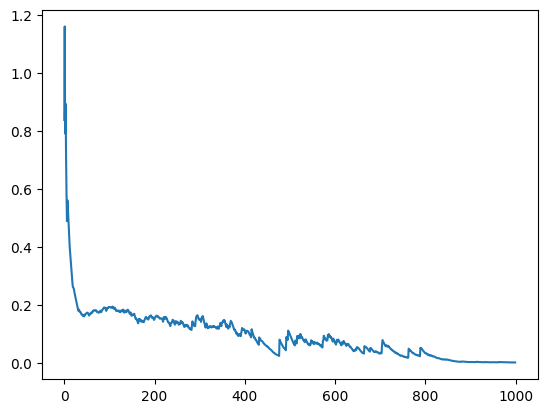

In [45]:
plt.plot(np.arange(len(losses)), losses)
plt.show()

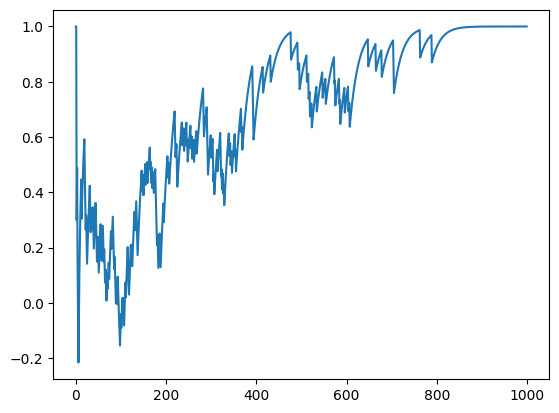

In [46]:
plt.plot(np.arange(len(scoress)), scoress)
plt.show()

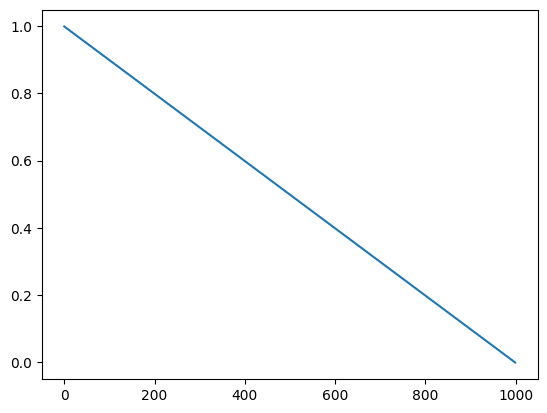

In [47]:
plt.plot(np.arange(len(epsilons)), epsilons)
plt.show()

In [48]:
class DeepLineWorld(DeepEnv):
  def __init__(self):
    self.agent_pos = 2
    
  def state_description(self) -> np.ndarray:
    return np.array([self.agent_pos / 4.0])
    
  def state_description_length(self) -> int:
    return 1

  def action_description_length(self) -> int:
    return 2

  def available_action_descriptions(self) -> np.ndarray:
    if self.is_game_over():
        return np.array([])
    return np.array([[1, 0], [0, 1]])

  def step(self, a_desc: np.ndarray):
    if self.is_game_over():
        raise Exception("Game is over !")

    if np.array_equal(np.array([1, 0]), a_desc):
        self.agent_pos -= 1
    elif np.array_equal(np.array([0, 1]), a_desc):
        self.agent_pos += 1
    else:
        raise Exception("Invalid Action !")

  def score(self) -> float:
    if self.agent_pos == 0:
        return -1.0
    elif self.agent_pos == 4:
        return 1.0
    return 0.0

  def is_game_over(self) -> bool:
    return self.agent_pos == 0 or self.agent_pos == 4

  def reset(self):
    self.agent_pos = 2

In [49]:
env = DeepLineWorld()

In [50]:
input_state_desc_tensor = keras.layers.Input(shape=(env.state_description_length(),))
input_action_desc_tensor = keras.layers.Input(shape=(env.action_description_length(),))

hidden_tensor = keras.layers.Concatenate()([input_state_desc_tensor, input_action_desc_tensor])

hidden_tensor = keras.layers.Dense(32, activation=keras.activations.tanh)(hidden_tensor)
hidden_tensor = keras.layers.Dense(32, activation=keras.activations.tanh)(hidden_tensor)

output_tensor = keras.layers.Dense(1, activation=keras.activations.linear)(hidden_tensor)

linear_Q_model = keras.models.Model([input_state_desc_tensor, input_action_desc_tensor], output_tensor)

In [51]:
(losses, scoress, epsilons) = episodic_semigradient_sarsa(
    env,
    linear_Q_model
)

  0%|                                                                                         | 1/1000 [00:00<02:27,  6.77it/s]

0.28997537
1.0
0.999


  0%|▏                                                                                        | 2/1000 [00:00<04:28,  3.71it/s]

0.35257798
1.0000000000000007
0.998


  0%|▎                                                                                        | 4/1000 [00:00<03:29,  4.76it/s]

0.30388483
1.0
0.997
0.30672395
0.4608982782438762
0.996


  1%|▌                                                                                        | 6/1000 [00:01<04:33,  3.63it/s]

0.29897103
0.580053073555638
0.995
0.2755122
0.6593158276168759
0.994


  1%|▌                                                                                        | 7/1000 [00:01<04:30,  3.67it/s]

0.27292717
0.38428749197407225
0.993


  1%|▋                                                                                        | 8/1000 [00:02<04:17,  3.85it/s]

0.26552352
0.1786470401077067
0.992


  1%|▊                                                                                        | 9/1000 [00:02<05:55,  2.79it/s]

0.26137808
0.019262975402110243
0.991


  1%|▉                                                                                       | 10/1000 [00:03<07:03,  2.34it/s]

0.24879657
-0.10774385316908804
0.99


  1%|█                                                                                       | 12/1000 [00:03<05:38,  2.92it/s]

0.24614787
0.020705136884883454
0.989
0.2649242
0.1272336211210763
0.988


  1%|█▏                                                                                      | 13/1000 [00:04<05:09,  3.19it/s]

0.26255405
0.2169030119696161
0.987


  2%|█▎                                                                                      | 15/1000 [00:04<03:56,  4.17it/s]

0.2565462
0.0981402185900566
0.986
0.26386997
0.18215783038335612
0.985


  2%|█▍                                                                                      | 17/1000 [00:04<03:34,  4.57it/s]

0.2574531
0.07658414396248345
0.984
0.2638968
0.15593180911807378
0.983


  2%|█▋                                                                                      | 19/1000 [00:05<03:13,  5.06it/s]

0.257347
0.06004932181666033
0.982
0.26336282
0.1355296170541061
0.981


  2%|█▊                                                                                      | 21/1000 [00:05<03:00,  5.43it/s]

0.26369014
0.20290696800730096
0.98
0.26464027
0.11170003981200127
0.979


  2%|██                                                                                      | 23/1000 [00:05<02:26,  6.65it/s]

0.26288489
0.17735739455499996
0.978
0.2573985
0.23674169847085944
0.977


  2%|██▏                                                                                     | 25/1000 [00:06<03:21,  4.83it/s]

0.25514516
0.29064328529416517
0.976
0.26401007
0.20133906013441863
0.975


  3%|██▎                                                                                     | 26/1000 [00:06<03:01,  5.35it/s]

0.26773393
0.1197795327727764
0.974


  3%|██▍                                                                                     | 28/1000 [00:07<03:38,  4.45it/s]

0.26516324
0.04509329889861966
0.973
0.26400697
-0.023466801076090976
0.972


  3%|██▋                                                                                     | 30/1000 [00:07<03:23,  4.77it/s]

0.2580898
-0.08654508787510617
0.971
0.2616031
-0.017370226805431415
0.97


  3%|██▋                                                                                     | 31/1000 [00:07<02:57,  5.46it/s]

0.26041597
0.046527458773804826
0.969


  3%|██▉                                                                                     | 33/1000 [00:08<03:20,  4.82it/s]

0.25956368
-0.01837036865407087
0.968
0.26063022
0.044031757922526706
0.967


  4%|███                                                                                     | 35/1000 [00:08<02:59,  5.38it/s]

0.2617939
-0.019229445486556387
0.966
0.25598145
-0.0780345187805312
0.965


  4%|███▎                                                                                    | 37/1000 [00:09<04:25,  3.63it/s]

0.25339544
-0.014034998838176401
0.964
0.25392073
0.045606418265186965
0.963


  4%|███▎                                                                                    | 38/1000 [00:09<04:46,  3.35it/s]

0.2507716
0.10124942447140267
0.962


  4%|███▍                                                                                    | 39/1000 [00:09<04:27,  3.60it/s]

0.24772994
0.1532169035750562
0.961


  4%|███▌                                                                                    | 41/1000 [00:10<03:35,  4.45it/s]

0.25032857
0.08705322084198737
0.96
0.25247228
0.025142037041470163
0.959


  4%|███▊                                                                                    | 43/1000 [00:10<02:41,  5.93it/s]

0.24829702
0.0802799531811276
0.958
0.2420202
0.13196025153227353
0.957


  4%|███▉                                                                                    | 45/1000 [00:10<02:44,  5.80it/s]

0.24013975
0.18043643253063915
0.956
0.24460852
0.11489739185681451
0.955


  5%|████                                                                                    | 46/1000 [00:11<03:33,  4.46it/s]

0.24159822
0.1637693724589954
0.954


  5%|████▏                                                                                   | 47/1000 [00:11<03:42,  4.28it/s]

0.23793513
0.20970323017687215
0.953


  5%|████▏                                                                                   | 48/1000 [00:11<03:50,  4.12it/s]

0.23351395
0.25290100703035573
0.952


  5%|████▍                                                                                   | 50/1000 [00:12<03:14,  4.88it/s]

0.22848478
0.2935481611742835
0.951
0.2184774
0.33181521026149785
0.95


  5%|████▌                                                                                   | 52/1000 [00:12<03:04,  5.13it/s]

0.210915
0.36785918214780616
0.949
0.20050007
0.4018248988792418
0.948


  5%|████▋                                                                                   | 53/1000 [00:12<03:31,  4.48it/s]

0.19369595
0.433846115984199
0.947


  6%|████▊                                                                                   | 55/1000 [00:13<03:04,  5.13it/s]

0.1837156
0.4640465358282469
0.946
0.1742514
0.4925407110589972
0.945


  6%|████▉                                                                                   | 56/1000 [00:13<03:02,  5.18it/s]

0.16529179
0.5194348518768945
0.944


  6%|█████                                                                                   | 58/1000 [00:13<03:28,  4.51it/s]

0.1629361
0.5448275489382203
0.943
0.19296329
0.4634311396764045
0.942


  6%|█████▏                                                                                  | 59/1000 [00:14<03:02,  5.15it/s]

0.18314059
0.49162692386063367
0.941


  6%|█████▎                                                                                  | 61/1000 [00:14<03:20,  4.68it/s]

0.19047719
0.4134436918863986
0.94
0.18164851
0.44411382585350795
0.939


  6%|█████▍                                                                                  | 62/1000 [00:14<03:16,  4.76it/s]

0.1730173
0.4731138994341542
0.938


  6%|█████▌                                                                                  | 63/1000 [00:15<03:22,  4.63it/s]

0.1683714
0.5005415727045905
0.9369999999999999


  6%|█████▋                                                                                  | 65/1000 [00:15<03:43,  4.19it/s]

0.17436437
0.42258940611857937
0.9359999999999999
0.16685061
0.4525271546438122
0.9349999999999999


  7%|█████▊                                                                                  | 66/1000 [00:15<03:10,  4.91it/s]

0.18327644
0.37735505343929415
0.9339999999999999


  7%|█████▉                                                                                  | 67/1000 [00:15<03:18,  4.70it/s]

0.19180228
0.3061980182105143
0.9329999999999999


  7%|██████                                                                                  | 69/1000 [00:16<03:52,  4.00it/s]

0.18948054
0.34198180014033114
0.9319999999999999
0.18243814
0.3758665701398277
0.9309999999999999


  7%|██████▏                                                                                 | 71/1000 [00:16<03:15,  4.76it/s]

0.17740148
0.40795845422908733
0.9299999999999999
0.16936958
0.4383571133606522
0.9289999999999999


  7%|██████▍                                                                                 | 73/1000 [00:17<02:49,  5.47it/s]

0.16149797
0.4671561899877481
0.9279999999999999
0.17865755
0.3920214770926607
0.9269999999999999


  7%|██████▌                                                                                 | 74/1000 [00:17<03:38,  4.24it/s]

0.17564248
0.4231190757312789
0.9259999999999999


  8%|██████▋                                                                                 | 76/1000 [00:18<04:16,  3.60it/s]

0.17727911
0.35041126580104737
0.9249999999999999
0.17023876
0.3835629032509668
0.9239999999999999


  8%|██████▊                                                                                 | 78/1000 [00:18<02:59,  5.12it/s]

0.16304928
0.414990131989572
0.9229999999999999
0.1752706
0.34292180500059244
0.9219999999999999


  8%|██████▉                                                                                 | 79/1000 [00:18<02:55,  5.24it/s]

0.1680263
0.3763569719075029
0.9209999999999999


  8%|███████▏                                                                                | 81/1000 [00:19<03:57,  3.87it/s]

0.16866177
0.40806275621005494
0.9199999999999999
0.17976497
0.3365374139849312
0.9189999999999999


  8%|███████▎                                                                                | 83/1000 [00:19<03:30,  4.35it/s]

0.17982908
0.37021247428167
0.9179999999999999
0.1724532
0.402154140378784
0.9169999999999999


  8%|███████▍                                                                                | 85/1000 [00:20<02:40,  5.69it/s]

0.18210596
0.3310904940253163
0.9159999999999999
0.18772791
0.26367444057411094
0.9149999999999999


  9%|███████▋                                                                                | 87/1000 [00:20<03:32,  4.29it/s]

0.19271132
0.19971422115632717
0.9139999999999999
0.18893613
0.24019539165885834
0.9129999999999999


  9%|███████▊                                                                                | 89/1000 [00:21<03:44,  4.06it/s]

0.19057684
0.27860647840235764
0.9119999999999999
0.1850584
0.31505554571477884
0.9109999999999999


  9%|████████                                                                                | 91/1000 [00:22<04:35,  3.30it/s]

0.1851853
0.24864608748590186
0.9099999999999999
0.18211065
0.286570038679206
0.9089999999999999


  9%|████████▏                                                                               | 93/1000 [00:22<03:25,  4.42it/s]

0.18516341
0.22166228376862615
0.9079999999999999
0.18146071
0.26091192951703496
0.9069999999999999


  9%|████████▎                                                                               | 94/1000 [00:22<04:14,  3.56it/s]

0.18191828
0.19735443238805048
0.9059999999999999


 10%|████████▎                                                                               | 95/1000 [00:23<04:07,  3.65it/s]

0.18121113
0.13702510525886963
0.9049999999999999


 10%|████████▌                                                                               | 97/1000 [00:23<03:44,  4.02it/s]

0.18257806
0.18048978855070322
0.9039999999999999
0.18288058
0.12105487645658546
0.9029999999999999


 10%|████████▋                                                                               | 99/1000 [00:23<02:49,  5.33it/s]

0.18035893
0.1652923367069369
0.9019999999999999
0.17979015
0.10666232969294294
0.9009999999999999


 10%|████████▊                                                                              | 101/1000 [00:24<02:18,  6.50it/s]

0.17751922
0.050999660750339286
0.8999999999999999
0.17523801
0.09871807003752839
0.8989999999999999


 10%|████████▊                                                                              | 102/1000 [00:24<02:09,  6.93it/s]

0.17134784
0.14402425003333252
0.8979999999999999


 10%|█████████                                                                              | 104/1000 [00:24<02:49,  5.28it/s]

0.17599662
0.08653119625139247
0.8969999999999999
0.17421453
0.13242595510404087
0.8959999999999999


 11%|█████████▏                                                                             | 106/1000 [00:25<03:14,  4.59it/s]

0.17935611
0.17600429813365173
0.8949999999999999
0.17473651
0.21738417395079687
0.8939999999999999


 11%|█████████▎                                                                             | 107/1000 [00:25<04:08,  3.60it/s]

0.17980978
0.25667742423259904
0.8929999999999999


 11%|█████████▍                                                                             | 109/1000 [00:26<03:49,  3.89it/s]

0.1797951
0.2939901097891194
0.8919999999999999
0.1848083
0.22904827970244812
0.8909999999999999


 11%|█████████▋                                                                             | 111/1000 [00:26<03:07,  4.74it/s]

0.18144879
0.2677329968323584
0.8899999999999999
0.18653244
0.2041321649841587
0.8889999999999999


 11%|█████████▋                                                                             | 112/1000 [00:26<02:41,  5.48it/s]

0.17908312
0.24405327305001998
0.8879999999999999


 11%|█████████▉                                                                             | 114/1000 [00:27<02:50,  5.20it/s]

0.180988
0.18166098320608842
0.8869999999999999
0.17504755
0.2226964154014669
0.8859999999999999


 12%|██████████                                                                             | 115/1000 [00:27<02:29,  5.93it/s]

0.17492595
0.16139344491958532
0.8849999999999999


 12%|██████████                                                                             | 116/1000 [00:27<03:28,  4.25it/s]

0.17868616
0.20343331945568735
0.8839999999999999


 12%|██████████▏                                                                            | 117/1000 [00:28<05:23,  2.73it/s]

0.18084723
0.24336049294783563
0.8829999999999999


 12%|██████████▎                                                                            | 119/1000 [00:28<03:55,  3.74it/s]

0.17662251
0.28128164820096463
0.8819999999999999
0.16855685
0.3172980311817625
0.8809999999999999


 12%|██████████▌                                                                            | 121/1000 [00:29<03:22,  4.33it/s]

0.16501269
0.3515057329512646
0.8799999999999999
0.1574935
0.38399595650584734
0.8789999999999999


 12%|██████████▋                                                                            | 123/1000 [00:29<02:32,  5.73it/s]

0.17251372
0.3146633527848502
0.8779999999999999
0.18197347
0.24881035143040964
0.8769999999999999


 12%|██████████▉                                                                            | 125/1000 [00:29<02:06,  6.93it/s]

0.1736353
0.28643487648718263
0.8759999999999999
0.16564812
0.32217182320286786
0.8749999999999999


 13%|███████████                                                                            | 127/1000 [00:29<02:25,  5.99it/s]

0.17628404
0.25595992967533315
0.8739999999999999
0.16836582
0.29321715471411625
0.8729999999999999


 13%|███████████▏                                                                           | 129/1000 [00:30<02:09,  6.73it/s]

0.17334628
0.2284651221651835
0.8719999999999999
0.17515904
0.16695959269508448
0.8709999999999999


 13%|███████████▍                                                                           | 131/1000 [00:30<02:44,  5.27it/s]

0.17747024
0.10853737155795658
0.8699999999999999
0.17157286
0.15316437832348137
0.8689999999999999


 13%|███████████▌                                                                           | 133/1000 [00:30<02:14,  6.47it/s]

0.16517548
0.19555477587347403
0.8679999999999999
0.1629934
0.13571183635529846
0.8669999999999999


 13%|███████████▋                                                                           | 134/1000 [00:31<02:19,  6.20it/s]

0.15685076
0.17897102013912392
0.8659999999999999


 14%|███████████▋                                                                           | 135/1000 [00:31<02:55,  4.93it/s]

0.15973763
0.22006287481565587
0.8649999999999999


 14%|███████████▊                                                                           | 136/1000 [00:31<04:10,  3.45it/s]

0.16633682
0.1590026925328665
0.8639999999999999


 14%|████████████                                                                           | 138/1000 [00:32<03:26,  4.17it/s]

0.17583817
0.1010010855616708
0.8629999999999999
0.17039025
0.14598895867655515
0.8619999999999999


 14%|████████████▏                                                                          | 140/1000 [00:32<02:31,  5.68it/s]

0.16719939
0.08864358253047543
0.8609999999999999
0.1617707
0.13424610053480232
0.8599999999999999


 14%|████████████▎                                                                          | 141/1000 [00:32<03:04,  4.67it/s]

0.16386165
0.17756510722161783
0.8589999999999999


 14%|████████████▎                                                                          | 142/1000 [00:33<03:13,  4.43it/s]

0.16529775
0.21871510858423227
0.8579999999999999


 14%|████████████▌                                                                          | 144/1000 [00:34<04:24,  3.23it/s]

0.17319591
0.25780485304975953
0.8569999999999999
0.16560185
0.29493762251053246
0.8559999999999999


 14%|████████████▌                                                                          | 145/1000 [00:34<05:25,  2.62it/s]

0.16518545
0.3302115084955033
0.8549999999999999


 15%|████████████▋                                                                          | 146/1000 [00:35<09:05,  1.57it/s]

0.16460347
0.26366371275548767
0.8539999999999999


 15%|████████████▊                                                                          | 147/1000 [00:36<07:20,  1.94it/s]

0.16114965
0.30050009964932606
0.8529999999999999


 15%|████████████▉                                                                          | 148/1000 [00:36<06:34,  2.16it/s]

0.15741941
0.3354927579128901
0.8519999999999999


 15%|████████████▉                                                                          | 149/1000 [00:36<06:07,  2.32it/s]

0.15913367
0.26868608410926664
0.8509999999999999


 15%|█████████████▏                                                                         | 151/1000 [00:37<04:26,  3.18it/s]

0.156089
0.3052684451803677
0.8499999999999999
0.15069436
0.3400200626299398
0.8489999999999999


 15%|█████████████▎                                                                         | 153/1000 [00:37<03:35,  3.94it/s]

0.14664166
0.37303263223231614
0.8479999999999999
0.14049612
0.4043932494959464
0.8469999999999999


 15%|█████████████▍                                                                         | 154/1000 [00:37<03:37,  3.90it/s]

0.13703771
0.4341846411877592
0.8459999999999999


 16%|█████████████▍                                                                         | 155/1000 [00:38<04:51,  2.89it/s]

0.13490151
0.46248538513368526
0.8449999999999999


 16%|█████████████▋                                                                         | 157/1000 [00:38<04:21,  3.23it/s]

0.13189314
0.4893701188959683
0.8439999999999999
0.1263449
0.5149097378964455
0.8429999999999999


 16%|█████████████▊                                                                         | 159/1000 [00:39<03:32,  3.96it/s]

0.123315714
0.5391715835252451
0.8419999999999999
0.14657019
0.4621909021750832
0.8409999999999999


 16%|█████████████▉                                                                         | 160/1000 [00:39<03:39,  3.83it/s]

0.1431836
0.4890886936431352
0.8399999999999999


 16%|██████████████                                                                         | 162/1000 [00:40<04:04,  3.43it/s]

0.1411287
0.5146408800361453
0.8389999999999999
0.13582483
0.5389148113957248
0.8379999999999999


 16%|██████████████▏                                                                        | 163/1000 [00:40<03:20,  4.17it/s]

0.15935205
0.4619510724292291
0.8369999999999999


 16%|██████████████▎                                                                        | 165/1000 [00:41<03:23,  4.11it/s]

0.16364594
0.38883727564468484
0.8359999999999999
0.17275667
0.3193807527420879
0.8349999999999999


 17%|██████████████▍                                                                        | 166/1000 [00:41<02:52,  4.83it/s]

0.16551694
0.35341853974572174
0.8339999999999999


 17%|██████████████▌                                                                        | 167/1000 [00:41<03:31,  3.94it/s]

0.16416778
0.38575377186993404
0.8329999999999999


 17%|██████████████▋                                                                        | 169/1000 [00:42<03:57,  3.50it/s]

0.16653758
0.3164535431950192
0.8319999999999999
0.17006429
0.250619548822006
0.8309999999999998


 17%|██████████████▊                                                                        | 170/1000 [00:42<04:42,  2.93it/s]

0.1684167
0.2880946914481432
0.8299999999999998


 17%|██████████████▉                                                                        | 171/1000 [00:43<05:16,  2.62it/s]

0.16800882
0.2236799632821739
0.8289999999999998


 17%|███████████████                                                                        | 173/1000 [00:43<03:54,  3.52it/s]

0.16457678
0.262501686947712
0.8279999999999998
0.15870118
0.29938176647345865
0.8269999999999998


 18%|███████████████▏                                                                       | 175/1000 [00:43<03:18,  4.15it/s]

0.15688182
0.33441733847830757
0.8259999999999998
0.15065925
0.36770067744345747
0.8249999999999998


 18%|███████████████▎                                                                       | 176/1000 [00:44<03:00,  4.56it/s]

0.1444879
0.3993194393369315
0.8239999999999998


 18%|███████████████▍                                                                       | 178/1000 [00:44<02:48,  4.87it/s]

0.15115601
0.3293454871560422
0.8229999999999998
0.14520907
0.3628818462353915
0.8219999999999998


 18%|███████████████▋                                                                       | 180/1000 [00:45<03:44,  3.65it/s]

0.14494647
0.39474103306418473
0.8209999999999998
0.15576634
0.32499716187222377
0.8199999999999998


 18%|███████████████▊                                                                       | 182/1000 [00:45<03:33,  3.83it/s]

0.15400961
0.35875043914648813
0.8189999999999998
0.14754513
0.3908157468316923
0.8179999999999998


 18%|███████████████▉                                                                       | 183/1000 [00:46<04:24,  3.09it/s]

0.14578068
0.42127751321935886
0.8169999999999998


 18%|████████████████                                                                       | 184/1000 [00:46<04:04,  3.34it/s]

0.15428832
0.35020797742257953
0.8159999999999998


 19%|████████████████▏                                                                      | 186/1000 [00:47<03:29,  3.88it/s]

0.15138566
0.38270003690430215
0.8149999999999998
0.14511946
0.4135672537053061
0.8139999999999998


 19%|████████████████▎                                                                      | 187/1000 [00:47<05:27,  2.48it/s]

0.14660648
0.34288406454210363
0.8129999999999998


 19%|████████████████▍                                                                      | 189/1000 [00:48<04:33,  2.96it/s]

0.1474325
0.27573550544918835
0.8119999999999998
0.14338613
0.3119509619771945
0.8109999999999998


 19%|████████████████▌                                                                      | 190/1000 [00:48<04:22,  3.09it/s]

0.14037529
0.3463554280655149
0.8099999999999998


 19%|████████████████▋                                                                      | 192/1000 [00:49<03:51,  3.49it/s]

0.14241132
0.27903391243244297
0.8089999999999998
0.13824126
0.31508412156968796
0.8079999999999998


 19%|████████████████▉                                                                      | 194/1000 [00:49<02:46,  4.83it/s]

0.14247115
0.2493266148284005
0.8069999999999998
0.1439349
0.18685730525414712
0.8059999999999998


 20%|████████████████▉                                                                      | 195/1000 [00:49<03:08,  4.27it/s]

0.14274475
0.22751628186356154
0.8049999999999998


 20%|█████████████████                                                                      | 196/1000 [00:50<03:46,  3.55it/s]

0.14315662
0.26614213005224463
0.8039999999999998


 20%|█████████████████▏                                                                     | 197/1000 [00:50<03:38,  3.67it/s]

0.14109448
0.3028365237523857
0.8029999999999998


 20%|█████████████████▏                                                                     | 198/1000 [00:50<03:48,  3.51it/s]

0.14023206
0.33769605149207
0.8019999999999998


 20%|█████████████████▎                                                                     | 199/1000 [00:51<03:59,  3.35it/s]

0.13816638
0.37081247083198704
0.8009999999999998


 20%|█████████████████▍                                                                     | 201/1000 [00:51<03:06,  4.29it/s]

0.13689084
0.40227295006406627
0.7999999999999998
0.15122832
0.3321569676963407
0.7989999999999998


 20%|█████████████████▌                                                                     | 202/1000 [00:51<03:51,  3.44it/s]

0.15020566
0.36555017570670395
0.7979999999999998


 20%|█████████████████▋                                                                     | 204/1000 [00:52<04:01,  3.29it/s]

0.14861043
0.3972736203149234
0.7969999999999998
0.14356229
0.4274107997342063
0.7959999999999998


 21%|█████████████████▉                                                                     | 206/1000 [00:52<03:13,  4.11it/s]

0.14118138
0.45604103628783427
0.7949999999999998
0.13650204
0.4832396852991469
0.7939999999999998


 21%|██████████████████                                                                     | 208/1000 [00:53<02:45,  4.77it/s]

0.13212557
0.509078333527715
0.7929999999999998
0.12802853
0.533624987675302
0.7919999999999998


 21%|██████████████████▎                                                                    | 210/1000 [00:53<02:38,  4.98it/s]

0.124189034
0.5569442534589426
0.7909999999999998
0.12058683
0.579097505723525
0.7899999999999998


 21%|██████████████████▍                                                                    | 212/1000 [00:54<02:23,  5.48it/s]

0.1172032
0.6001430500425653
0.7889999999999998
0.11402101
0.6201362762333701
0.7879999999999998


 21%|██████████████████▌                                                                    | 214/1000 [00:54<03:00,  4.35it/s]

0.113236114
0.6391298041914093
0.7869999999999998
0.11017569
0.6571736224284304
0.7859999999999998


 22%|██████████████████▊                                                                    | 216/1000 [00:54<02:23,  5.45it/s]

0.107296124
0.6743152196795693
0.7849999999999998
0.12847744
0.590598167141284
0.7839999999999998


 22%|██████████████████▉                                                                    | 218/1000 [00:55<02:00,  6.46it/s]

0.12396765
0.6110685588030406
0.7829999999999998
0.13841917
0.5305140092679872
0.7819999999999998


 22%|███████████████████                                                                    | 219/1000 [00:55<02:04,  6.27it/s]

0.1330674
0.5539886193091208
0.7809999999999998


 22%|███████████████████▏                                                                   | 220/1000 [00:55<02:39,  4.89it/s]

0.13365522
0.5762894685736254
0.7799999999999998


 22%|███████████████████▏                                                                   | 221/1000 [00:56<03:22,  3.85it/s]

0.13329256
0.5974752480521575
0.7789999999999998


 22%|███████████████████▍                                                                   | 223/1000 [00:56<03:08,  4.11it/s]

0.13884905
0.5176005798138313
0.7779999999999998
0.1333711
0.5417208106867334
0.7769999999999998


 22%|███████████████████▍                                                                   | 224/1000 [00:56<03:10,  4.07it/s]

0.12811261
0.5646350046790306
0.7759999999999998


 22%|███████████████████▌                                                                   | 225/1000 [00:57<03:33,  3.63it/s]

0.12763749
0.5864034661051437
0.7749999999999998


 23%|███████████████████▋                                                                   | 226/1000 [00:57<04:03,  3.18it/s]

0.12900382
0.6070834838229043
0.7739999999999998


 23%|███████████████████▊                                                                   | 228/1000 [00:58<03:38,  3.53it/s]

0.13669801
0.5267286044993862
0.7729999999999998
0.13148086
0.5503923715466166
0.7719999999999998


 23%|████████████████████                                                                   | 230/1000 [00:58<02:52,  4.46it/s]

0.13046932
0.5728729310072938
0.7709999999999998
0.14311084
0.4942286927643442
0.7699999999999998


 23%|████████████████████                                                                   | 231/1000 [00:58<02:27,  5.21it/s]

0.13747588
0.5195174388768812
0.7689999999999998


 23%|████████████████████▎                                                                  | 233/1000 [00:59<03:15,  3.93it/s]

0.13767226
0.5435417300604731
0.7679999999999998
0.13265564
0.5663647907798578
0.7669999999999998


 24%|████████████████████▍                                                                  | 235/1000 [01:00<03:47,  3.36it/s]

0.13171531
0.5880466841090005
0.7659999999999998
0.14944553
0.5086438876470354
0.7649999999999998


 24%|████████████████████▌                                                                  | 237/1000 [01:00<03:05,  4.12it/s]

0.1437926
0.5332118291397024
0.7639999999999998
0.13852888
0.5565513603098522
0.7629999999999998


 24%|████████████████████▊                                                                  | 239/1000 [01:00<02:32,  4.99it/s]

0.13363478
0.5787239029652892
0.7619999999999998
0.12908779
0.5997878076974875
0.7609999999999998


 24%|████████████████████▉                                                                  | 241/1000 [01:01<02:29,  5.06it/s]

0.13849503
0.5197980569832844
0.7599999999999998
0.1475341
0.4438078289370513
0.7589999999999998


 24%|█████████████████████▏                                                                 | 243/1000 [01:01<02:08,  5.89it/s]

0.14170584
0.4716175505502352
0.7579999999999998
0.14725566
0.3980363888366931
0.7569999999999998


 24%|█████████████████████▎                                                                 | 245/1000 [01:01<02:26,  5.16it/s]

0.15102486
0.3281343129170678
0.7559999999999998
0.14590871
0.3617277143659245
0.7549999999999998


 25%|█████████████████████▍                                                                 | 246/1000 [01:02<02:10,  5.76it/s]

0.14059253
0.3936414343255664
0.7539999999999998


 25%|█████████████████████▍                                                                 | 247/1000 [01:02<02:37,  4.77it/s]

0.14082156
0.4239594579835948
0.7529999999999998


 25%|█████████████████████▋                                                                 | 249/1000 [01:02<02:43,  4.59it/s]

0.1443143
0.3527612723082199
0.7519999999999998
0.13898478
0.38512330057121447
0.7509999999999998


 25%|█████████████████████▊                                                                 | 250/1000 [01:03<02:47,  4.48it/s]

0.14179118
0.31586694874950927
0.7499999999999998


 25%|█████████████████████▉                                                                 | 252/1000 [01:03<03:18,  3.76it/s]

0.14667554
0.3500736889589453
0.7489999999999998
0.14123121
0.3825700836123148
0.7479999999999998


 25%|██████████████████████                                                                 | 254/1000 [01:04<02:41,  4.61it/s]

0.1481676
0.3134414195751983
0.7469999999999998
0.14285524
0.34776942400910554
0.7459999999999998


 26%|██████████████████████▏                                                                | 255/1000 [01:04<04:42,  2.63it/s]

0.14778319
0.2803808121696213
0.7449999999999998


 26%|██████████████████████▎                                                                | 256/1000 [01:05<05:08,  2.41it/s]

0.14826098
0.3163618428984216
0.7439999999999998


 26%|██████████████████████▎                                                                | 257/1000 [01:05<04:33,  2.72it/s]

0.1520816
0.2505436267846236
0.7429999999999998


 26%|██████████████████████▍                                                                | 258/1000 [01:05<04:02,  3.06it/s]

0.14692603
0.288016512496708
0.7419999999999998


 26%|██████████████████████▌                                                                | 259/1000 [01:06<04:54,  2.52it/s]

0.14907354
0.22361557739914392
0.7409999999999998


 26%|██████████████████████▌                                                                | 260/1000 [01:06<05:30,  2.24it/s]

0.14800242
0.26243486121725595
0.7399999999999998


 26%|██████████████████████▊                                                                | 262/1000 [01:07<03:59,  3.08it/s]

0.14318393
0.2993131747323663
0.7389999999999998
0.1381802
0.33434756705555574
0.7379999999999998


 26%|██████████████████████▉                                                                | 263/1000 [01:07<03:30,  3.51it/s]

0.13319647
0.36763023478424744
0.7369999999999998


 26%|███████████████████████                                                                | 265/1000 [01:08<02:54,  4.21it/s]

0.13587037
0.2992486331012696
0.7359999999999998
0.13155495
0.33428624522763206
0.7349999999999998


 27%|███████████████████████▏                                                               | 266/1000 [01:08<02:54,  4.20it/s]

0.12706384
0.3675719724789824
0.7339999999999998


 27%|███████████████████████▏                                                               | 267/1000 [01:08<02:53,  4.22it/s]

0.12259276
0.3991934095152694
0.7329999999999998


 27%|███████████████████████▍                                                               | 269/1000 [01:09<03:00,  4.05it/s]

0.12558314
0.4292337712228653
0.7319999999999998
0.12129886
0.4577721117072007
0.7309999999999998


 27%|███████████████████████▌                                                               | 271/1000 [01:09<03:05,  3.92it/s]

0.1236067
0.48488353233538245
0.7299999999999998
0.13412172
0.410639287522468
0.7289999999999998


 27%|███████████████████████▋                                                               | 272/1000 [01:09<02:37,  4.62it/s]

0.139999
0.3401072615993292
0.7279999999999998


 27%|███████████████████████▊                                                               | 274/1000 [01:10<02:20,  5.17it/s]

0.14194088
0.3731019258712916
0.7269999999999998
0.14552823
0.30444677550964394
0.7259999999999998


 28%|███████████████████████▉                                                               | 275/1000 [01:10<04:20,  2.78it/s]

0.1481185
0.3392244627532547
0.7249999999999998


 28%|████████████████████████                                                               | 277/1000 [01:11<03:22,  3.58it/s]

0.14786227
0.3722632630978215
0.7239999999999998
0.15356311
0.3036500536146266
0.7229999999999998


 28%|████████████████████████▏                                                              | 278/1000 [01:11<03:12,  3.75it/s]

0.14782712
0.3384675732675656
0.7219999999999998


 28%|████████████████████████▎                                                              | 280/1000 [01:12<02:56,  4.08it/s]

0.1475195
0.3715442147603234
0.7209999999999998
0.1427278
0.4029670222132189
0.7199999999999998


 28%|████████████████████████▍                                                              | 281/1000 [01:12<03:05,  3.88it/s]

0.14383972
0.4328186875198548
0.7189999999999998


 28%|████████████████████████▌                                                              | 283/1000 [01:12<02:31,  4.72it/s]

0.13931173
0.4611777679604716
0.7179999999999997
0.1351387
0.48811889293443744
0.7169999999999997


 28%|████████████████████████▊                                                              | 285/1000 [01:12<02:08,  5.57it/s]

0.13129263
0.5137129603559354
0.7159999999999997
0.14004397
0.4380272784348961
0.7149999999999997


 29%|████████████████████████▉                                                              | 287/1000 [01:13<01:46,  6.68it/s]

0.14455317
0.36612588391547635
0.7139999999999997
0.14601676
0.297819562105302
0.7129999999999997


 29%|█████████████████████████▏                                                             | 289/1000 [01:13<01:52,  6.32it/s]

0.14065719
0.3329285974839897
0.7119999999999997
0.14058124
0.26628214329340705
0.7109999999999997


 29%|█████████████████████████▏                                                             | 290/1000 [01:14<03:34,  3.31it/s]

0.14993735
0.2029680141832017
0.7099999999999997


 29%|█████████████████████████▎                                                             | 291/1000 [01:14<04:46,  2.47it/s]

0.15318453
0.242819626596495
0.7089999999999997


 29%|█████████████████████████▍                                                             | 293/1000 [01:15<03:21,  3.51it/s]

0.15277869
0.28067865710968404
0.7079999999999997
0.15340137
0.21664470522473145
0.7069999999999997


 30%|█████████████████████████▋                                                             | 295/1000 [01:15<02:34,  4.56it/s]

0.14831047
0.25581248102129833
0.7059999999999997
0.14315931
0.29302186694990073
0.7049999999999997


 30%|█████████████████████████▊                                                             | 296/1000 [01:15<02:15,  5.18it/s]

0.1381312
0.3283707826090552
0.7039999999999997


 30%|█████████████████████████▊                                                             | 297/1000 [01:15<02:36,  4.49it/s]

0.14410836
0.2619522274017807
0.7029999999999997


 30%|█████████████████████████▉                                                             | 298/1000 [01:16<02:37,  4.47it/s]

0.1391521
0.29885462451741673
0.7019999999999997


 30%|██████████████████████████                                                             | 299/1000 [01:16<03:43,  3.14it/s]

0.14131506
0.3339119009499126
0.7009999999999997


 30%|██████████████████████████                                                             | 300/1000 [01:17<03:56,  2.96it/s]

0.14588532
0.26721629206105485
0.6999999999999997


 30%|██████████████████████████▎                                                            | 302/1000 [01:17<03:20,  3.48it/s]

0.14743187
0.3038554846815589
0.6989999999999997
0.142459
0.3386627169667408
0.6979999999999997


 30%|██████████████████████████▎                                                            | 303/1000 [01:17<03:08,  3.69it/s]

0.13757621
0.3717295870020356
0.6969999999999997


 30%|██████████████████████████▍                                                            | 304/1000 [01:18<03:18,  3.51it/s]

0.13772775
0.4031431129619115
0.6959999999999997


 30%|██████████████████████████▌                                                            | 305/1000 [01:18<03:54,  2.96it/s]

0.13798293
0.4329859621060707
0.6949999999999997


 31%|██████████████████████████▌                                                            | 306/1000 [01:18<03:34,  3.23it/s]

0.13373819
0.4613366683257771
0.6939999999999997


 31%|██████████████████████████▋                                                            | 307/1000 [01:19<03:56,  2.93it/s]

0.13358143
0.48826983881280955
0.6929999999999997


 31%|██████████████████████████▊                                                            | 308/1000 [01:19<04:32,  2.54it/s]

0.13379557
0.5138563503949165
0.6919999999999997


 31%|██████████████████████████▉                                                            | 309/1000 [01:20<04:13,  2.72it/s]

0.13224177
0.5381635360544502
0.6909999999999997


 31%|██████████████████████████▉                                                            | 310/1000 [01:20<03:48,  3.02it/s]

0.13196763
0.5612553621210274
0.6899999999999997


 31%|███████████████████████████▏                                                           | 312/1000 [01:21<03:38,  3.16it/s]

0.12949638
0.5831925966045192
0.6889999999999997
0.1508638
0.5040329578972433
0.6879999999999997


 31%|███████████████████████████▎                                                           | 314/1000 [01:21<02:31,  4.52it/s]

0.14687125
0.5288313126442505
0.6869999999999997
0.1432057
0.5523897493963251
0.6859999999999997


 32%|███████████████████████████▍                                                           | 315/1000 [01:21<02:47,  4.09it/s]

0.14210063
0.5747702640783278
0.6849999999999997


 32%|███████████████████████████▍                                                           | 316/1000 [01:21<03:05,  3.69it/s]

0.14182639
0.5960317528164281
0.6839999999999997


 32%|███████████████████████████▋                                                           | 318/1000 [01:22<03:36,  3.15it/s]

0.14551689
0.5162301582510105
0.6829999999999997
0.14157678
0.5404186523324148
0.6819999999999997


 32%|███████████████████████████▊                                                           | 320/1000 [01:23<03:52,  2.93it/s]

0.14104776
0.5633977215153384
0.6809999999999997
0.13812175
0.58522783706366
0.6799999999999997


 32%|███████████████████████████▉                                                           | 321/1000 [01:23<03:18,  3.42it/s]

0.1353759
0.605966446676217
0.6789999999999997


 32%|████████████████████████████                                                           | 322/1000 [01:24<03:16,  3.45it/s]

0.13511333
0.6256681256652366
0.6779999999999997


 32%|████████████████████████████▏                                                          | 324/1000 [01:24<02:59,  3.76it/s]

0.135609
0.6443847205758292
0.6769999999999997
0.13531956
0.6621654856244913
0.6759999999999997


 32%|████████████████████████████▎                                                          | 325/1000 [01:24<03:14,  3.47it/s]

0.13437629
0.6790572123156686
0.6749999999999997


 33%|████████████████████████████▍                                                          | 327/1000 [01:25<03:26,  3.27it/s]

0.13207263
0.6951043525774779
0.6739999999999997
0.13047695
0.7103491357406314
0.6729999999999997


 33%|████████████████████████████▌                                                          | 328/1000 [01:25<02:49,  3.96it/s]

0.1535816
0.6248316747327748
0.6719999999999997


 33%|████████████████████████████▌                                                          | 329/1000 [01:25<02:44,  4.09it/s]

0.15027101
0.6435900918756897
0.6709999999999997


 33%|████████████████████████████▊                                                          | 331/1000 [01:26<02:18,  4.83it/s]

0.1482785
0.6614105880757024
0.6699999999999997
0.14536537
0.6783400593883192
0.6689999999999997


 33%|████████████████████████████▉                                                          | 333/1000 [01:26<01:56,  5.71it/s]

0.1425568
0.6944230570654559
0.6679999999999997
0.13984951
0.709701904795697
0.6669999999999997


 33%|█████████████████████████████                                                          | 334/1000 [01:27<04:01,  2.76it/s]

0.13705492
0.7242168100825335
0.6659999999999997


 34%|█████████████████████████████▏                                                         | 335/1000 [01:27<03:47,  2.92it/s]

0.13536628
0.7380059700536825
0.6649999999999997


 34%|█████████████████████████████▎                                                         | 337/1000 [01:28<03:55,  2.82it/s]

0.13255574
0.7511056719799346
0.6639999999999997
0.1313407
0.7635503887680529
0.6629999999999997


 34%|█████████████████████████████▍                                                         | 338/1000 [01:28<03:07,  3.53it/s]

0.15850574
0.6753728667238779
0.6619999999999997


 34%|█████████████████████████████▌                                                         | 340/1000 [01:29<02:42,  4.05it/s]

0.15602624
0.691604223843361
0.6609999999999997
0.17646332
0.607024010395424
0.6599999999999997


 34%|█████████████████████████████▊                                                         | 342/1000 [01:29<02:08,  5.13it/s]

0.17108427
0.6266728103734879
0.6589999999999997
0.1660485
0.6453391703041096
0.6579999999999997


 34%|█████████████████████████████▉                                                         | 344/1000 [01:29<02:06,  5.19it/s]

0.1639645
0.6630722121943938
0.6569999999999997
0.16038655
0.6799186019506286
0.6559999999999997


 34%|██████████████████████████████                                                         | 345/1000 [01:30<02:43,  4.01it/s]

0.15782729
0.695922672183371
0.6549999999999997


 35%|██████████████████████████████▏                                                        | 347/1000 [01:30<03:02,  3.59it/s]

0.15568078
0.7111265388722748
0.6539999999999997
0.15295847
0.7255702121976713
0.6529999999999997


 35%|██████████████████████████████▎                                                        | 348/1000 [01:31<02:41,  4.05it/s]

0.1502105
0.7392917018305694
0.6519999999999997


 35%|██████████████████████████████▎                                                        | 349/1000 [01:31<03:03,  3.55it/s]

0.14893688
0.7523271169581514
0.6509999999999997


 35%|██████████████████████████████▌                                                        | 351/1000 [01:31<03:02,  3.56it/s]

0.1465131
0.764710761307991
0.6499999999999997
0.17085922
0.6764752219040587
0.6489999999999997


 35%|██████████████████████████████▋                                                        | 353/1000 [01:32<03:08,  3.44it/s]

0.16781549
0.6926514610419795
0.6479999999999997
0.164034
0.7080188882002748
0.6469999999999997


 35%|██████████████████████████████▊                                                        | 354/1000 [01:32<02:36,  4.12it/s]

0.16033596
0.7226179439801419
0.6459999999999997


 36%|██████████████████████████████▉                                                        | 355/1000 [01:33<02:55,  3.67it/s]

0.15842968
0.7364870469525022
0.6449999999999997


 36%|██████████████████████████████▉                                                        | 356/1000 [01:33<02:51,  3.76it/s]

0.15592623
0.7496626947595363
0.6439999999999997


 36%|███████████████████████████████▏                                                       | 358/1000 [01:33<02:49,  3.79it/s]

0.15467854
0.7621795601611393
0.6429999999999997
0.15311934
0.7740705822790531
0.6419999999999997


 36%|███████████████████████████████▎                                                       | 360/1000 [01:34<03:06,  3.44it/s]

0.15132041
0.7853670532787891
0.6409999999999997
0.15025234
0.7960987007174536
0.6399999999999997


 36%|███████████████████████████████▍                                                       | 361/1000 [01:34<02:34,  4.15it/s]

0.17796013
0.7062937648658973
0.6389999999999997


 36%|███████████████████████████████▍                                                       | 362/1000 [01:35<03:01,  3.51it/s]

0.17490748
0.7209790767493176
0.6379999999999997


 36%|███████████████████████████████▌                                                       | 363/1000 [01:35<03:42,  2.87it/s]

0.17670356
0.634930122206486
0.6369999999999997


 36%|███████████████████████████████▋                                                       | 364/1000 [01:35<03:26,  3.09it/s]

0.17048918
0.6531836162383089
0.6359999999999997


 37%|███████████████████████████████▊                                                       | 366/1000 [01:36<02:56,  3.59it/s]

0.1751943
0.5705244348148785
0.6349999999999997
0.16828202
0.5919982132250551
0.6339999999999997


 37%|███████████████████████████████▉                                                       | 367/1000 [01:36<03:01,  3.50it/s]

0.1705408
0.5123983020323359
0.6329999999999997


 37%|████████████████████████████████                                                       | 369/1000 [01:37<02:32,  4.14it/s]

0.16393237
0.5367783870853592
0.6319999999999997
0.15753752
0.559939467870654
0.6309999999999997


 37%|████████████████████████████████▏                                                      | 370/1000 [01:37<03:19,  3.16it/s]

0.15636161
0.5819424946030765
0.6299999999999997


 37%|████████████████████████████████▎                                                      | 372/1000 [01:38<02:40,  3.91it/s]

0.15031962
0.6028453699865973
0.6289999999999997
0.14464825
0.6227031015898589
0.6279999999999997


 37%|████████████████████████████████▍                                                      | 373/1000 [01:38<04:05,  2.55it/s]

0.14563772
0.6415679466029547
0.6269999999999997


 38%|████████████████████████████████▋                                                      | 375/1000 [01:39<03:48,  2.74it/s]

0.14530668
0.6594895493563683
0.6259999999999997
0.14028428
0.676515071963964
0.6249999999999997


 38%|████████████████████████████████▋                                                      | 376/1000 [01:39<04:02,  2.57it/s]

0.13869774
0.692689318433827
0.6239999999999997


 38%|████████████████████████████████▉                                                      | 378/1000 [01:40<03:21,  3.09it/s]

0.13793953
0.7080548525735608
0.6229999999999997
0.1564904
0.6226521096205471
0.6219999999999997


 38%|█████████████████████████████████                                                      | 380/1000 [01:40<02:48,  3.69it/s]

0.15421528
0.6415195042075902
0.6209999999999997
0.14930922
0.6594435290586442
0.6199999999999997


 38%|█████████████████████████████████▏                                                     | 382/1000 [01:41<02:28,  4.17it/s]

0.14474253
0.6764713526611558
0.6189999999999997
0.14048764
0.6926477850781361
0.6179999999999997


 38%|█████████████████████████████████▍                                                     | 384/1000 [01:41<02:14,  4.59it/s]

0.1387394
0.7080153958693886
0.6169999999999997
0.15357672
0.622614625837508
0.6159999999999997


 38%|█████████████████████████████████▍                                                     | 385/1000 [01:42<02:08,  4.80it/s]

0.14819475
0.6414838945956756
0.6149999999999997


 39%|█████████████████████████████████▋                                                     | 387/1000 [01:42<02:04,  4.91it/s]

0.14320706
0.6594096999110556
0.6139999999999997
0.13858834
0.6764392149562632
0.6129999999999997


 39%|█████████████████████████████████▊                                                     | 388/1000 [01:42<02:45,  3.70it/s]

0.13801993
0.6926172542452362
0.6119999999999997


 39%|█████████████████████████████████▉                                                     | 390/1000 [01:43<02:48,  3.61it/s]

0.13585526
0.7079863915661739
0.6109999999999997
0.14989437
0.6225870718126142
0.6099999999999997


 39%|██████████████████████████████████                                                     | 392/1000 [01:44<03:12,  3.16it/s]

0.14792106
0.6414577182587724
0.6089999999999997
0.14254792
0.6593848323790357
0.6079999999999997


 39%|██████████████████████████████████▏                                                    | 393/1000 [01:44<02:45,  3.67it/s]

0.1375581
0.6764155907900488
0.6069999999999997


 40%|██████████████████████████████████▎                                                    | 395/1000 [01:44<02:23,  4.21it/s]

0.13294478
0.6925948112775895
0.6059999999999997
0.12869252
0.7079650707381165
0.6049999999999996


 40%|██████████████████████████████████▌                                                    | 397/1000 [01:45<02:11,  4.58it/s]

0.12478066
0.7225668172232377
0.6039999999999996
0.12118562
0.7364384763819549
0.6029999999999996


 40%|██████████████████████████████████▋                                                    | 399/1000 [01:45<02:06,  4.74it/s]

0.117882654
0.7496165525807983
0.6019999999999996
0.11484695
0.7621357249679501
0.6009999999999996


 40%|██████████████████████████████████▊                                                    | 400/1000 [01:45<02:19,  4.29it/s]

0.11531262
0.7740289387341656
0.5999999999999996


 40%|██████████████████████████████████▉                                                    | 401/1000 [01:46<02:41,  3.70it/s]

0.1154209
0.7853274918106457
0.5989999999999996


 40%|██████████████████████████████████▉                                                    | 402/1000 [01:46<02:33,  3.90it/s]

0.11330798
0.7960611172320158
0.5979999999999996


 40%|███████████████████████████████████                                                    | 403/1000 [01:46<03:03,  3.25it/s]

0.1195255
0.706258061275812
0.5969999999999996


 40%|███████████████████████████████████▏                                                   | 404/1000 [01:47<02:49,  3.51it/s]

0.11559866
0.72094515822672
0.5959999999999996


 40%|███████████████████████████████████▏                                                   | 405/1000 [01:47<03:15,  3.04it/s]

0.115681544
0.7348979003286493
0.5949999999999996


 41%|███████████████████████████████████▍                                                   | 407/1000 [01:48<03:32,  2.80it/s]

0.11578334
0.7481530053241888
0.5939999999999996
0.13396555
0.6607453549829801
0.5929999999999996


 41%|███████████████████████████████████▍                                                   | 408/1000 [01:48<03:09,  3.12it/s]

0.12975086
0.6777080872476581
0.5919999999999996


 41%|███████████████████████████████████▋                                                   | 410/1000 [01:49<02:33,  3.84it/s]

0.12586339
0.6938226828977542
0.5909999999999996
0.122277856
0.7091315487641285
0.5899999999999996


 41%|███████████████████████████████████▊                                                   | 412/1000 [01:49<02:15,  4.34it/s]

0.121762626
0.7236749713360863
0.5889999999999996
0.13562565
0.6374912227120615
0.5879999999999996


 41%|███████████████████████████████████▉                                                   | 413/1000 [01:49<02:38,  3.70it/s]

0.13472368
0.6556166615878909
0.5869999999999996


 41%|████████████████████████████████████                                                   | 414/1000 [01:50<04:28,  2.18it/s]

0.13447541
0.6728358285188141
0.5859999999999996


 42%|████████████████████████████████████▏                                                  | 416/1000 [01:51<03:30,  2.78it/s]

0.1331006
0.6891940371021852
0.5849999999999996
0.1291003
0.7047343352554798
0.5839999999999996


 42%|████████████████████████████████████▎                                                  | 417/1000 [01:51<03:05,  3.15it/s]

0.12540004
0.7194976185002904
0.5829999999999996


 42%|████████████████████████████████████▍                                                  | 419/1000 [01:52<02:29,  3.88it/s]

0.12197466
0.7335227375821208
0.5819999999999996
0.118800215
0.7468466007091924
0.5809999999999996


 42%|████████████████████████████████████▌                                                  | 420/1000 [01:52<03:28,  2.78it/s]

0.12359554
0.6595042706352612
0.5799999999999996


 42%|████████████████████████████████████▋                                                  | 422/1000 [01:53<02:48,  3.42it/s]

0.12277051
0.6765290571106222
0.5789999999999996
0.118805274
0.6927026042615204
0.5779999999999996


 42%|████████████████████████████████████▊                                                  | 423/1000 [01:53<02:56,  3.28it/s]

0.11840273
0.7080674740542469
0.5769999999999996


 42%|████████████████████████████████████▉                                                  | 425/1000 [01:53<02:28,  3.88it/s]

0.115537554
0.7226641003567712
0.5759999999999996
0.11286906
0.7365308953436588
0.5749999999999996


 43%|█████████████████████████████████████                                                  | 426/1000 [01:54<04:45,  2.01it/s]

0.11379054
0.7497043505807413
0.5739999999999996


 43%|█████████████████████████████████████▏                                                 | 427/1000 [01:55<04:08,  2.31it/s]

0.11295316
0.7622191330555538
0.5729999999999996


 43%|█████████████████████████████████████▎                                                 | 429/1000 [01:55<03:01,  3.15it/s]

0.11066991
0.7741081764062502
0.5719999999999996
0.10850654
0.7854027675890731
0.5709999999999996


 43%|█████████████████████████████████████▍                                                 | 431/1000 [01:55<02:13,  4.26it/s]

0.10645384
0.7961326292124493
0.5699999999999996
0.10450349
0.8063259977543806
0.5689999999999996


 43%|█████████████████████████████████████▋                                                 | 433/1000 [01:56<01:53,  4.98it/s]

0.10264793
0.8160096978689665
0.5679999999999996
0.1008803
0.8252092129775983
0.5669999999999996


 43%|█████████████████████████████████████▊                                                 | 434/1000 [01:56<02:49,  3.34it/s]

0.10077649
0.8339487523305957
0.5659999999999996


 44%|█████████████████████████████████████▉                                                 | 436/1000 [01:57<02:09,  4.34it/s]

0.09962116
0.8422513147157602
0.5649999999999996
0.09845068
0.8501387489815013
0.5639999999999996


 44%|██████████████████████████████████████                                                 | 437/1000 [01:57<03:09,  2.97it/s]

0.097600184
0.8576318115338062
0.5629999999999996


 44%|██████████████████████████████████████                                                 | 438/1000 [01:58<02:51,  3.28it/s]

0.09620846
0.8647502209583613
0.5619999999999996


 44%|██████████████████████████████████████▏                                                | 439/1000 [01:58<03:13,  2.89it/s]

0.095694795
0.8715127099115673
0.5609999999999996


 44%|██████████████████████████████████████▎                                                | 441/1000 [01:58<02:39,  3.51it/s]

0.10739665
0.7779370744012131
0.5599999999999996
0.103942044
0.7890402206828179
0.5589999999999996


 44%|██████████████████████████████████████▍                                                | 442/1000 [01:59<02:24,  3.85it/s]

0.10076702
0.7995882096501802
0.5579999999999996


 44%|██████████████████████████████████████▌                                                | 443/1000 [01:59<02:31,  3.68it/s]

0.10052144
0.8096087991690278
0.5569999999999996


 44%|██████████████████████████████████████▋                                                | 445/1000 [01:59<02:11,  4.22it/s]

0.09830291
0.8191283592118008
0.5559999999999996
0.09623063
0.8281719412523157
0.5549999999999996


 45%|██████████████████████████████████████▊                                                | 446/1000 [02:00<02:39,  3.48it/s]

0.09604521
0.8367633441906972
0.5539999999999996


 45%|██████████████████████████████████████▉                                                | 447/1000 [02:00<02:33,  3.61it/s]

0.094001174
0.8449251769820623
0.5529999999999996


 45%|██████████████████████████████████████▉                                                | 448/1000 [02:00<02:34,  3.57it/s]

0.09436962
0.8526789181337714
0.5519999999999996


 45%|███████████████████████████████████████                                                | 449/1000 [02:01<02:30,  3.66it/s]

0.10777326
0.7600449722178642
0.5509999999999996


 45%|███████████████████████████████████████▏                                               | 451/1000 [02:01<02:05,  4.39it/s]

0.10483658
0.7720427236081052
0.5499999999999996
0.12242806
0.6834405874197421
0.5489999999999996


 45%|███████████████████████████████████████▎                                               | 452/1000 [02:01<01:49,  5.03it/s]

0.13390537
0.5992685580415731
0.5479999999999996


 45%|███████████████████████████████████████▍                                               | 454/1000 [02:02<01:58,  4.60it/s]

0.137872
0.5193051301330127
0.5469999999999996
0.13269602
0.5433398736282129
0.5459999999999996


 46%|███████████████████████████████████████▌                                               | 455/1000 [02:02<01:51,  4.90it/s]

0.12763496
0.5661728799484725
0.5449999999999996


 46%|███████████████████████████████████████▋                                               | 456/1000 [02:02<01:58,  4.58it/s]

0.12277754
0.5878642359525564
0.5439999999999996


 46%|███████████████████████████████████████▊                                               | 457/1000 [02:02<02:22,  3.82it/s]

0.12523091
0.6084710241562893
0.5429999999999996


 46%|███████████████████████████████████████▊                                               | 458/1000 [02:03<02:17,  3.94it/s]

0.12054675
0.6280474729497026
0.5419999999999996


 46%|███████████████████████████████████████▉                                               | 459/1000 [02:03<02:15,  4.00it/s]

0.11616054
0.6466450993033257
0.5409999999999996


 46%|████████████████████████████████████████                                               | 460/1000 [02:03<02:24,  3.74it/s]

0.11751291
0.6643128443391596
0.5399999999999996


 46%|████████████████████████████████████████                                               | 461/1000 [02:04<02:51,  3.15it/s]

0.119246624
0.6810972021231042
0.5389999999999996


 46%|████████████████████████████████████████▏                                              | 462/1000 [02:04<02:37,  3.41it/s]

0.11655399
0.6970423420177636
0.5379999999999996


 46%|████████████████████████████████████████▎                                              | 463/1000 [02:04<02:33,  3.49it/s]

0.12841284
0.6121902249127573
0.5369999999999996


 46%|████████████████████████████████████████▎                                              | 464/1000 [02:05<03:03,  2.92it/s]

0.13068354
0.6315807136680135
0.5359999999999996


 47%|████████████████████████████████████████▌                                              | 466/1000 [02:05<02:50,  3.13it/s]

0.13703093
0.5500016779810395
0.5349999999999996
0.13187833
0.5725015940829238
0.5339999999999996


 47%|████████████████████████████████████████▋                                              | 467/1000 [02:05<02:28,  3.60it/s]

0.12705365
0.5938765143796225
0.5329999999999996


 47%|████████████████████████████████████████▋                                              | 468/1000 [02:06<03:07,  2.84it/s]

0.12738943
0.614182688661404
0.5319999999999996


 47%|████████████████████████████████████████▊                                              | 469/1000 [02:06<03:33,  2.49it/s]

0.12680547
0.633473554229022
0.5309999999999996


 47%|████████████████████████████████████████▉                                              | 470/1000 [02:07<03:09,  2.79it/s]

0.12340998
0.651799876518192
0.5299999999999996


 47%|████████████████████████████████████████▉                                              | 471/1000 [02:08<04:39,  1.89it/s]

0.12223142
0.6692098826928431
0.5289999999999996


 47%|█████████████████████████████████████████                                              | 472/1000 [02:08<03:54,  2.25it/s]

0.11870054
0.6857493885587067
0.5279999999999996


 47%|█████████████████████████████████████████▏                                             | 474/1000 [02:08<03:15,  2.69it/s]

0.117068835
0.7014619191312279
0.5269999999999996
0.11390197
0.7163888231750786
0.5259999999999996


 48%|█████████████████████████████████████████▎                                             | 475/1000 [02:09<03:12,  2.73it/s]

0.111833446
0.7305693820166965
0.5249999999999996


 48%|█████████████████████████████████████████▍                                             | 477/1000 [02:09<02:19,  3.75it/s]

0.10896754
0.7440409129161973
0.5239999999999996
0.1063178
0.7568388672706904
0.5229999999999996


 48%|█████████████████████████████████████████▌                                             | 478/1000 [02:09<01:56,  4.50it/s]

0.12736395
0.6689969239051807
0.5219999999999996


 48%|█████████████████████████████████████████▋                                             | 479/1000 [02:10<02:18,  3.77it/s]

0.12582345
0.6855470777102752
0.5209999999999996


 48%|█████████████████████████████████████████▊                                             | 481/1000 [02:11<02:46,  3.11it/s]

0.12460673
0.7012697238250805
0.5199999999999996
0.14588197
0.6162062376321866
0.5189999999999996


 48%|█████████████████████████████████████████▉                                             | 482/1000 [02:11<02:58,  2.91it/s]

0.14290258
0.6353959257509287
0.5179999999999996


 48%|██████████████████████████████████████████                                             | 484/1000 [02:11<02:13,  3.86it/s]

0.13819139
0.6536261294636995
0.5169999999999996
0.15360835
0.5709448229891478
0.5159999999999996


 48%|██████████████████████████████████████████▏                                            | 485/1000 [02:12<02:54,  2.95it/s]

0.15101095
0.5923975818400273
0.5149999999999996


 49%|██████████████████████████████████████████▎                                            | 487/1000 [02:12<02:20,  3.65it/s]

0.14804457
0.6127777027483301
0.5139999999999996
0.1431909
0.632138817611188
0.5129999999999996


 49%|██████████████████████████████████████████▌                                            | 489/1000 [02:13<03:09,  2.70it/s]

0.14115089
0.6505318767308762
0.5119999999999996
0.13651267
0.6680052828945559
0.5109999999999996


 49%|██████████████████████████████████████████▋                                            | 491/1000 [02:14<02:11,  3.87it/s]

0.15335006
0.5846050187488147
0.5099999999999996
0.1476662
0.6053747678116137
0.5089999999999996


 49%|██████████████████████████████████████████▊                                            | 492/1000 [02:14<02:02,  4.14it/s]

0.14238223
0.6251060294212494
0.5079999999999996


 49%|██████████████████████████████████████████▉                                            | 493/1000 [02:14<02:05,  4.06it/s]

0.13748023
0.6438507279503822
0.5069999999999996


 50%|███████████████████████████████████████████                                            | 495/1000 [02:15<02:39,  3.17it/s]

0.13530964
0.6616581915530394
0.5059999999999996
0.13073951
0.6785752819755464
0.5049999999999996


 50%|███████████████████████████████████████████▏                                           | 497/1000 [02:15<01:57,  4.28it/s]

0.1460393
0.5946465178760194
0.5039999999999996
0.14063698
0.6149141919823905
0.5029999999999996


 50%|███████████████████████████████████████████▍                                           | 499/1000 [02:16<01:29,  5.62it/s]

0.15082835
0.5341684823826199
0.5019999999999996
0.1565081
0.45746005826290154
0.5009999999999996


 50%|███████████████████████████████████████████▌                                           | 500/1000 [02:16<01:46,  4.69it/s]

0.15788467
0.3845870553492263
0.49999999999999956


 50%|███████████████████████████████████████████▌                                           | 501/1000 [02:17<02:56,  2.82it/s]

0.15830676
0.4153577025819777
0.49899999999999956


 50%|███████████████████████████████████████████▊                                           | 503/1000 [02:17<02:59,  2.77it/s]

0.15645882
0.4445898174530707
0.49799999999999955
0.15096694
0.4723603265805904
0.49699999999999955


 50%|███████████████████████████████████████████▊                                           | 504/1000 [02:18<02:42,  3.06it/s]

0.15189236
0.3987423102511246
0.49599999999999955


 51%|████████████████████████████████████████████                                           | 506/1000 [02:18<02:52,  2.87it/s]

0.15182918
0.32880519473817466
0.49499999999999955
0.14883143
0.26236493500091057
0.49399999999999955


 51%|████████████████████████████████████████████                                           | 507/1000 [02:19<02:44,  3.00it/s]

0.14990848
0.29924668825105244
0.49299999999999955


 51%|████████████████████████████████████████████▎                                          | 509/1000 [02:20<02:51,  2.86it/s]

0.14957777
0.33428435383866895
0.49199999999999955
0.14939304
0.2675701361464296
0.49099999999999955


 51%|████████████████████████████████████████████▎                                          | 510/1000 [02:20<02:33,  3.19it/s]

0.14583094
0.30419162933926763
0.48999999999999955


 51%|████████████████████████████████████████████▌                                          | 512/1000 [02:20<02:35,  3.14it/s]

0.14524606
0.33898204787244823
0.48899999999999955
0.14050905
0.37203294547895577
0.48799999999999955


 51%|████████████████████████████████████████████▋                                          | 513/1000 [02:21<02:30,  3.24it/s]

0.13976134
0.4034312982051253
0.48699999999999954


 52%|████████████████████████████████████████████▊                                          | 515/1000 [02:21<02:18,  3.49it/s]

0.13933565
0.43325973329497486
0.48599999999999954
0.1346381
0.4615967466303216
0.48499999999999954


 52%|████████████████████████████████████████████▉                                          | 516/1000 [02:22<02:25,  3.32it/s]

0.1352098
0.48851690929889174
0.48399999999999954


 52%|████████████████████████████████████████████▉                                          | 517/1000 [02:22<02:26,  3.30it/s]

0.14080241
0.4140910638337207
0.48299999999999954


 52%|█████████████████████████████████████████████                                          | 518/1000 [02:22<02:14,  3.58it/s]

0.13573423
0.44338651064211937
0.48199999999999954


 52%|█████████████████████████████████████████████▏                                         | 519/1000 [02:22<02:11,  3.66it/s]

0.13103224
0.4712171851100898
0.48099999999999954


 52%|█████████████████████████████████████████████▎                                         | 521/1000 [02:24<03:00,  2.66it/s]

0.13420816
0.4976563258546543
0.47999999999999954
0.1301472
0.5227735095619839
0.47899999999999954


 52%|█████████████████████████████████████████████▌                                         | 523/1000 [02:24<02:13,  3.57it/s]

0.12639536
0.5466348340839409
0.47799999999999954
0.12292692
0.5693030923797945
0.47699999999999954


 52%|█████████████████████████████████████████████▌                                         | 524/1000 [02:24<02:31,  3.15it/s]

0.12453633
0.5908379377608506
0.47599999999999953


 52%|█████████████████████████████████████████████▋                                         | 525/1000 [02:25<02:17,  3.45it/s]

0.122298524
0.6112960408728493
0.47499999999999953


 53%|█████████████████████████████████████████████▊                                         | 527/1000 [02:25<01:54,  4.12it/s]

0.12010888
0.6307312388292442
0.47399999999999953
0.117970996
0.6491946768878156
0.47299999999999953


 53%|█████████████████████████████████████████████▉                                         | 528/1000 [02:25<01:47,  4.37it/s]

0.11588742
0.6667349430434553
0.47199999999999953


 53%|██████████████████████████████████████████████                                         | 529/1000 [02:25<01:49,  4.31it/s]

0.11385986
0.6833981958913099
0.47099999999999953


 53%|██████████████████████████████████████████████                                         | 530/1000 [02:26<02:38,  2.96it/s]

0.11734972
0.6992282860967691
0.46999999999999953


 53%|██████████████████████████████████████████████▏                                        | 531/1000 [02:26<02:23,  3.28it/s]

0.11600931
0.7142668717919529
0.46899999999999953


 53%|██████████████████████████████████████████████▎                                        | 532/1000 [02:27<02:56,  2.65it/s]

0.1172493
0.7285535282023755
0.4679999999999995


 53%|██████████████████████████████████████████████▎                                        | 533/1000 [02:27<02:39,  2.92it/s]

0.11540552
0.7421258517922749
0.4669999999999995


 53%|██████████████████████████████████████████████▍                                        | 534/1000 [02:27<02:23,  3.25it/s]

0.1135616
0.7550195592026775
0.4659999999999995


 54%|██████████████████████████████████████████████▋                                        | 536/1000 [02:28<02:25,  3.19it/s]

0.115137495
0.7672685812425584
0.4649999999999995
0.11401401
0.7789051521804439
0.4639999999999995


 54%|██████████████████████████████████████████████▋                                        | 537/1000 [02:28<02:15,  3.43it/s]

0.11275599
0.7899598945714338
0.4629999999999995


 54%|██████████████████████████████████████████████▊                                        | 538/1000 [02:29<02:37,  2.93it/s]

0.11323942
0.800461899842873
0.4619999999999995


 54%|██████████████████████████████████████████████▉                                        | 539/1000 [02:29<03:36,  2.13it/s]

0.11748138
0.7104388048506407
0.4609999999999995


 54%|███████████████████████████████████████████████                                        | 541/1000 [02:30<02:32,  3.02it/s]

0.11359063
0.7249168646081222
0.4599999999999995
0.11000233
0.7386710213777283
0.4589999999999995


 54%|███████████████████████████████████████████████▏                                       | 542/1000 [02:30<02:09,  3.54it/s]

0.10669779
0.7517374703088529
0.4579999999999995


 54%|███████████████████████████████████████████████▏                                       | 543/1000 [02:30<02:03,  3.70it/s]

0.10365672
0.7641505967934202
0.4569999999999995


 55%|███████████████████████████████████████████████▍                                       | 545/1000 [02:31<01:47,  4.23it/s]

0.100858375
0.7759430669537583
0.4559999999999995
0.09828229
0.7871459136060784
0.4549999999999995


 55%|███████████████████████████████████████████████▌                                       | 546/1000 [02:31<01:38,  4.59it/s]

0.095908746
0.7977886179257818
0.4539999999999995


 55%|███████████████████████████████████████████████▋                                       | 548/1000 [02:31<01:39,  4.52it/s]

0.10403819
0.7078991870294339
0.4529999999999995
0.100434326
0.7225042276779713
0.4519999999999995


 55%|███████████████████████████████████████████████▊                                       | 549/1000 [02:32<01:41,  4.46it/s]

0.09709064
0.736379016294081
0.4509999999999995


 55%|███████████████████████████████████████████████▉                                       | 551/1000 [02:32<01:46,  4.20it/s]

0.0994879
0.7495600654793844
0.4499999999999995
0.096305415
0.7620820622054219
0.4489999999999995


 55%|████████████████████████████████████████████████                                       | 553/1000 [02:33<02:14,  3.32it/s]

0.09959601
0.7739779590951568
0.4479999999999995
0.0968897
0.7852790611404044
0.4469999999999995


 55%|████████████████████████████████████████████████▏                                      | 554/1000 [02:33<02:22,  3.13it/s]

0.0976644
0.7960151080833889
0.4459999999999995


 56%|████████████████████████████████████████████████▎                                      | 555/1000 [02:34<03:14,  2.29it/s]

0.09899802
0.806214352679224
0.4449999999999995


 56%|████████████████████████████████████████████████▍                                      | 557/1000 [02:34<02:21,  3.14it/s]

0.099489905
0.8159036350452669
0.4439999999999995
0.09818475
0.8251084532930071
0.4429999999999995


 56%|████████████████████████████████████████████████▌                                      | 558/1000 [02:35<02:08,  3.43it/s]

0.096868634
0.83385303062836
0.4419999999999995


 56%|████████████████████████████████████████████████▋                                      | 560/1000 [02:35<02:08,  3.41it/s]

0.096732445
0.842160379096945
0.4409999999999995
0.095054895
0.8500523601421004
0.4399999999999995


 56%|████████████████████████████████████████████████▊                                      | 561/1000 [02:35<01:45,  4.15it/s]

0.1178619
0.757549742134966
0.4389999999999995


 56%|████████████████████████████████████████████████▉                                      | 562/1000 [02:36<01:44,  4.18it/s]

0.117080465
0.7696722550282213
0.4379999999999995


 56%|█████████████████████████████████████████████████                                      | 564/1000 [02:36<01:34,  4.61it/s]

0.11425994
0.7811886422768136
0.4369999999999995
0.111588225
0.792129210162976
0.4359999999999995


 57%|█████████████████████████████████████████████████▏                                     | 566/1000 [02:37<01:44,  4.14it/s]

0.1107882
0.80252274965483
0.4349999999999995
0.10814949
0.8123966121720909
0.4339999999999995


 57%|█████████████████████████████████████████████████▍                                     | 568/1000 [02:37<01:27,  4.95it/s]

0.10566612
0.8217767815634885
0.4329999999999995
0.1254993
0.7306879424852939
0.4319999999999995


 57%|█████████████████████████████████████████████████▌                                     | 570/1000 [02:37<01:27,  4.89it/s]

0.121397234
0.744153545361032
0.4309999999999995
0.11759193
0.756945868092983
0.4299999999999995


 57%|█████████████████████████████████████████████████▋                                     | 571/1000 [02:38<01:30,  4.72it/s]

0.11406091
0.7690985746883363
0.4289999999999995


 57%|█████████████████████████████████████████████████▊                                     | 572/1000 [02:38<01:30,  4.72it/s]

0.110782325
0.7806436459539215
0.4279999999999995


 57%|█████████████████████████████████████████████████▉                                     | 574/1000 [02:38<01:43,  4.13it/s]

0.11121595
0.7916114636562275
0.4269999999999995
0.1089804
0.8020308904734178
0.4259999999999995


 58%|██████████████████████████████████████████████████                                     | 576/1000 [02:39<01:44,  4.06it/s]

0.10999955
0.8119293459497485
0.4249999999999995
0.13056426
0.7213328786522477
0.4239999999999995


 58%|██████████████████████████████████████████████████▎                                    | 578/1000 [02:40<02:04,  3.40it/s]

0.13121234
0.7352662347196373
0.4229999999999995
0.1273358
0.7485029229836572
0.4219999999999995


 58%|██████████████████████████████████████████████████▍                                    | 580/1000 [02:40<01:53,  3.71it/s]

0.12618236
0.761077776834476
0.4209999999999995
0.12248856
0.7730238879927536
0.4199999999999995


 58%|██████████████████████████████████████████████████▋                                    | 582/1000 [02:41<01:37,  4.28it/s]

0.11902987
0.7843726935931172
0.4189999999999995
0.115787454
0.7951540589134626
0.4179999999999995


 58%|██████████████████████████████████████████████████▋                                    | 583/1000 [02:41<01:24,  4.95it/s]

0.13302961
0.7053963559677802
0.4169999999999995


 58%|██████████████████████████████████████████████████▊                                    | 584/1000 [02:41<01:28,  4.73it/s]

0.12843607
0.7201265381693924
0.4159999999999995


 58%|██████████████████████████████████████████████████▉                                    | 585/1000 [02:41<01:30,  4.59it/s]

0.12416662
0.7341202112609241
0.4149999999999995


 59%|██████████████████████████████████████████████████▉                                    | 586/1000 [02:41<01:31,  4.55it/s]

0.120198295
0.7474142006978791
0.4139999999999995


 59%|███████████████████████████████████████████████████▏                                   | 588/1000 [02:42<01:56,  3.54it/s]

0.12046608
0.7600434906629864
0.4129999999999995
0.11668818
0.772041316129838
0.4119999999999995


 59%|███████████████████████████████████████████████████▏                                   | 589/1000 [02:42<01:43,  3.98it/s]

0.11317288
0.7834392503233469
0.4109999999999995


 59%|███████████████████████████████████████████████████▎                                   | 590/1000 [02:43<01:54,  3.59it/s]

0.113844186
0.7942672878071805
0.4099999999999995


 59%|███████████████████████████████████████████████████▍                                   | 591/1000 [02:43<01:48,  3.77it/s]

0.1113727
0.8045539234168222
0.4089999999999995


 59%|███████████████████████████████████████████████████▌                                   | 592/1000 [02:43<01:44,  3.91it/s]

0.10897757
0.8143262272459816
0.4079999999999995


 59%|███████████████████████████████████████████████████▋                                   | 594/1000 [02:44<01:31,  4.44it/s]

0.10665927
0.8236099158836832
0.4069999999999995
0.10441766
0.8324294200894995
0.4059999999999995


 60%|███████████████████████████████████████████████████▊                                   | 596/1000 [02:44<01:20,  4.99it/s]

0.1022521
0.8408079490850249
0.40499999999999947
0.10016158
0.8487675516307741
0.40399999999999947


 60%|████████████████████████████████████████████████████                                   | 598/1000 [02:44<01:23,  4.84it/s]

0.09814475
0.8563291740492358
0.40299999999999947
0.09620001
0.8635127153467744
0.40199999999999947


 60%|████████████████████████████████████████████████████                                   | 599/1000 [02:45<01:24,  4.74it/s]

0.09432559
0.870337079579436
0.40099999999999947


 60%|████████████████████████████████████████████████████▏                                  | 600/1000 [02:45<01:53,  3.52it/s]

0.09723386
0.8768202256004645
0.39999999999999947


 60%|████████████████████████████████████████████████████▎                                  | 601/1000 [02:45<01:48,  3.69it/s]

0.09591691
0.8829792143204416
0.39899999999999947


 60%|████████████████████████████████████████████████████▎                                  | 602/1000 [02:46<01:56,  3.41it/s]

0.09669099
0.8888302536044197
0.39799999999999947


 60%|████████████████████████████████████████████████████▍                                  | 603/1000 [02:46<01:49,  3.61it/s]

0.095009066
0.894388740924199
0.39699999999999946


 60%|████████████████████████████████████████████████████▌                                  | 604/1000 [02:46<01:43,  3.83it/s]

0.09336021
0.8996693038779892
0.39599999999999946


 61%|████████████████████████████████████████████████████▋                                  | 606/1000 [02:46<01:31,  4.32it/s]

0.09174769
0.9046858386840898
0.39499999999999946
0.09017395
0.9094515467498855
0.39399999999999946


 61%|████████████████████████████████████████████████████▊                                  | 607/1000 [02:47<01:17,  5.04it/s]

0.0886407
0.9139789694123914
0.39299999999999946


 61%|████████████████████████████████████████████████████▉                                  | 608/1000 [02:47<01:22,  4.76it/s]

0.087149076
0.9182800209417719
0.39199999999999946


 61%|█████████████████████████████████████████████████████                                  | 610/1000 [02:47<01:21,  4.76it/s]

0.08569977
0.9223660198946834
0.39099999999999946
0.08429302
0.9262477188999494
0.38999999999999946


 61%|█████████████████████████████████████████████████████▏                                 | 611/1000 [02:48<02:02,  3.18it/s]

0.08559872
0.9299353329549521
0.38899999999999946


 61%|█████████████████████████████████████████████████████▏                                 | 612/1000 [02:48<02:13,  2.91it/s]

0.08580493
0.9334385663072046
0.38799999999999946


 61%|█████████████████████████████████████████████████████▎                                 | 613/1000 [02:48<01:59,  3.23it/s]

0.084709436
0.9367666379918443
0.38699999999999946


 62%|█████████████████████████████████████████████████████▌                                 | 615/1000 [02:49<01:38,  3.90it/s]

0.083600424
0.9399283060922523
0.38599999999999945
0.0824861
0.9429318907876398
0.38499999999999945


 62%|█████████████████████████████████████████████████████▌                                 | 616/1000 [02:49<02:05,  3.07it/s]

0.082808144
0.9457852962482579
0.38399999999999945


 62%|█████████████████████████████████████████████████████▊                                 | 618/1000 [02:50<01:38,  3.86it/s]

0.08152713
0.948496031435845
0.38299999999999945
0.080275185
0.9510712298640528
0.38199999999999945


 62%|█████████████████████████████████████████████████████▉                                 | 620/1000 [02:50<01:26,  4.38it/s]

0.07905371
0.9535176683708502
0.38099999999999945
0.077863656
0.9558417849523078
0.37999999999999945


 62%|██████████████████████████████████████████████████████                                 | 622/1000 [02:51<01:34,  4.00it/s]

0.07776019
0.9580496957046923
0.37899999999999945
0.07646133
0.9601472109194579
0.37799999999999945


 62%|██████████████████████████████████████████████████████▏                                | 623/1000 [02:51<01:24,  4.45it/s]

0.07522326
0.9621398503734849
0.37699999999999945


 62%|██████████████████████████████████████████████████████▍                                | 625/1000 [02:51<01:24,  4.45it/s]

0.075832814
0.9640328578548107
0.37599999999999945
0.10482554
0.865831214962069
0.37499999999999944


 63%|██████████████████████████████████████████████████████▍                                | 626/1000 [02:52<01:18,  4.78it/s]

0.10181598
0.8725396542139656
0.37399999999999944


 63%|██████████████████████████████████████████████████████▌                                | 627/1000 [02:52<01:19,  4.72it/s]

0.098989
0.8789126715032674
0.37299999999999944


 63%|██████████████████████████████████████████████████████▋                                | 628/1000 [02:52<01:31,  4.08it/s]

0.09633064
0.884967037928104
0.37199999999999944


 63%|██████████████████████████████████████████████████████▋                                | 629/1000 [02:53<02:01,  3.05it/s]

0.09625291
0.890718686031699
0.37099999999999944


 63%|██████████████████████████████████████████████████████▊                                | 630/1000 [02:53<01:51,  3.33it/s]

0.09365891
0.8961827517301141
0.36999999999999944


 63%|██████████████████████████████████████████████████████▉                                | 631/1000 [02:54<02:50,  2.16it/s]

0.09348652
0.9013736141436085
0.36899999999999944


 63%|███████████████████████████████████████████████████████                                | 633/1000 [02:54<02:09,  2.84it/s]

0.09215866
0.9063049334364282
0.36799999999999944
0.08949063
0.9109896867646068
0.36699999999999944


 64%|███████████████████████████████████████████████████████▏                               | 635/1000 [02:55<01:30,  4.04it/s]

0.08701307
0.9154402024263765
0.36599999999999944
0.11123432
0.8196681923050568
0.36499999999999944


 64%|███████████████████████████████████████████████████████▍                               | 637/1000 [02:55<01:10,  5.14it/s]

0.107159145
0.8286847826898042
0.36399999999999944
0.12462451
0.7372505435553133
0.36299999999999943


 64%|███████████████████████████████████████████████████████▌                               | 638/1000 [02:55<01:13,  4.89it/s]

0.11966553
0.7503880163775476
0.36199999999999943


 64%|███████████████████████████████████████████████████████▌                               | 639/1000 [02:55<01:16,  4.72it/s]

0.11501758
0.7628686155586704
0.36099999999999943


 64%|███████████████████████████████████████████████████████▊                               | 641/1000 [02:56<01:18,  4.58it/s]

0.11428745
0.7747251847807369
0.35999999999999943
0.11047071
0.7859889255417001
0.35899999999999943


 64%|███████████████████████████████████████████████████████▉                               | 643/1000 [02:56<01:28,  4.05it/s]

0.11043873
0.7966894792646152
0.35799999999999943
0.10756442
0.8068550053013845
0.35699999999999943


 64%|████████████████████████████████████████████████████████                               | 644/1000 [02:57<01:32,  3.87it/s]

0.107752725
0.8165122550363153
0.35599999999999943


 65%|████████████████████████████████████████████████████████▏                              | 646/1000 [02:57<01:20,  4.40it/s]

0.10478667
0.8256866422844996
0.3549999999999994
0.10196663
0.8344023101702747
0.3539999999999994


 65%|████████████████████████████████████████████████████████▍                              | 648/1000 [02:57<01:14,  4.73it/s]

0.09928412
0.8426821946617609
0.3529999999999994
0.09673123
0.8505480849286728
0.3519999999999994


 65%|████████████████████████████████████████████████████████▍                              | 649/1000 [02:58<01:15,  4.64it/s]

0.09430058
0.8580206806822392
0.3509999999999994


 65%|████████████████████████████████████████████████████████▋                              | 651/1000 [02:58<01:21,  4.29it/s]

0.0945458
0.8651196466481273
0.3499999999999994
0.09207227
0.8718636643157209
0.3489999999999994


 65%|████████████████████████████████████████████████████████▋                              | 652/1000 [02:58<01:23,  4.17it/s]

0.089736655
0.878270481099935
0.3479999999999994


 65%|████████████████████████████████████████████████████████▊                              | 653/1000 [02:59<01:22,  4.23it/s]

0.08752907
0.8843569570449382
0.3469999999999994


 65%|████████████████████████████████████████████████████████▉                              | 654/1000 [02:59<01:39,  3.47it/s]

0.087617576
0.8901391091926912
0.3459999999999994


 66%|█████████████████████████████████████████████████████████                              | 656/1000 [03:00<01:46,  3.23it/s]

0.08787411
0.8956321537330568
0.3449999999999994
0.086167686
0.900850546046404
0.3439999999999994


 66%|█████████████████████████████████████████████████████████▏                             | 657/1000 [03:00<01:37,  3.52it/s]

0.08450659
0.9058080187440838
0.3429999999999994


 66%|█████████████████████████████████████████████████████████▏                             | 658/1000 [03:01<01:57,  2.91it/s]

0.08395577
0.9105176178068796
0.3419999999999994


 66%|█████████████████████████████████████████████████████████▍                             | 660/1000 [03:01<01:53,  2.99it/s]

0.08340893
0.9149917369165356
0.3409999999999994
0.08153109
0.9192421500707089
0.3399999999999994


 66%|█████████████████████████████████████████████████████████▌                             | 661/1000 [03:02<02:03,  2.74it/s]

0.081394196
0.9232800425671734
0.3389999999999994


 66%|█████████████████████████████████████████████████████████▌                             | 662/1000 [03:02<01:54,  2.95it/s]

0.08166598
0.9271160404388148
0.3379999999999994


 66%|█████████████████████████████████████████████████████████▊                             | 664/1000 [03:02<01:29,  3.76it/s]

0.081143625
0.930760238416874
0.3369999999999994
0.08046729
0.9342222264960305
0.3359999999999994


 66%|█████████████████████████████████████████████████████████▊                             | 665/1000 [03:03<01:24,  3.95it/s]

0.07967065
0.937511115171229
0.3349999999999994


 67%|█████████████████████████████████████████████████████████▉                             | 666/1000 [03:03<01:22,  4.05it/s]

0.07878131
0.9406355594126675
0.3339999999999994


 67%|██████████████████████████████████████████████████████████                             | 668/1000 [03:03<01:21,  4.05it/s]

0.07911647
0.943603781442034
0.3329999999999994
0.07876999
0.9464235923699325
0.3319999999999994


 67%|██████████████████████████████████████████████████████████▏                            | 669/1000 [03:04<01:39,  3.34it/s]

0.07932294
0.9491024127514358
0.3309999999999994


 67%|██████████████████████████████████████████████████████████▎                            | 670/1000 [03:04<02:08,  2.56it/s]

0.07973026
0.9516472921138641
0.3299999999999994


 67%|██████████████████████████████████████████████████████████▍                            | 671/1000 [03:05<01:54,  2.88it/s]

0.08019713
0.954064927508171
0.3289999999999994


 67%|██████████████████████████████████████████████████████████▌                            | 673/1000 [03:05<01:23,  3.94it/s]

0.08029537
0.9563616811327624
0.3279999999999994
0.11814485
0.858543597076124
0.3269999999999994


 68%|██████████████████████████████████████████████████████████▋                            | 675/1000 [03:05<01:11,  4.56it/s]

0.11471347
0.8656164172223179
0.3259999999999994
0.111413255
0.872335596361202
0.3249999999999994


 68%|██████████████████████████████████████████████████████████▊                            | 676/1000 [03:06<01:30,  3.57it/s]

0.10990363
0.8787188165431419
0.3239999999999994


 68%|██████████████████████████████████████████████████████████▉                            | 678/1000 [03:06<01:16,  4.18it/s]

0.10741376
0.8847828757159847
0.3229999999999994
0.10492604
0.8905437319301854
0.3219999999999994


 68%|███████████████████████████████████████████████████████████                            | 679/1000 [03:06<01:11,  4.49it/s]

0.10245692
0.8960165453336763
0.3209999999999994


 68%|███████████████████████████████████████████████████████████▏                           | 680/1000 [03:07<01:11,  4.49it/s]

0.100019336
0.9012157180669924
0.3199999999999994


 68%|███████████████████████████████████████████████████████████▏                           | 681/1000 [03:07<01:28,  3.62it/s]

0.099131934
0.9061549321636428
0.3189999999999994


 68%|███████████████████████████████████████████████████████████▍                           | 683/1000 [03:08<01:24,  3.74it/s]

0.09864576
0.9108471855554607
0.3179999999999994
0.09753357
0.9153048262776877
0.3169999999999994


 68%|███████████████████████████████████████████████████████████▌                           | 685/1000 [03:08<01:23,  3.77it/s]

0.09620547
0.9195395849638034
0.3159999999999994
0.09459315
0.9235626057156132
0.3149999999999994


 69%|███████████████████████████████████████████████████████████▋                           | 686/1000 [03:08<01:21,  3.87it/s]

0.09289624
0.9273844754298326
0.3139999999999994


 69%|███████████████████████████████████████████████████████████▊                           | 688/1000 [03:09<01:10,  4.44it/s]

0.09114277
0.9310152516583409
0.3129999999999994
0.0893554
0.9344644890754239
0.3119999999999994


 69%|███████████████████████████████████████████████████████████▉                           | 689/1000 [03:09<01:10,  4.44it/s]

0.08755237
0.9377412646216527
0.3109999999999994


 69%|████████████████████████████████████████████████████████████                           | 690/1000 [03:09<01:10,  4.40it/s]

0.085748345
0.9408542013905702
0.3099999999999994


 69%|████████████████████████████████████████████████████████████                           | 691/1000 [03:09<01:09,  4.46it/s]

0.08395508
0.9438114913210417
0.3089999999999994


 69%|████████████████████████████████████████████████████████████▏                          | 692/1000 [03:10<01:26,  3.56it/s]

0.08331661
0.9466209167549895
0.3079999999999994


 69%|████████████████████████████████████████████████████████████▎                          | 693/1000 [03:10<01:20,  3.82it/s]

0.08210859
0.94928987091724
0.3069999999999994


 69%|████████████████████████████████████████████████████████████▍                          | 694/1000 [03:10<01:19,  3.86it/s]

0.080818355
0.9518253773713781
0.3059999999999994


 70%|████████████████████████████████████████████████████████████▍                          | 695/1000 [03:11<01:16,  3.96it/s]

0.07947015
0.9542341085028092
0.3049999999999994


 70%|████████████████████████████████████████████████████████████▌                          | 696/1000 [03:11<01:16,  3.96it/s]

0.07808369
0.9565224030776688
0.3039999999999994


 70%|████████████████████████████████████████████████████████████▋                          | 697/1000 [03:11<01:12,  4.20it/s]

0.07667496
0.9586962829237854
0.3029999999999994


 70%|████████████████████████████████████████████████████████████▋                          | 698/1000 [03:11<01:08,  4.38it/s]

0.07525694
0.9607614687775962
0.3019999999999994


 70%|████████████████████████████████████████████████████████████▊                          | 699/1000 [03:12<01:25,  3.51it/s]

0.074905924
0.9627233953387163
0.3009999999999994


 70%|████████████████████████████████████████████████████████████▉                          | 701/1000 [03:13<01:42,  2.91it/s]

0.07460593
0.9645872255717806
0.2999999999999994
0.07411065
0.9663578642931916
0.2989999999999994


 70%|█████████████████████████████████████████████████████████████                          | 702/1000 [03:13<02:07,  2.34it/s]

0.07361171
0.968039971078532
0.2979999999999994


 70%|█████████████████████████████████████████████████████████████▏                         | 703/1000 [03:13<01:48,  2.74it/s]

0.07332727
0.9696379725246054
0.2969999999999994


 70%|█████████████████████████████████████████████████████████████▏                         | 704/1000 [03:14<01:37,  3.03it/s]

0.07283223
0.9711560738983751
0.2959999999999994


 70%|█████████████████████████████████████████████████████████████▎                         | 705/1000 [03:14<01:32,  3.19it/s]

0.07217167
0.9725982702034563
0.2949999999999994


 71%|█████████████████████████████████████████████████████████████▍                         | 706/1000 [03:14<01:25,  3.44it/s]

0.07138235
0.9739683566932835
0.2939999999999994


 71%|█████████████████████████████████████████████████████████████▌                         | 707/1000 [03:14<01:23,  3.52it/s]

0.070494235
0.9752699388586193
0.29299999999999937


 71%|█████████████████████████████████████████████████████████████▋                         | 709/1000 [03:15<01:10,  4.15it/s]

0.06953181
0.9765064419156884
0.29199999999999937
0.06851516
0.9776811198199038
0.29099999999999937


 71%|█████████████████████████████████████████████████████████████▊                         | 711/1000 [03:15<01:10,  4.07it/s]

0.067460656
0.9787970638289086
0.28999999999999937
0.06638173
0.9798572106374632
0.28899999999999937


 71%|██████████████████████████████████████████████████████████████                         | 713/1000 [03:16<01:17,  3.69it/s]

0.06590276
0.98086435010559
0.28799999999999937
0.06526552
0.9818211326003106
0.28699999999999937


 71%|██████████████████████████████████████████████████████████████                         | 714/1000 [03:17<01:47,  2.67it/s]

0.06459352
0.982730075970295
0.28599999999999937


 72%|██████████████████████████████████████████████████████████████▏                        | 715/1000 [03:17<01:39,  2.85it/s]

0.063758455
0.9835935721717803
0.28499999999999936


 72%|██████████████████████████████████████████████████████████████▎                        | 716/1000 [03:17<01:33,  3.03it/s]

0.06287324
0.9844138935631913
0.28399999999999936


 72%|██████████████████████████████████████████████████████████████▍                        | 717/1000 [03:18<01:37,  2.89it/s]

0.062559955
0.9851931988850318
0.28299999999999936


 72%|██████████████████████████████████████████████████████████████▍                        | 718/1000 [03:18<01:44,  2.71it/s]

0.061540246
0.9859335389407802
0.28199999999999936


 72%|██████████████████████████████████████████████████████████████▌                        | 719/1000 [03:18<01:33,  2.99it/s]

0.060902603
0.9866368619937411
0.28099999999999936


 72%|██████████████████████████████████████████████████████████████▋                        | 720/1000 [03:18<01:23,  3.37it/s]

0.06019428
0.9873050188940541
0.27999999999999936


 72%|██████████████████████████████████████████████████████████████▋                        | 721/1000 [03:19<01:17,  3.59it/s]

0.059432693
0.9879397679493513
0.27899999999999936


 72%|██████████████████████████████████████████████████████████████▊                        | 722/1000 [03:19<01:23,  3.31it/s]

0.058199026
0.9885427795518837
0.27799999999999936


 72%|██████████████████████████████████████████████████████████████▉                        | 723/1000 [03:19<01:36,  2.88it/s]

0.05687983
0.9891156405742896
0.27699999999999936


 72%|██████████████████████████████████████████████████████████████▉                        | 724/1000 [03:20<01:27,  3.16it/s]

0.0559872
0.9896598585455751
0.27599999999999936


 72%|███████████████████████████████████████████████████████████████                        | 725/1000 [03:20<01:22,  3.35it/s]

0.05510382
0.9901768656182964
0.27499999999999936


 73%|███████████████████████████████████████████████████████████████▏                       | 726/1000 [03:20<01:19,  3.46it/s]

0.054232907
0.9906680223373816
0.27399999999999936


 73%|███████████████████████████████████████████████████████████████▏                       | 727/1000 [03:21<02:20,  1.94it/s]

0.053135112
0.9911346212205125
0.27299999999999935


 73%|███████████████████████████████████████████████████████████████▎                       | 728/1000 [03:22<01:59,  2.28it/s]

0.05220691
0.9915778901594869
0.27199999999999935


 73%|███████████████████████████████████████████████████████████████▍                       | 729/1000 [03:22<01:45,  2.57it/s]

0.051314924
0.9919989956515126
0.27099999999999935


 73%|███████████████████████████████████████████████████████████████▌                       | 730/1000 [03:22<01:33,  2.88it/s]

0.05045773
0.9923990458689369
0.26999999999999935


 73%|███████████████████████████████████████████████████████████████▋                       | 732/1000 [03:22<01:09,  3.86it/s]

0.04963394
0.9927790935754901
0.26899999999999935
0.09330465
0.8931401388967155
0.26799999999999935


 73%|███████████████████████████████████████████████████████████████▊                       | 733/1000 [03:23<01:05,  4.08it/s]

0.089654796
0.8984831319518798
0.26699999999999935


 73%|███████████████████████████████████████████████████████████████▊                       | 734/1000 [03:23<01:03,  4.18it/s]

0.086237855
0.9035589753542858
0.26599999999999935


 74%|███████████████████████████████████████████████████████████████▉                       | 735/1000 [03:24<01:34,  2.80it/s]

0.08410539
0.9083810265865715
0.26499999999999935


 74%|████████████████████████████████████████████████████████████████                       | 736/1000 [03:24<01:27,  3.03it/s]

0.081278354
0.9129619752572429
0.26399999999999935


 74%|████████████████████████████████████████████████████████████████                       | 737/1000 [03:25<02:06,  2.08it/s]

0.07918894
0.9173138764943808
0.26299999999999935


 74%|████████████████████████████████████████████████████████████████▏                      | 738/1000 [03:25<02:01,  2.16it/s]

0.07767335
0.9214481826696618
0.26199999999999934


 74%|████████████████████████████████████████████████████████████████▎                      | 739/1000 [03:25<01:42,  2.54it/s]

0.075887404
0.9253757735361787
0.26099999999999934


 74%|████████████████████████████████████████████████████████████████▍                      | 740/1000 [03:26<01:35,  2.71it/s]

0.07412373
0.9291069848593698
0.25999999999999934


 74%|████████████████████████████████████████████████████████████████▍                      | 741/1000 [03:26<01:28,  2.91it/s]

0.07216762
0.9326516356164013
0.25899999999999934


 74%|████████████████████████████████████████████████████████████████▌                      | 742/1000 [03:26<01:24,  3.07it/s]

0.070424095
0.9360190538355813
0.25799999999999934


 74%|████████████████████████████████████████████████████████████████▋                      | 743/1000 [03:26<01:15,  3.42it/s]

0.0687318
0.9392181011438022
0.25699999999999934


 74%|████████████████████████████████████████████████████████████████▋                      | 744/1000 [03:27<01:10,  3.62it/s]

0.067092024
0.9422571960866121
0.25599999999999934


 75%|████████████████████████████████████████████████████████████████▉                      | 746/1000 [03:27<01:00,  4.21it/s]

0.06550544
0.9451443362822814
0.25499999999999934
0.06397226
0.9478871194681674
0.25399999999999934


 75%|█████████████████████████████████████████████████████████████████                      | 748/1000 [03:27<00:54,  4.63it/s]

0.062492292
0.950492763494759
0.25299999999999934
0.061065033
0.9529681253200211
0.25199999999999934


 75%|█████████████████████████████████████████████████████████████████▏                     | 749/1000 [03:28<01:04,  3.89it/s]

0.060344655
0.95531971905402
0.25099999999999933


 75%|█████████████████████████████████████████████████████████████████▎                     | 750/1000 [03:28<01:16,  3.28it/s]

0.05990593
0.957553733101319
0.24999999999999933


 75%|█████████████████████████████████████████████████████████████████▎                     | 751/1000 [03:28<01:10,  3.54it/s]

0.05933465
0.959676046446253
0.24899999999999933


 75%|█████████████████████████████████████████████████████████████████▍                     | 752/1000 [03:29<01:05,  3.77it/s]

0.058663875
0.9616922441239404
0.24799999999999933


 75%|█████████████████████████████████████████████████████████████████▌                     | 753/1000 [03:29<01:18,  3.13it/s]

0.0574932
0.9636076319177433
0.24699999999999933


 75%|█████████████████████████████████████████████████████████████████▌                     | 754/1000 [03:30<01:59,  2.06it/s]

0.05672989
0.9654272503218562
0.24599999999999933


 76%|█████████████████████████████████████████████████████████████████▋                     | 755/1000 [03:30<01:50,  2.21it/s]

0.056214053
0.9671558878057633
0.24499999999999933


 76%|█████████████████████████████████████████████████████████████████▊                     | 756/1000 [03:31<01:40,  2.43it/s]

0.055610508
0.9687980934154752
0.24399999999999933


 76%|█████████████████████████████████████████████████████████████████▊                     | 757/1000 [03:31<01:49,  2.22it/s]

0.055251863
0.9703581887447015
0.24299999999999933


 76%|█████████████████████████████████████████████████████████████████▉                     | 758/1000 [03:32<01:59,  2.03it/s]

0.055128086
0.9718402793074664
0.24199999999999933


 76%|██████████████████████████████████████████████████████████████████                     | 759/1000 [03:32<01:47,  2.24it/s]

0.055165377
0.9732482653420931
0.24099999999999933


 76%|██████████████████████████████████████████████████████████████████                     | 760/1000 [03:32<01:39,  2.40it/s]

0.055005364
0.9745858520749884
0.23999999999999932


 76%|██████████████████████████████████████████████████████████████████▏                    | 761/1000 [03:33<01:27,  2.74it/s]

0.05468813
0.975856559471239
0.23899999999999932


 76%|██████████████████████████████████████████████████████████████████▎                    | 762/1000 [03:33<01:23,  2.86it/s]

0.054246422
0.977063731497677
0.23799999999999932


 76%|██████████████████████████████████████████████████████████████████▍                    | 763/1000 [03:34<01:35,  2.48it/s]

0.05393146
0.9782105449227931
0.23699999999999932


 76%|██████████████████████████████████████████████████████████████████▍                    | 764/1000 [03:34<02:07,  1.85it/s]

0.05315973
0.9793000176766535
0.23599999999999932


 76%|██████████████████████████████████████████████████████████████████▌                    | 765/1000 [03:35<01:57,  1.99it/s]

0.053257313
0.9803350167928209
0.23499999999999932


 77%|██████████████████████████████████████████████████████████████████▋                    | 766/1000 [03:35<01:50,  2.11it/s]

0.053152487
0.9813182659531798
0.23399999999999932


 77%|██████████████████████████████████████████████████████████████████▋                    | 767/1000 [03:36<01:39,  2.33it/s]

0.052886102
0.9822523526555208
0.23299999999999932


 77%|██████████████████████████████████████████████████████████████████▊                    | 768/1000 [03:37<02:19,  1.67it/s]

0.052098885
0.9831397350227448
0.23199999999999932


 77%|██████████████████████████████████████████████████████████████████▉                    | 769/1000 [03:37<01:55,  2.00it/s]

0.051982433
0.9839827482716075
0.23099999999999932


 77%|██████████████████████████████████████████████████████████████████▉                    | 770/1000 [03:37<01:39,  2.31it/s]

0.05171334
0.9847836108580271
0.22999999999999932


 77%|███████████████████████████████████████████████████████████████████                    | 771/1000 [03:37<01:33,  2.45it/s]

0.05132311
0.9855444303151257
0.22899999999999932


 77%|███████████████████████████████████████████████████████████████████▏                   | 772/1000 [03:38<01:26,  2.62it/s]

0.050837528
0.9862672087993695
0.22799999999999931


 77%|███████████████████████████████████████████████████████████████████▎                   | 773/1000 [03:38<01:17,  2.92it/s]

0.05027778
0.986953848359401
0.2269999999999993


 77%|███████████████████████████████████████████████████████████████████▎                   | 774/1000 [03:38<01:12,  3.10it/s]

0.04966128
0.987606155941431
0.2259999999999993


 78%|███████████████████████████████████████████████████████████████████▍                   | 775/1000 [03:39<01:10,  3.19it/s]

0.049002334
0.9882258481443594
0.2249999999999993


 78%|███████████████████████████████████████████████████████████████████▌                   | 776/1000 [03:39<01:28,  2.53it/s]

0.04848618
0.9888145557371415
0.2239999999999993


 78%|███████████████████████████████████████████████████████████████████▌                   | 777/1000 [03:39<01:16,  2.90it/s]

0.048104476
0.9893738279502844
0.2229999999999993


 78%|███████████████████████████████████████████████████████████████████▋                   | 778/1000 [03:40<01:49,  2.03it/s]

0.0468847
0.9899051365527701
0.2219999999999993


 78%|███████████████████████████████████████████████████████████████████▊                   | 779/1000 [03:40<01:30,  2.43it/s]

0.046687398
0.9904098797251316
0.2209999999999993


 78%|███████████████████████████████████████████████████████████████████▉                   | 781/1000 [03:41<01:18,  2.80it/s]

0.046396963
0.9908893857388751
0.2199999999999993
0.10119736
0.8913449164519313
0.2189999999999993


 78%|████████████████████████████████████████████████████████████████████                   | 782/1000 [03:41<01:13,  2.96it/s]

0.09735359
0.8967776706293347
0.2179999999999993


 78%|████████████████████████████████████████████████████████████████████                   | 783/1000 [03:42<01:09,  3.14it/s]

0.09371014
0.9019387870978679
0.2169999999999993


 78%|████████████████████████████████████████████████████████████████████▏                  | 784/1000 [03:42<01:06,  3.27it/s]

0.09025555
0.9068418477429745
0.2159999999999993


 78%|████████████████████████████████████████████████████████████████████▎                  | 785/1000 [03:42<01:05,  3.27it/s]

0.08697908
0.9114997553558257
0.2149999999999993


 79%|████████████████████████████████████████████████████████████████████▍                  | 786/1000 [03:43<01:00,  3.55it/s]

0.08387068
0.9159247675880344
0.2139999999999993


 79%|████████████████████████████████████████████████████████████████████▍                  | 787/1000 [03:43<00:58,  3.67it/s]

0.08092089
0.9201285292086328
0.2129999999999993


 79%|████████████████████████████████████████████████████████████████████▌                  | 788/1000 [03:43<01:05,  3.23it/s]

0.07812087
0.9241221027482012
0.2119999999999993


 79%|████████████████████████████████████████████████████████████████████▋                  | 789/1000 [03:44<01:13,  2.88it/s]

0.07609494
0.9279159976107911
0.2109999999999993


 79%|████████████████████████████████████████████████████████████████████▋                  | 790/1000 [03:44<01:04,  3.27it/s]

0.07383511
0.9315201977302516
0.2099999999999993


 79%|████████████████████████████████████████████████████████████████████▊                  | 791/1000 [03:44<01:00,  3.44it/s]

0.07164999
0.934944187843739
0.2089999999999993


 79%|████████████████████████████████████████████████████████████████████▉                  | 792/1000 [03:45<01:10,  2.93it/s]

0.069411024
0.938196978451552
0.2079999999999993


 79%|████████████████████████████████████████████████████████████████████▉                  | 793/1000 [03:45<01:09,  2.98it/s]

0.067867644
0.9412871295289744
0.2069999999999993


 79%|█████████████████████████████████████████████████████████████████████                  | 794/1000 [03:45<01:23,  2.47it/s]

0.06660133
0.9442227730525257
0.2059999999999993


 80%|█████████████████████████████████████████████████████████████████████▏                 | 795/1000 [03:46<01:12,  2.83it/s]

0.06528122
0.9470116343998994
0.2049999999999993


 80%|█████████████████████████████████████████████████████████████████████▎                 | 796/1000 [03:46<01:19,  2.56it/s]

0.06425638
0.9496610526799044
0.2039999999999993


 80%|█████████████████████████████████████████████████████████████████████▎                 | 797/1000 [03:46<01:09,  2.91it/s]

0.063248515
0.9521780000459092
0.2029999999999993


 80%|█████████████████████████████████████████████████████████████████████▍                 | 798/1000 [03:47<01:05,  3.07it/s]

0.0621479
0.9545691000436138
0.2019999999999993


 80%|█████████████████████████████████████████████████████████████████████▌                 | 799/1000 [03:47<01:04,  3.14it/s]

0.060980752
0.9568406450414332
0.2009999999999993


 80%|█████████████████████████████████████████████████████████████████████▌                 | 800/1000 [03:47<01:02,  3.20it/s]

0.059768252
0.9589986127893615
0.1999999999999993


 80%|█████████████████████████████████████████████████████████████████████▋                 | 801/1000 [03:48<01:05,  3.04it/s]

0.058527514
0.9610486821498935
0.1989999999999993


 80%|█████████████████████████████████████████████████████████████████████▊                 | 802/1000 [03:48<01:23,  2.38it/s]

0.05763193
0.9629962480423988
0.1979999999999993


 80%|█████████████████████████████████████████████████████████████████████▊                 | 803/1000 [03:49<01:15,  2.61it/s]

0.05671218
0.9648464356402788
0.1969999999999993


 80%|█████████████████████████████████████████████████████████████████████▉                 | 804/1000 [03:49<01:09,  2.81it/s]

0.055727143
0.966604113858265
0.19599999999999929


 80%|██████████████████████████████████████████████████████████████████████                 | 805/1000 [03:49<01:10,  2.78it/s]

0.054696247
0.9682739081653517
0.19499999999999929


 81%|██████████████████████████████████████████████████████████████████████                 | 806/1000 [03:50<01:06,  2.93it/s]

0.053635266
0.9698602127570841
0.19399999999999928


 81%|██████████████████████████████████████████████████████████████████████▏                | 807/1000 [03:50<01:25,  2.25it/s]

0.052901734
0.9713672021192299
0.19299999999999928


 81%|██████████████████████████████████████████████████████████████████████▎                | 808/1000 [03:50<01:17,  2.49it/s]

0.05214081
0.9727988420132684
0.19199999999999928


 81%|██████████████████████████████████████████████████████████████████████▍                | 809/1000 [03:51<01:09,  2.74it/s]

0.05131364
0.974158899912605
0.19099999999999928


 81%|██████████████████████████████████████████████████████████████████████▍                | 810/1000 [03:51<01:02,  3.03it/s]

0.050438598
0.9754509549169748
0.18999999999999928


 81%|██████████████████████████████████████████████████████████████████████▌                | 811/1000 [03:51<00:58,  3.25it/s]

0.049530633
0.976678407171126
0.18899999999999928


 81%|██████████████████████████████████████████████████████████████████████▋                | 812/1000 [03:52<00:57,  3.27it/s]

0.048601907
0.9778444868125696
0.18799999999999928


 81%|██████████████████████████████████████████████████████████████████████▋                | 813/1000 [03:52<01:11,  2.62it/s]

0.048006676
0.9789522624719411
0.18699999999999928


 81%|██████████████████████████████████████████████████████████████████████▊                | 814/1000 [03:52<01:04,  2.90it/s]

0.047366336
0.9800046493483441
0.18599999999999928


 82%|██████████████████████████████████████████████████████████████████████▉                | 815/1000 [03:53<01:01,  3.02it/s]

0.046667214
0.9810044168809269
0.18499999999999928


 82%|██████████████████████████████████████████████████████████████████████▉                | 816/1000 [03:53<00:58,  3.13it/s]

0.04592512
0.9819541960368805
0.18399999999999928


 82%|███████████████████████████████████████████████████████████████████████                | 817/1000 [03:53<00:58,  3.11it/s]

0.045152955
0.9828564862350365
0.18299999999999927


 82%|███████████████████████████████████████████████████████████████████████▏               | 818/1000 [03:54<00:56,  3.20it/s]

0.04436127
0.9837136619232847
0.18199999999999927


 82%|███████████████████████████████████████████████████████████████████████▎               | 819/1000 [03:54<01:09,  2.61it/s]

0.04323938
0.9845279788271205
0.18099999999999927


 82%|███████████████████████████████████████████████████████████████████████▎               | 820/1000 [03:54<01:00,  2.98it/s]

0.042415887
0.9853015798857645
0.17999999999999927


 82%|███████████████████████████████████████████████████████████████████████▍               | 821/1000 [03:55<01:00,  2.97it/s]

0.04160056
0.9860365008914763
0.17899999999999927


 82%|███████████████████████████████████████████████████████████████████████▌               | 822/1000 [03:55<00:57,  3.09it/s]

0.040796854
0.9867346758469026
0.17799999999999927


 82%|███████████████████████████████████████████████████████████████████████▌               | 823/1000 [03:55<01:02,  2.82it/s]

0.040007487
0.9873979420545574
0.17699999999999927


 82%|███████████████████████████████████████████████████████████████████████▋               | 824/1000 [03:56<01:00,  2.89it/s]

0.039234575
0.9880280449518296
0.17599999999999927


 82%|███████████████████████████████████████████████████████████████████████▊               | 825/1000 [03:56<00:57,  3.02it/s]

0.03847975
0.9886266427042382
0.17499999999999927


 83%|███████████████████████████████████████████████████████████████████████▊               | 826/1000 [03:56<00:57,  3.04it/s]

0.037744228
0.9891953105690262
0.17399999999999927


 83%|███████████████████████████████████████████████████████████████████████▉               | 827/1000 [03:57<00:55,  3.11it/s]

0.03702888
0.9897355450405749
0.17299999999999927


 83%|████████████████████████████████████████████████████████████████████████               | 828/1000 [03:57<01:04,  2.65it/s]

0.03610062
0.9902487677885462
0.17199999999999926


 83%|████████████████████████████████████████████████████████████████████████               | 829/1000 [03:58<01:02,  2.74it/s]

0.035412654
0.9907363293991189
0.17099999999999926


 83%|████████████████████████████████████████████████████████████████████████▏              | 830/1000 [03:58<01:01,  2.77it/s]

0.03475083
0.991199512929163
0.16999999999999926


 83%|████████████████████████████████████████████████████████████████████████▎              | 831/1000 [03:58<00:59,  2.85it/s]

0.034114372
0.9916395372827048
0.16899999999999926


 83%|████████████████████████████████████████████████████████████████████████▍              | 832/1000 [03:59<01:03,  2.64it/s]

0.033872455
0.9920575604185696
0.16799999999999926


 83%|████████████████████████████████████████████████████████████████████████▍              | 833/1000 [03:59<00:58,  2.83it/s]

0.03350639
0.9924546823976411
0.16699999999999926


 83%|████████████████████████████████████████████████████████████████████████▌              | 834/1000 [03:59<01:06,  2.49it/s]

0.033427984
0.9928319482777591
0.16599999999999926


 84%|████████████████████████████████████████████████████████████████████████▋              | 835/1000 [04:00<01:00,  2.71it/s]

0.03328699
0.9931903508638712
0.16499999999999926


 84%|████████████████████████████████████████████████████████████████████████▋              | 836/1000 [04:00<00:56,  2.90it/s]

0.03308376
0.9935308333206776
0.16399999999999926


 84%|████████████████████████████████████████████████████████████████████████▊              | 837/1000 [04:00<00:57,  2.82it/s]

0.032830905
0.9938542916546437
0.16299999999999926


 84%|████████████████████████████████████████████████████████████████████████▉              | 838/1000 [04:01<00:55,  2.92it/s]

0.032538887
0.9941615770719114
0.16199999999999926


 84%|████████████████████████████████████████████████████████████████████████▉              | 839/1000 [04:01<00:52,  3.06it/s]

0.032216396
0.9944534982183159
0.16099999999999925


 84%|█████████████████████████████████████████████████████████████████████████              | 840/1000 [04:01<00:50,  3.17it/s]

0.03187067
0.9947308233074
0.15999999999999925


 84%|█████████████████████████████████████████████████████████████████████████▏             | 841/1000 [04:02<00:45,  3.47it/s]

0.031507727
0.99499428214203
0.15899999999999925


 84%|█████████████████████████████████████████████████████████████████████████▎             | 842/1000 [04:02<00:50,  3.14it/s]

0.031132573
0.9952445680349286
0.15799999999999925


 84%|█████████████████████████████████████████████████████████████████████████▎             | 843/1000 [04:02<00:55,  2.82it/s]

0.030749356
0.9954823396331821
0.15699999999999925


 84%|█████████████████████████████████████████████████████████████████████████▍             | 844/1000 [04:03<00:52,  2.95it/s]

0.030361528
0.995708222651523
0.15599999999999925


 84%|█████████████████████████████████████████████████████████████████████████▌             | 845/1000 [04:03<00:48,  3.22it/s]

0.029971935
0.9959228115189469
0.15499999999999925


 85%|█████████████████████████████████████████████████████████████████████████▌             | 846/1000 [04:03<00:44,  3.47it/s]

0.029582927
0.9961266709429996
0.15399999999999925


 85%|█████████████████████████████████████████████████████████████████████████▋             | 847/1000 [04:03<00:45,  3.37it/s]

0.02919643
0.9963203373958496
0.15299999999999925


 85%|█████████████████████████████████████████████████████████████████████████▊             | 848/1000 [04:04<00:45,  3.36it/s]

0.028814012
0.9965043205260571
0.15199999999999925


 85%|█████████████████████████████████████████████████████████████████████████▊             | 849/1000 [04:04<00:45,  3.32it/s]

0.028436944
0.9966791044997543
0.15099999999999925


 85%|█████████████████████████████████████████████████████████████████████████▉             | 850/1000 [04:04<00:49,  3.03it/s]

0.028066233
0.9968451492747665
0.14999999999999925


 85%|██████████████████████████████████████████████████████████████████████████             | 851/1000 [04:05<00:46,  3.22it/s]

0.027702684
0.9970028918110282
0.14899999999999924


 85%|██████████████████████████████████████████████████████████████████████████             | 852/1000 [04:05<00:43,  3.39it/s]

0.027346905
0.9971527472204768
0.14799999999999924


 85%|██████████████████████████████████████████████████████████████████████████▏            | 853/1000 [04:05<00:44,  3.32it/s]

0.026999366
0.9972951098594529
0.14699999999999924


 85%|██████████████████████████████████████████████████████████████████████████▎            | 854/1000 [04:06<00:40,  3.61it/s]

0.026660401
0.9974303543664803
0.14599999999999924


 86%|██████████████████████████████████████████████████████████████████████████▍            | 855/1000 [04:06<00:40,  3.61it/s]

0.026330236
0.9975588366481563
0.14499999999999924


 86%|██████████████████████████████████████████████████████████████████████████▍            | 856/1000 [04:06<00:39,  3.60it/s]

0.026009008
0.9976808948157484
0.14399999999999924


 86%|██████████████████████████████████████████████████████████████████████████▌            | 857/1000 [04:06<00:41,  3.42it/s]

0.025696777
0.997796850074961
0.14299999999999924


 86%|██████████████████████████████████████████████████████████████████████████▋            | 858/1000 [04:07<00:42,  3.35it/s]

0.025393534
0.997907007571213
0.14199999999999924


 86%|██████████████████████████████████████████████████████████████████████████▋            | 859/1000 [04:07<00:42,  3.35it/s]

0.025099227
0.9980116571926523
0.14099999999999924


 86%|██████████████████████████████████████████████████████████████████████████▊            | 860/1000 [04:07<00:42,  3.33it/s]

0.02481376
0.9981110743330197
0.13999999999999924


 86%|██████████████████████████████████████████████████████████████████████████▉            | 861/1000 [04:08<00:41,  3.36it/s]

0.024536993
0.9982055206163687
0.13899999999999924


 86%|██████████████████████████████████████████████████████████████████████████▉            | 862/1000 [04:08<00:50,  2.74it/s]

0.024136882
0.9982952445855503
0.13799999999999923


 86%|███████████████████████████████████████████████████████████████████████████            | 863/1000 [04:08<00:47,  2.89it/s]

0.023860415
0.9983804823562727
0.13699999999999923


 86%|███████████████████████████████████████████████████████████████████████████▏           | 864/1000 [04:09<00:43,  3.12it/s]

0.023596477
0.9984614582384591
0.13599999999999923


 86%|███████████████████████████████████████████████████████████████████████████▎           | 865/1000 [04:09<00:42,  3.15it/s]

0.02334421
0.9985383853265362
0.13499999999999923


 87%|███████████████████████████████████████████████████████████████████████████▎           | 866/1000 [04:09<00:41,  3.23it/s]

0.02310283
0.9986114660602093
0.13399999999999923


 87%|███████████████████████████████████████████████████████████████████████████▍           | 867/1000 [04:10<00:38,  3.42it/s]

0.022871612
0.9986808927571988
0.13299999999999923


 87%|███████████████████████████████████████████████████████████████████████████▌           | 868/1000 [04:11<01:05,  2.01it/s]

0.02270217
0.9987468481193389
0.13199999999999923


 87%|███████████████████████████████████████████████████████████████████████████▌           | 869/1000 [04:11<01:06,  1.96it/s]

0.022356525
0.9988095057133719
0.13099999999999923


 87%|███████████████████████████████████████████████████████████████████████████▋           | 870/1000 [04:11<01:00,  2.15it/s]

0.022267729
0.9988690304277034
0.12999999999999923


 87%|███████████████████████████████████████████████████████████████████████████▊           | 871/1000 [04:12<00:57,  2.26it/s]

0.022169374
0.9989255789063182
0.12899999999999923


 87%|███████████████████████████████████████████████████████████████████████████▊           | 872/1000 [04:12<00:52,  2.45it/s]

0.022063274
0.9989792999610022
0.12799999999999923


 87%|███████████████████████████████████████████████████████████████████████████▉           | 873/1000 [04:12<00:44,  2.85it/s]

0.02195099
0.9990303349629521
0.12699999999999922


 87%|████████████████████████████████████████████████████████████████████████████           | 874/1000 [04:13<00:41,  3.00it/s]

0.021833854
0.9990788182148045
0.12599999999999922


 88%|████████████████████████████████████████████████████████████████████████████▏          | 875/1000 [04:13<00:40,  3.11it/s]

0.021712996
0.9991248773040643
0.12499999999999922


 88%|████████████████████████████████████████████████████████████████████████████▏          | 876/1000 [04:13<00:36,  3.41it/s]

0.021589382
0.9991686334388611
0.12399999999999922


 88%|████████████████████████████████████████████████████████████████████████████▎          | 877/1000 [04:13<00:32,  3.75it/s]

0.021463832
0.999210201766918
0.12299999999999922


 88%|████████████████████████████████████████████████████████████████████████████▍          | 878/1000 [04:14<00:32,  3.71it/s]

0.021337043
0.9992496916785721
0.12199999999999922


 88%|████████████████████████████████████████████████████████████████████████████▍          | 879/1000 [04:14<00:33,  3.59it/s]

0.021209603
0.9992872070946436
0.12099999999999922


 88%|████████████████████████████████████████████████████████████████████████████▌          | 880/1000 [04:14<00:41,  2.89it/s]

0.021387896
0.9993228467399115
0.11999999999999922


 88%|████████████████████████████████████████████████████████████████████████████▋          | 881/1000 [04:15<00:36,  3.25it/s]

0.021449419
0.9993567044029159
0.11899999999999922


 88%|████████████████████████████████████████████████████████████████████████████▋          | 882/1000 [04:15<00:36,  3.25it/s]

0.021475103
0.9993888691827701
0.11799999999999922


 88%|████████████████████████████████████████████████████████████████████████████▊          | 883/1000 [04:15<00:35,  3.30it/s]

0.021470746
0.9994194257236316
0.11699999999999922


 88%|████████████████████████████████████████████████████████████████████████████▉          | 884/1000 [04:16<00:34,  3.36it/s]

0.021441266
0.99944845443745
0.11599999999999921


 88%|████████████████████████████████████████████████████████████████████████████▉          | 885/1000 [04:16<00:34,  3.34it/s]

0.021390853
0.9994760317155775
0.11499999999999921


 89%|█████████████████████████████████████████████████████████████████████████████          | 886/1000 [04:16<00:33,  3.38it/s]

0.021323077
0.9995022301297987
0.11399999999999921


 89%|█████████████████████████████████████████████████████████████████████████████▏         | 887/1000 [04:16<00:33,  3.34it/s]

0.02124097
0.9995271186233088
0.11299999999999921


 89%|█████████████████████████████████████████████████████████████████████████████▎         | 888/1000 [04:17<00:35,  3.18it/s]

0.021147128
0.9995507626921434
0.11199999999999921


 89%|█████████████████████████████████████████████████████████████████████████████▎         | 889/1000 [04:17<00:36,  3.04it/s]

0.021043764
0.9995732245575362
0.11099999999999921


 89%|█████████████████████████████████████████████████████████████████████████████▍         | 890/1000 [04:17<00:35,  3.09it/s]

0.020932764
0.9995945633296593
0.10999999999999921


 89%|█████████████████████████████████████████████████████████████████████████████▌         | 891/1000 [04:18<00:34,  3.18it/s]

0.02081573
0.9996148351631764
0.10899999999999921


 89%|█████████████████████████████████████████████████████████████████████████████▌         | 892/1000 [04:18<00:32,  3.30it/s]

0.02069404
0.9996340934050176
0.10799999999999921


 89%|█████████████████████████████████████████████████████████████████████████████▋         | 893/1000 [04:18<00:33,  3.21it/s]

0.020568848
0.9996523887347668
0.1069999999999992


 89%|█████████████████████████████████████████████████████████████████████████████▊         | 894/1000 [04:19<00:32,  3.25it/s]

0.02044115
0.9996697692980284
0.1059999999999992


 90%|█████████████████████████████████████████████████████████████████████████████▊         | 895/1000 [04:19<00:41,  2.55it/s]

0.020126045
0.999686280833127
0.1049999999999992


 90%|█████████████████████████████████████████████████████████████████████████████▉         | 896/1000 [04:20<00:38,  2.73it/s]

0.01998555
0.9997019667914707
0.1039999999999992


 90%|██████████████████████████████████████████████████████████████████████████████         | 897/1000 [04:20<00:35,  2.94it/s]

0.019848216
0.9997168684518972
0.1029999999999992


 90%|██████████████████████████████████████████████████████████████████████████████▏        | 898/1000 [04:20<00:38,  2.62it/s]

0.019714002
0.9997310250293023
0.1019999999999992


 90%|██████████████████████████████████████████████████████████████████████████████▏        | 899/1000 [04:21<00:38,  2.61it/s]

0.019582849
0.9997444737778373
0.1009999999999992


 90%|██████████████████████████████████████████████████████████████████████████████▎        | 900/1000 [04:21<00:35,  2.78it/s]

0.019454699
0.9997572500889454
0.0999999999999992


 90%|██████████████████████████████████████████████████████████████████████████████▍        | 901/1000 [04:21<00:34,  2.90it/s]

0.019329477
0.9997693875844982
0.0989999999999992


 90%|██████████████████████████████████████████████████████████████████████████████▍        | 902/1000 [04:22<00:33,  2.89it/s]

0.019207114
0.9997809182052733
0.0979999999999992


 90%|██████████████████████████████████████████████████████████████████████████████▌        | 903/1000 [04:22<00:31,  3.05it/s]

0.019087534
0.9997918722950097
0.0969999999999992


 90%|██████████████████████████████████████████████████████████████████████████████▋        | 904/1000 [04:22<00:30,  3.14it/s]

0.018970655
0.9998022786802592
0.0959999999999992


 90%|██████████████████████████████████████████████████████████████████████████████▋        | 905/1000 [04:23<00:29,  3.19it/s]

0.018856391
0.9998121647462462
0.0949999999999992


 91%|██████████████████████████████████████████████████████████████████████████████▊        | 906/1000 [04:23<00:34,  2.69it/s]

0.0185873
0.9998215565089339
0.0939999999999992


 91%|██████████████████████████████████████████████████████████████████████████████▉        | 907/1000 [04:23<00:32,  2.90it/s]

0.018467583
0.9998304786834872
0.0929999999999992


 91%|██████████████████████████████████████████████████████████████████████████████▉        | 908/1000 [04:24<00:32,  2.83it/s]

0.018353548
0.9998389547493128
0.0919999999999992


 91%|███████████████████████████████████████████████████████████████████████████████        | 909/1000 [04:24<00:41,  2.22it/s]

0.01855953
0.9998470070118471
0.09099999999999919


 91%|███████████████████████████████████████████████████████████████████████████████▏       | 910/1000 [04:25<00:35,  2.51it/s]

0.018621266
0.9998546566612548
0.08999999999999919


 91%|███████████████████████████████████████████████████████████████████████████████▎       | 911/1000 [04:25<00:31,  2.83it/s]

0.018655477
0.9998619238281921
0.08899999999999919


 91%|███████████████████████████████████████████████████████████████████████████████▎       | 912/1000 [04:25<00:28,  3.05it/s]

0.018666407
0.9998688276367824
0.08799999999999919


 91%|███████████████████████████████████████████████████████████████████████████████▍       | 913/1000 [04:25<00:26,  3.25it/s]

0.018657673
0.9998753862549433
0.08699999999999919


 92%|███████████████████████████████████████████████████████████████████████████████▌       | 915/1000 [04:26<00:21,  3.88it/s]

0.018632384
0.9998816169421961
0.08599999999999919
0.018593192
0.9998875360950863
0.08499999999999919


 92%|███████████████████████████████████████████████████████████████████████████████▋       | 916/1000 [04:26<00:21,  3.90it/s]

0.018542368
0.999893159290332
0.08399999999999919


 92%|███████████████████████████████████████████████████████████████████████████████▊       | 917/1000 [04:26<00:20,  4.01it/s]

0.018481867
0.9998985013258154
0.08299999999999919


 92%|███████████████████████████████████████████████████████████████████████████████▉       | 919/1000 [04:27<00:19,  4.15it/s]

0.018413365
0.9999035762595246
0.08199999999999918
0.018338298
0.9999083974465484
0.08099999999999918


 92%|████████████████████████████████████████████████████████████████████████████████       | 920/1000 [04:27<00:19,  4.14it/s]

0.0182579
0.9999129775742209
0.07999999999999918


 92%|████████████████████████████████████████████████████████████████████████████████▏      | 921/1000 [04:27<00:19,  4.11it/s]

0.018173223
0.9999173286955099
0.07899999999999918


 92%|████████████████████████████████████████████████████████████████████████████████▎      | 923/1000 [04:28<00:17,  4.44it/s]

0.01808518
0.9999214622607344
0.07799999999999918
0.017994536
0.9999253891476977
0.07699999999999918


 92%|████████████████████████████████████████████████████████████████████████████████▍      | 924/1000 [04:28<00:17,  4.25it/s]

0.017901955
0.9999291196903128
0.07599999999999918


 92%|████████████████████████████████████████████████████████████████████████████████▍      | 925/1000 [04:28<00:17,  4.22it/s]

0.017808001
0.9999326637057973
0.07499999999999918


 93%|████████████████████████████████████████████████████████████████████████████████▌      | 926/1000 [04:29<00:17,  4.14it/s]

0.017713154
0.9999360305205074
0.07399999999999918


 93%|████████████████████████████████████████████████████████████████████████████████▋      | 927/1000 [04:29<00:16,  4.30it/s]

0.017617812
0.9999392289944821
0.07299999999999918


 93%|████████████████████████████████████████████████████████████████████████████████▊      | 929/1000 [04:29<00:16,  4.37it/s]

0.01752233
0.999942267544758
0.07199999999999918
0.017426984
0.9999451541675202
0.07099999999999917


 93%|████████████████████████████████████████████████████████████████████████████████▉      | 930/1000 [04:30<00:20,  3.45it/s]

0.01766748
0.9999478964591442
0.06999999999999917


 93%|█████████████████████████████████████████████████████████████████████████████████      | 932/1000 [04:30<00:16,  4.06it/s]

0.017736977
0.9999505016361869
0.06899999999999917
0.017775342
0.9999529765543775
0.06799999999999917


 93%|█████████████████████████████████████████████████████████████████████████████████▏     | 933/1000 [04:30<00:16,  4.08it/s]

0.01778752
0.9999553277266586
0.06699999999999917


 93%|█████████████████████████████████████████████████████████████████████████████████▎     | 934/1000 [04:31<00:16,  4.01it/s]

0.017777715
0.9999575613403257
0.06599999999999917


 94%|█████████████████████████████████████████████████████████████████████████████████▎     | 935/1000 [04:31<00:15,  4.09it/s]

0.017749503
0.9999596832733094
0.06499999999999917


 94%|█████████████████████████████████████████████████████████████████████████████████▍     | 936/1000 [04:31<00:19,  3.31it/s]

0.017560145
0.9999616991096439
0.06399999999999917


 94%|█████████████████████████████████████████████████████████████████████████████████▌     | 937/1000 [04:31<00:17,  3.52it/s]

0.01749104
0.9999636141541618
0.06299999999999917


 94%|█████████████████████████████████████████████████████████████████████████████████▌     | 938/1000 [04:32<00:16,  3.67it/s]

0.01741527
0.9999654334464537
0.06199999999999917


 94%|█████████████████████████████████████████████████████████████████████████████████▋     | 939/1000 [04:32<00:16,  3.80it/s]

0.017334118
0.999967161774131
0.060999999999999166


 94%|█████████████████████████████████████████████████████████████████████████████████▊     | 940/1000 [04:32<00:15,  3.95it/s]

0.017248685
0.9999688036854245
0.059999999999999165


 94%|█████████████████████████████████████████████████████████████████████████████████▊     | 941/1000 [04:32<00:14,  4.09it/s]

0.017159902
0.9999703635011533
0.058999999999999164


 94%|█████████████████████████████████████████████████████████████████████████████████▉     | 942/1000 [04:33<00:14,  3.93it/s]

0.017068565
0.9999718453260956
0.05799999999999916


 94%|██████████████████████████████████████████████████████████████████████████████████     | 943/1000 [04:33<00:17,  3.31it/s]

0.016849445
0.9999732530597908
0.05699999999999916


 94%|██████████████████████████████████████████████████████████████████████████████████▏    | 944/1000 [04:34<00:19,  2.86it/s]

0.017042961
0.9999745904068013
0.05599999999999916


 94%|██████████████████████████████████████████████████████████████████████████████████▏    | 945/1000 [04:34<00:17,  3.21it/s]

0.017093245
0.9999758608864612
0.05499999999999916


 95%|██████████████████████████████████████████████████████████████████████████████████▎    | 946/1000 [04:34<00:15,  3.47it/s]

0.017116327
0.9999770678421381
0.05399999999999916


 95%|██████████████████████████████████████████████████████████████████████████████████▍    | 947/1000 [04:34<00:14,  3.65it/s]

0.01711654
0.9999782144500312
0.05299999999999916


 95%|██████████████████████████████████████████████████████████████████████████████████▍    | 948/1000 [04:35<00:13,  3.80it/s]

0.01709758
0.9999793037275296
0.05199999999999916


 95%|██████████████████████████████████████████████████████████████████████████████████▌    | 949/1000 [04:35<00:13,  3.87it/s]

0.017062597
0.9999803385411532
0.05099999999999916


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 950/1000 [04:35<00:12,  3.93it/s]

0.017014278
0.9999813216140956
0.049999999999999156


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 951/1000 [04:35<00:11,  4.12it/s]

0.016954916
0.9999822555333908
0.048999999999999155


 95%|██████████████████████████████████████████████████████████████████████████████████▊    | 952/1000 [04:35<00:11,  4.18it/s]

0.016886475
0.9999831427567213
0.047999999999999154


 95%|██████████████████████████████████████████████████████████████████████████████████▉    | 953/1000 [04:36<00:14,  3.35it/s]

0.017098075
0.9999839856188852
0.046999999999999154


 95%|██████████████████████████████████████████████████████████████████████████████████▉    | 954/1000 [04:36<00:12,  3.62it/s]

0.017177558
0.999984786337941
0.04599999999999915


 96%|███████████████████████████████████████████████████████████████████████████████████    | 955/1000 [04:36<00:11,  3.82it/s]

0.017220445
0.9999855470210439
0.04499999999999915


 96%|███████████████████████████████████████████████████████████████████████████████████▏   | 956/1000 [04:37<00:11,  3.95it/s]

0.01723275
0.9999862696699917
0.04399999999999915


 96%|███████████████████████████████████████████████████████████████████████████████████▎   | 957/1000 [04:37<00:10,  3.95it/s]

0.017219568
0.9999869561864921
0.04299999999999915


 96%|███████████████████████████████████████████████████████████████████████████████████▎   | 958/1000 [04:37<00:10,  4.02it/s]

0.017185204
0.9999876083771675
0.04199999999999915


 96%|███████████████████████████████████████████████████████████████████████████████████▍   | 959/1000 [04:37<00:09,  4.16it/s]

0.01713331
0.9999882279583091
0.04099999999999915


 96%|███████████████████████████████████████████████████████████████████████████████████▌   | 960/1000 [04:38<00:09,  4.17it/s]

0.017066991
0.9999888165603936
0.03999999999999915


 96%|███████████████████████████████████████████████████████████████████████████████████▌   | 961/1000 [04:38<00:09,  4.19it/s]

0.016988883
0.9999893757323739
0.038999999999999146


 96%|███████████████████████████████████████████████████████████████████████████████████▋   | 962/1000 [04:38<00:08,  4.27it/s]

0.016901227
0.9999899069457552
0.037999999999999146


 96%|███████████████████████████████████████████████████████████████████████████████████▊   | 963/1000 [04:38<00:08,  4.35it/s]

0.016805924
0.9999904115984675
0.036999999999999145


 96%|███████████████████████████████████████████████████████████████████████████████████▊   | 964/1000 [04:38<00:08,  4.22it/s]

0.016704597
0.9999908910185441
0.035999999999999144


 96%|███████████████████████████████████████████████████████████████████████████████████▉   | 965/1000 [04:39<00:08,  4.26it/s]

0.01659862
0.9999913464676169
0.03499999999999914


 97%|████████████████████████████████████████████████████████████████████████████████████   | 966/1000 [04:39<00:07,  4.32it/s]

0.016489157
0.9999917791442361
0.03399999999999914


 97%|████████████████████████████████████████████████████████████████████████████████████▏  | 967/1000 [04:39<00:07,  4.34it/s]

0.0163772
0.9999921901870243
0.03299999999999914


 97%|████████████████████████████████████████████████████████████████████████████████████▏  | 968/1000 [04:39<00:07,  4.21it/s]

0.016263582
0.9999925806776732
0.03199999999999914


 97%|████████████████████████████████████████████████████████████████████████████████████▎  | 969/1000 [04:40<00:07,  4.14it/s]

0.016149007
0.9999929516437895
0.03099999999999914


 97%|████████████████████████████████████████████████████████████████████████████████████▍  | 970/1000 [04:40<00:07,  4.11it/s]

0.016034069
0.9999933040616
0.02999999999999914


 97%|████████████████████████████████████████████████████████████████████████████████████▍  | 971/1000 [04:40<00:06,  4.16it/s]

0.01591926
0.99999363885852
0.028999999999999138


 97%|████████████████████████████████████████████████████████████████████████████████████▌  | 972/1000 [04:41<00:08,  3.39it/s]

0.016115228
0.999993956915594
0.027999999999999137


 97%|████████████████████████████████████████████████████████████████████████████████████▋  | 973/1000 [04:41<00:07,  3.66it/s]

0.016147899
0.9999942590698143
0.026999999999999136


 97%|████████████████████████████████████████████████████████████████████████████████████▋  | 974/1000 [04:41<00:06,  3.88it/s]

0.016153106
0.9999945461163237
0.025999999999999135


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 975/1000 [04:41<00:06,  3.77it/s]

0.01613544
0.9999948188105074
0.024999999999999134


 98%|████████████████████████████████████████████████████████████████████████████████████▉  | 976/1000 [04:42<00:06,  3.89it/s]

0.016098788
0.9999950778699821
0.023999999999999133


 98%|████████████████████████████████████████████████████████████████████████████████████▉  | 977/1000 [04:42<00:05,  3.97it/s]

0.016046448
0.9999953239764829
0.022999999999999132


 98%|█████████████████████████████████████████████████████████████████████████████████████  | 978/1000 [04:42<00:05,  4.04it/s]

0.015981218
0.9999955577776588
0.02199999999999913


 98%|█████████████████████████████████████████████████████████████████████████████████████▏ | 979/1000 [04:42<00:05,  4.16it/s]

0.015905475
0.9999957798887759
0.02099999999999913


 98%|█████████████████████████████████████████████████████████████████████████████████████▎ | 980/1000 [04:42<00:04,  4.28it/s]

0.01582125
0.9999959908943371
0.01999999999999913


 98%|█████████████████████████████████████████████████████████████████████████████████████▎ | 981/1000 [04:43<00:04,  4.26it/s]

0.01573026
0.9999961913496203
0.01899999999999913


 98%|█████████████████████████████████████████████████████████████████████████████████████▍ | 982/1000 [04:43<00:04,  4.31it/s]

0.015633961
0.9999963817821392
0.017999999999999128


 98%|█████████████████████████████████████████████████████████████████████████████████████▌ | 983/1000 [04:43<00:03,  4.43it/s]

0.015533596
0.9999965626930323
0.016999999999999127


 98%|█████████████████████████████████████████████████████████████████████████████████████▌ | 984/1000 [04:43<00:03,  4.37it/s]

0.0154302195
0.9999967345583807
0.015999999999999126


 98%|█████████████████████████████████████████████████████████████████████████████████████▋ | 985/1000 [04:44<00:03,  4.24it/s]

0.015324719
0.9999968978304616
0.014999999999999125


 99%|█████████████████████████████████████████████████████████████████████████████████████▊ | 986/1000 [04:44<00:03,  4.15it/s]

0.015217846
0.9999970529389386
0.013999999999999124


 99%|█████████████████████████████████████████████████████████████████████████████████████▊ | 987/1000 [04:44<00:03,  4.15it/s]

0.015110235
0.9999972002919917
0.012999999999999123


 99%|█████████████████████████████████████████████████████████████████████████████████████▉ | 988/1000 [04:44<00:02,  4.22it/s]

0.015002417
0.9999973402773921
0.011999999999999122


 99%|██████████████████████████████████████████████████████████████████████████████████████ | 989/1000 [04:45<00:02,  4.24it/s]

0.014894841
0.9999974732635225
0.010999999999999122


 99%|██████████████████████████████████████████████████████████████████████████████████████▏| 990/1000 [04:45<00:02,  4.27it/s]

0.0147878695
0.9999975996003464
0.00999999999999912


 99%|██████████████████████████████████████████████████████████████████████████████████████▏| 991/1000 [04:45<00:02,  4.32it/s]

0.014681811
0.9999977196203291
0.00899999999999912


 99%|██████████████████████████████████████████████████████████████████████████████████████▎| 992/1000 [04:45<00:01,  4.39it/s]

0.014576915
0.9999978336393127
0.007999999999999119


 99%|██████████████████████████████████████████████████████████████████████████████████████▍| 993/1000 [04:45<00:01,  4.22it/s]

0.014473383
0.999997941957347
0.006999999999999119


 99%|██████████████████████████████████████████████████████████████████████████████████████▍| 994/1000 [04:46<00:01,  4.14it/s]

0.014371373
0.9999980448594797
0.005999999999999119


100%|██████████████████████████████████████████████████████████████████████████████████████▌| 995/1000 [04:46<00:01,  4.14it/s]

0.014271014
0.9999981426165058
0.004999999999999119


100%|██████████████████████████████████████████████████████████████████████████████████████▋| 996/1000 [04:46<00:00,  4.07it/s]

0.014172404
0.9999982354856805
0.003999999999999119


100%|██████████████████████████████████████████████████████████████████████████████████████▋| 997/1000 [04:46<00:00,  4.16it/s]

0.01407561
0.9999983237113964
0.002999999999999119


100%|██████████████████████████████████████████████████████████████████████████████████████▊| 998/1000 [04:47<00:00,  4.30it/s]

0.013980683
0.9999984075258266
0.001999999999999119


100%|██████████████████████████████████████████████████████████████████████████████████████▉| 999/1000 [04:47<00:00,  4.28it/s]

0.013887653
0.9999984871495352
0.0009999999999991188


100%|██████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:47<00:00,  3.48it/s]

0.013796538
0.9999985627920585
-8.81239525796218e-16


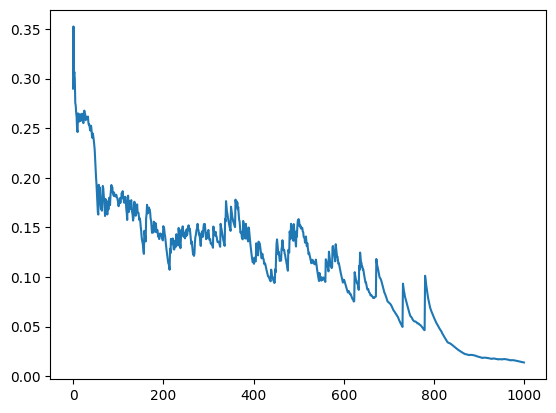

In [52]:
plt.plot(np.arange(len(losses)), losses)
plt.show()

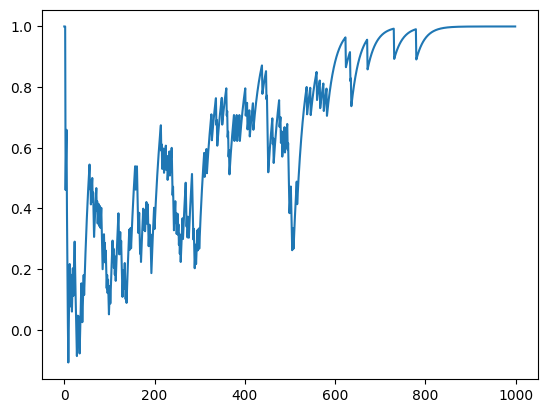

In [53]:
plt.plot(np.arange(len(scoress)), scoress)
plt.show()

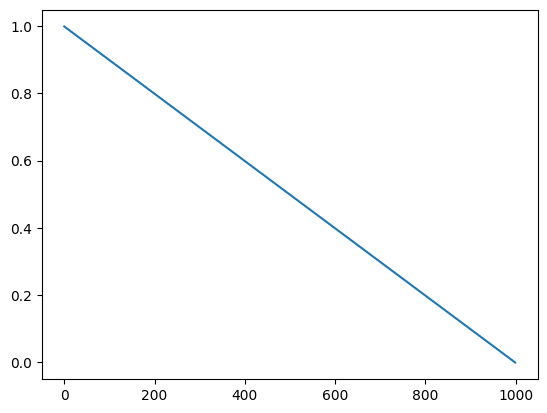

In [54]:
plt.plot(np.arange(len(epsilons)), epsilons)
plt.show()

In [62]:
linear_Q_model.predict([
    np.array([0.80]),
    np.array([keras.utils.to_categorical(1, 2)]),
])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


array([[1.1273165]], dtype=float32)